# Chapter 15 - Missing Data and Othe Opportunities

Bertrand's Box Paradox: say I cook three pancakes. The first is burnt on both sides (BB). The second is burnt only on one (BU). The third is not burnt at all (UU). You are served one pancake at random, and the side on your plate is burnt. What's the probability that the other side is also burnt?

Intuitively, 1 / 2. However, this is incorrect. We can do the math the proves it:

$$
\begin{align*}
P(burnt down | burnt up) &= \frac{P(burnt up and burnt down)}{P(burnt up)} \\
                        &= \frac{1 / 3}{1 / 2} \\
                        &= \frac{2}{3}
\end{align*}
$$

We could also do a simulation to convince ourselves, if we wanted to.

The point is that while in principle probability is simple (it's just counting), in practice it can be very tricky and require you to be quite clever. One of the advantages of the Bayesian approach is that by ruthlessly applying the formula, you don't need to be clever. You write down your assumptions about the data-generating process and let the laws of probability take it from there.

In this chapter we're going to look at two other applications of the same process:
- Incorporation of measurement error
- Estimation of missing data through Bayesian Imputation

## Measurement Error

In [[Chapter 5]], we looked at divorce and marriage data for the US and saw how we got a spurious correlation, and then how multiple regression could help sort it out.

At the time, we glossed over the fact that marriage and divorce rates were measured with some amount of error which is not uniform across the states. Let's see how we can handle that.

In [2]:
library(rethinking)
library(ggplot2)
library(dagitty)
library(cmdstanr)
library(posterior)

options(repr.plot.width = 14, repr.plot.height = 7)

Loading required package: cmdstanr

This is cmdstanr version 0.8.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/ericr/.cmdstan/cmdstan-2.35.0

- CmdStan version: 2.35.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable cmdstanr_no_ver_check=TRUE.

Loading required package: posterior

This is posterior version 1.6.0


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


Loading required package: parallel

rethinking (Version 2.40)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




In [2]:
data(WaffleDivorce)
d <- WaffleDivorce
head(d)

Location   Loc Population MedianAgeMarriage Marriage Marriage.SE Divorce
1 Alabama    AL   4.78      25.3              20.2     1.27        12.7   
2 Alaska     AK   0.71      25.2              26.0     2.93        12.5   
3 Arizona    AZ   6.33      25.8              20.3     0.98        10.8   
4 Arkansas   AR   2.92      24.3              26.4     1.70        13.5   
5 California CA  37.25      26.8              19.1     0.39         8.0   
6 Colorado   CO   5.03      25.7              23.5     1.24        11.6   
  Divorce.SE WaffleHouses South Slaves1860 Population1860 PropSlaves1860
1 0.79       128          1     435080     964201         0.45          
2 2.05         0          0          0          0         0.00          
3 0.74        18          0          0          0         0.00          
4 1.22        41          1     111115     435450         0.26          
5 0.24         0          0          0     379994         0.00          
6 0.94        11          0          0      34277         0.00

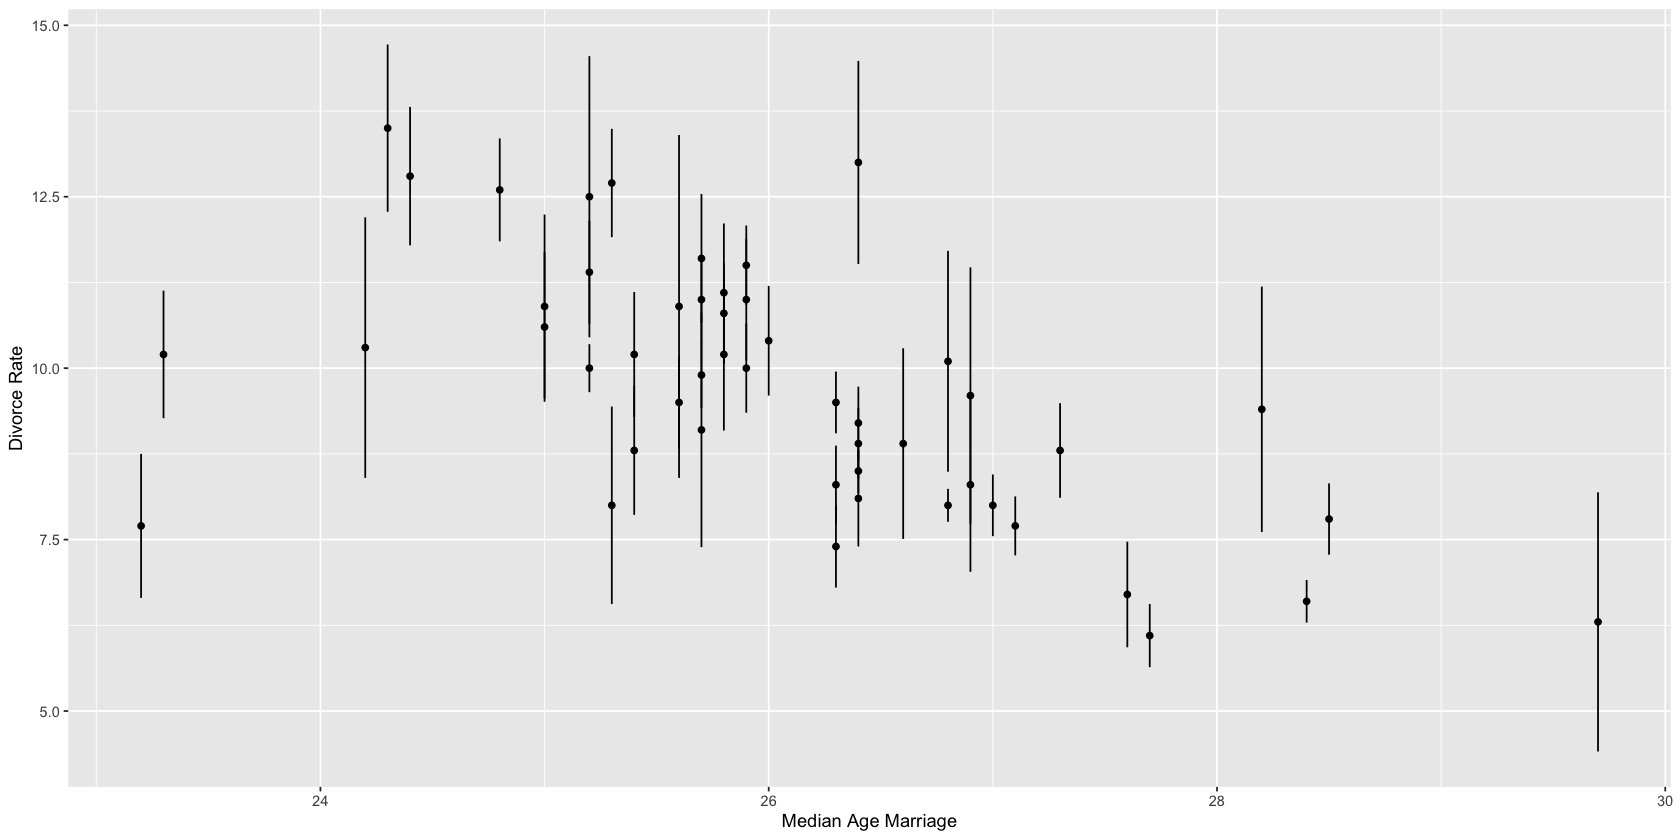

In [3]:
plot_df <- data.frame(
    d = d$Divorce,
    m = d$MedianAgeMarriage,
    lower = d$Divorce - d$Divorce.SE,
    upper = d$Divorce + d$Divorce.SE
)
ggplot(plot_df, aes(m, d)) +
    geom_point() +
    geom_errorbar(aes(ymin = lower, ymax = upper), width = 0) +
    labs(x = "Median Age Marriage", y = "Divorce Rate")

There's quite a bit of variation in the uncertainty. In general, larger states let us have less uncertainty while smaller ones have more.

Since some data are less certain than others, we want to weight the data appropriately. There are lots of ad-hoc ways to do this, but let's think about the data-generating process.

### Error on the outcome

If we were going to simulate measurement error, what would it look like? First we would generate the true values of the variables, then simulate the observation process, where the measurement error would occur.

Let's take the earlier model of the data generating process and incorporate the error.

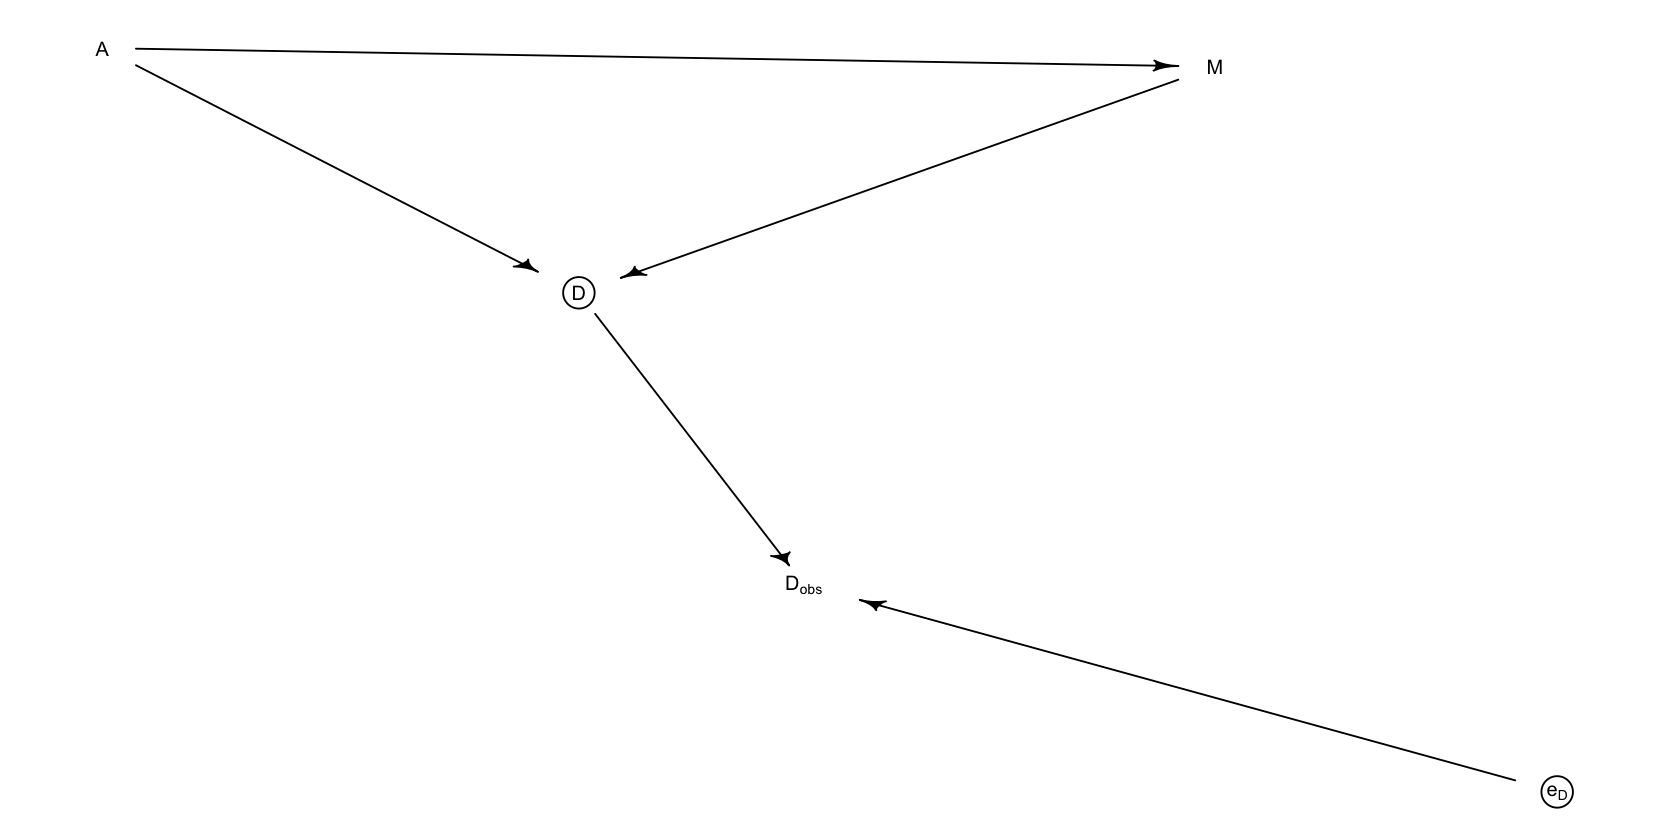

In [4]:
par(bg = 'white')
dag <- dagitty( 'dag {
D[latent]
e_D[latent]
A -> M -> D -> D_obs <- e_D
A -> D
}' )
drawdag(dag)

Here, A (age at marriage) affects the divorce rate D both directly and indirectly through the marriage rate M. Then we have the observation model. The *observed* divorce rate $D_{\text{obs}}$ is affected both by the actual, unobserved divorce rate and some sort of error term.

It seems likely that there is systematic bias in our case; that is, the error is somehow related to the variables that we can observe.

So now we're going to try to reconstruct D by incorporating our knowledge of the error process. Luckily, we have `Divorce.SE`, the standard error of the divorce rate, in the table. 

If we wanted to simulate the error, we would generate the true observation value and then throw a distribution around it. For instance, if the true measurement was 10m and we measure it with some Gaussian process with a standard deviation of 2m, then that would imply that the measurement 

$$
y \sim \text{Normal}(10, 2)
$$

If we do the same for each divorce rate, then for each true divorce rate $D_{\text{true}, i}$

$$
D_{\text{obs}, i} \sim \text{Normal}(D_{\text{true}, i}, D_{\text{SE}, i})
$$

Our model for the true divorce rate looks very similar to the earlier one, but we now add a line that takes the true values and uses them as the mean for a distribution of observed values.

$$
\begin{align*}
D_{\text{obs}, i} &\sim \text{Normal}(D_{\text{true}, i}, D_{\text{SE}, i}) \\
D_{\text{true}, i} &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_A &\sim \text{Normal}(0, 0.5) \\
\beta_B &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

This may seem silly, but the additional uncertainty we've introduced can also flow down to influence our estimates of the other parameters.

Here's the `ulam` version of the model:

In [5]:
dlist <- list(
    D_obs = standardize(d$Divorce),
    D_sd = d$Divorce.SE / sd ( d$Divorce ),
    M = standardize(d$Marriage),
    A = standardize(d$MedianAgeMarriage),
    N = nrow(d)
)

m15.1 <- ulam(
    alist(
        D_obs ~ dnorm(D_true, D_sd),
        vector[N]:D_true ~ dnorm(mu, sigma),
        mu <- a + bA * A + bM * M,
        a ~ dnorm(0, 0.2),
        bA ~ normal(0, 0.5),
        bM ~ normal(0, 0.5),
        sigma ~ dexp(1)
    ),
    data = dlist,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-3240575837f0.stan', line 24, column 4 to column 34)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 

In [6]:
precis(m15.1, depth = 2)

mean        sd         5.5%        94.5%       rhat      ess_bulk 
D_true[1]   1.17019273 0.37828029  0.56022407  1.79098485 1.0004714 2144.6867
D_true[2]   0.68781499 0.54437773 -0.17007165  1.53912785 1.0011586 2418.6358
D_true[3]   0.43394730 0.32895271 -0.07218977  0.96402287 1.0013387 2623.6271
D_true[4]   1.40720594 0.46404753  0.65465290  2.11879070 1.0002234 2500.1939
D_true[5]  -0.90308290 0.12633575 -1.09959645 -0.69665606 0.9995767 2769.7640
D_true[6]   0.65566498 0.39625316  0.02862975  1.30892475 1.0040972 2061.3330
D_true[7]  -1.35944905 0.34701890 -1.91661990 -0.78997042 1.0047153 3081.2651
D_true[8]  -0.33422822 0.46956751 -1.07265335  0.40494685 1.0010751 2059.2883
D_true[9]  -1.89491848 0.60798129 -2.84355750 -0.92632416 1.0002119 1795.3080
D_true[10] -0.61651026 0.16783536 -0.88290210 -0.34840695 1.0016373 2560.7225
D_true[11]  0.76912648 0.28953777  0.30904035  1.23301780 1.0016190 2386.0111
D_true[12] -0.55010962 0.47611613 -1.31957375  0.21437466 0.9997789 1601.0318
D_true[13]  0.18757430 0.51660019 -0.67366194  0.98897333 1.0030267 1107.7189
D_true[14] -0.86889239 0.21771714 -1.21788115 -0.51076150 0.9997746 2695.8009
D_true[15]  0.55597264 0.30588816  0.06010558  1.04777660 0.9999757 3093.2144
D_true[16]  0.28870467 0.35659858 -0.28386894  0.83703174 1.0003919 2399.3144
D_true[17]  0.50832230 0.42407430 -0.16462165  1.18898765 1.0022867 2420.1555
D_true[18]  1.25102470 0.36016272  0.69600095  1.83284085 1.0020178 2088.5891
D_true[19]  0.41608646 0.37138537 -0.16130241  1.00389190 1.0003821 2465.1191
D_true[20]  0.40107020 0.54096896 -0.43581310  1.27801505 1.0009841 1504.4253
D_true[21] -0.55244163 0.33245938 -1.06597630 -0.01322523 1.0027032 3477.3869
D_true[22] -1.10353908 0.25401535 -1.50009425 -0.70618475 1.0007687 2158.3463
D_true[23] -0.27314136 0.25672951 -0.68586442  0.13306778 1.0026461 2747.2718
D_true[24] -0.99771944 0.28758952 -1.44900075 -0.54254594 1.0020762 2257.1427
D_true[25]  0.42284332 0.40080827 -0.20976728  1.07407055 0.9995933 2331.7642
D_true[26] -0.02872683 0.31225691 -0.51172478  0.47457034 1.0015347 2912.2134
D_true[27] -0.01336462 0.51713972 -0.84926510  0.78728906 1.0017321 2772.6374
D_true[28] -0.13946619 0.38829804 -0.78104819  0.46275858 1.0036396 2634.2822
D_true[29] -0.25866143 0.48347044 -1.01517100  0.53886213 1.0006719 2142.6415
D_true[30] -1.79629469 0.24212103 -2.18602525 -1.41434745 1.0027448 2186.3729
D_true[31]  0.17636889 0.40568905 -0.45712456  0.84487083 1.0007818 2996.1850
D_true[32] -1.65865064 0.16139365 -1.91508420 -1.40153115 0.9987426 2669.7877
D_true[33]  0.11423112 0.23411263 -0.26622861  0.49446139 1.0016055 2501.2672
D_true[34] -0.04033191 0.52172571 -0.91734522  0.76703368 1.0004432 1920.8643
D_true[35] -0.12397660 0.22097249 -0.47530877  0.21883000 1.0030957 2339.5305
D_true[36]  1.27285301 0.42466394  0.58682419  1.95517620 0.9997157 2819.5160
D_true[37]  0.23854075 0.35300803 -0.30343892  0.83555671 1.0000422 2421.8987
D_true[38] -1.01932150 0.22276240 -1.37185110 -0.66616613 0.9997422 2539.6931
D_true[39] -0.93269397 0.55264068 -1.79349095 -0.04065554 1.0028740 1691.6769
D_true[40] -0.68382448 0.32883123 -1.18547005 -0.14153478 1.0002299 3065.2406
D_true[41]  0.25314461 0.55059779 -0.66394079  1.12014660 1.0011558 2692.3405
D_true[42]  0.73790887 0.34963641  0.16765827  1.28972740 1.0013853 2423.6017
D_true[43]  0.19566698 0.18222628 -0.10164354  0.49331657 1.0044294 3252.5632
D_true[44]  0.81188223 0.42331395  0.12077323  1.48312985 1.0008597 1536.2972
D_true[45] -0.41690347 0.55958898 -1.26852345  0.48240301 1.0059244 2578.6052
D_true[46] -0.39213800 0.24895538 -0.79487858  0.01147517 0.9987721 2838.4176
D_true[47]  0.12489991 0.30466253 -0.36028404  0.60963318 1.0002247 3056.6862
D_true[48]  0.57382015 0.46487786 -0.15542713  1.31824275 1.0016355 3190.1227
D_true[49] -0.64150997 0.28084832 -1.09348060 -0.20047648 1.0012311 2814.1892
D_true[50]  0.86748528 0.60147655 -0.10214998  1.80114620 0.9990250 1957.5978
a          -0.05323115 0.09803732

If we look back at [[Chapter 5]], we see that for `bA`, the previous value was about -1; it's not about half that. Still reliably negative, but less than previously. While accounting for measurement error doesn't always rely in the estimate being reduced (in magnitude), it does in this case.

The reason is pretty clear. States with either very high or very low divorce rates tend to be those with a lot of measurement uncertainty. As a result, accounting for the measurement error means that we are shrinking the estimate to the mean.

### Error on both outcome and predictor

How can we account for error in the predictor variable? The basic approach is the same. Again, consider the problem generatively - each observed predictor is a draw from a distribution with an unknwon mean, the true value, but a known standard deviation. So, we define a vector of parameters (the true means) and then make that the means of a family of Gaussian distributions.

Our updated DAG:

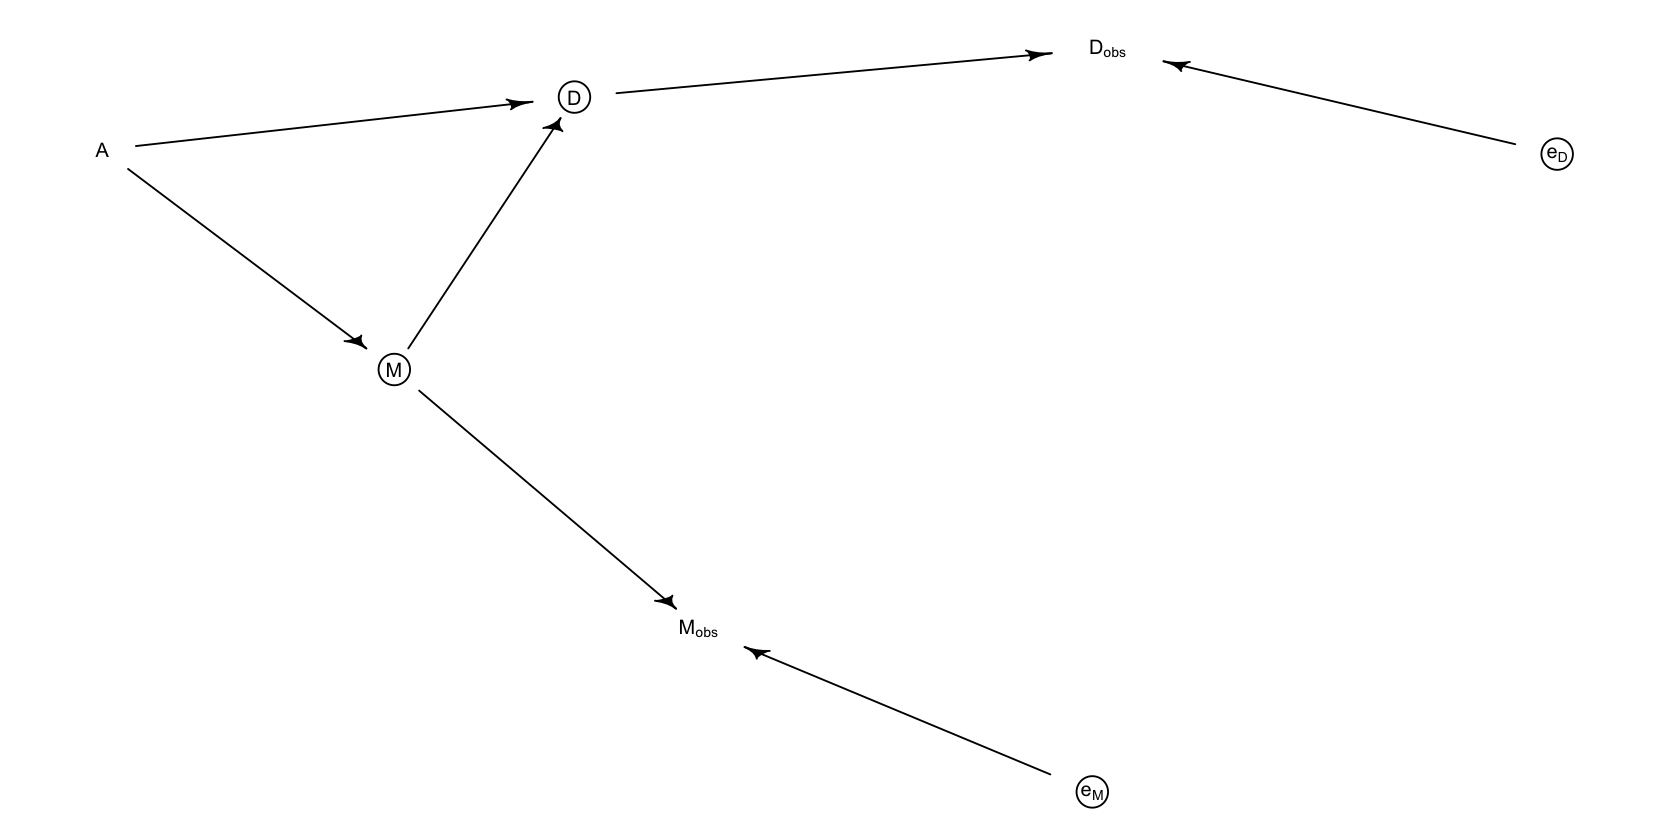

In [7]:
par(bg = 'white')
dag <- dagitty( 'dag {
A
M[latent]
D
D[latent]
e_D[latent]
M_obs
e_M[latent]
A -> M -> D -> D_obs <- e_D
A -> D
M -> M_obs <- e_M
}' )
drawdag(dag)

Here we're assuming that the errors are unrelated to each other, which may or may not be the case.

Our updated model, accounting for the measurement error in the marriage rate $M$, is

$$
\begin{align*}
D_{\text{obs}, i} &\sim \text{Normal}(D_{\text{true}, i}, D_{\text{SE}, i}) \\
D_{\text{true}, i} &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i + \beta_M M_{ \text{true}, i } \\
M_{\text{obs}, i} &\sim \text{Normal}(M_{\text{true}, i}, M_{\text{SE}, i}) \\
M_{\text{true}, i} &\sim \text{Normal}(0, 1) \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_A &\sim \text{Normal}(0, 0.5) \\
\beta_B &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

The `ulam` model:

In [8]:
dlist <- list(
    D_obs = standardize(d$Divorce),
    D_sd = d$Divorce.SE / sd ( d$Divorce ),
    M_obs = standardize(d$Marriage),
    M_sd = d$Marriage.SE / sd ( d$Marriage ),
    A = standardize(d$MedianAgeMarriage),
    N = nrow(d)
)

m15.2 <- ulam(
    alist(
        D_obs ~ dnorm(D_true, D_sd),
        vector[N]:D_true ~ dnorm(mu, sigma),
        mu <- a + bA * A + bM * M_true[i],
        M_obs ~ dnorm(M_true, M_sd),
        vector[N]:M_true ~ dnorm(0, 1),
        a ~ dnorm(0, 0.2),
        bA ~ normal(0, 0.5),
        bM ~ normal(0, 0.5),
        sigma ~ dexp(1)
    ),
    data = dlist,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32402cdc9232.stan', line 28, column 4 to column 34)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 /

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32402cdc9232.stan', line 28, column 4 to column 34)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 finished in 0.1 seconds.
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.1 seconds.
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.3 seconds.



In [9]:
precis(m15.2, depth = 2)

mean         sd         5.5%         94.5%       rhat      ess_bulk 
D_true[1]   1.13433264  0.3690825   0.55099477   1.72252850 1.0004427 1646.086 
D_true[2]   0.74616686  0.5489973  -0.11191985   1.60943590 1.0007015 1988.286 
D_true[3]   0.41691551  0.3183682  -0.08564223   0.93850466 1.0055187 3194.858 
D_true[4]   1.43432986  0.4691921   0.71200365   2.20091540 1.0012641 2609.295 
D_true[5]  -0.89881580  0.1289171  -1.10733500  -0.69620401 0.9998149 3440.723 
D_true[6]   0.68494014  0.3943552   0.06379339   1.33366660 1.0022508 1901.802 
D_true[7]  -1.35654489  0.3292908  -1.89152825  -0.83201067 1.0011750 2374.387 
D_true[8]  -0.25989754  0.5091727  -1.08507880   0.56154718 1.0018183 2526.617 
D_true[9]  -1.74174121  0.5941859  -2.66644765  -0.77430921 1.0005659 1598.854 
D_true[10] -0.62092344  0.1709839  -0.89546742  -0.34951265 1.0022084 3682.694 
D_true[11]  0.77147279  0.2856137   0.31894381   1.23408015 0.9994421 2436.231 
D_true[12] -0.44306098  0.4619307  -1.17983485   0.26512776 1.0029831 1525.300 
D_true[13]  0.21151020  0.4971366  -0.60226826   0.97620949 1.0019523 1173.536 
D_true[14] -0.86056501  0.2279807  -1.22735125  -0.50341130 1.0007022 2401.562 
D_true[15]  0.54439041  0.2874016   0.08881382   1.01446100 1.0013547 2574.739 
D_true[16]  0.29728544  0.3949568  -0.31807408   0.92871504 0.9992187 3087.745 
D_true[17]  0.51181619  0.4083260  -0.15088502   1.17527175 0.9995087 2640.360 
D_true[18]  1.24129216  0.3519974   0.67529240   1.80364715 1.0025568 2335.943 
D_true[19]  0.42795722  0.3628967  -0.12852991   1.02549145 1.0001932 2900.801 
D_true[20]  0.25076882  0.5294264  -0.53853045   1.16322375 0.9997152 1198.975 
D_true[21] -0.54618165  0.3169422  -1.04084730  -0.02641297 1.0002932 3079.849 
D_true[22] -1.10028990  0.2627452  -1.51290290  -0.68744664 1.0051920 2444.830 
D_true[23] -0.29946375  0.2589851  -0.70779235   0.11373284 1.0035967 2782.821 
D_true[24] -1.02819849  0.2942648  -1.49650265  -0.56893931 1.0028487 2284.682 
D_true[25]  0.40641913  0.4196642  -0.24312205   1.10152650 1.0032986 3286.215 
D_true[26] -0.03918168  0.2948189  -0.50737740   0.42993854 0.9995589 4126.156 
D_true[27] -0.02440914  0.4973183  -0.80028998   0.78427218 1.0008949 2173.303 
D_true[28] -0.15017130  0.3910983  -0.76928069   0.48377512 1.0032866 2920.919 
D_true[29] -0.30440974  0.4661738  -1.00868925   0.43089805 0.9995577 2147.704 
D_true[30] -1.80127681  0.2351544  -2.17920150  -1.42308185 1.0011984 2622.393 
⋮          ⋮            ⋮          ⋮            ⋮           ⋮         ⋮        
M_true[25] -0.138381341 0.37095607 -0.752260920  0.46140621 1.0027692 2298.2284
M_true[26] -0.378392906 0.21725192 -0.722153190 -0.02844751 1.0034417 2821.7777
M_true[27] -0.308018549 0.51734554 -1.132613200  0.52312191 1.0069131 2349.5306
M_true[28] -0.149156453 0.36491643 -0.721418875  0.42328050 1.0020540 2840.5963
M_true[29] -0.711930932 0.40080665 -1.363661900 -0.05931375 1.0062422 2736.0402
M_true[30] -1.372775655 0.14641021 -1.610220750 -1.14210890 1.0013143 2506.7758
M_true[31]  0.077548865 0.42692829 -0.588803275  0.76487825 1.0002299 2509.4041
M_true[32] -0.863429028 0.11894202 -1.056780550 -0.67557661 1.0017267 3450.9610
M_true[33]  0.073777867 0.26403515 -0.347215395  0.50758430 1.0012866 2807.8096
M_true[34]  0.976458280 0.60840004 -0.006188487  1.92762860 0.9996393 2713.3987
M_true[35] -0.817817150 0.15527968 -1.071070550 -0.56458379 1.0023873 2886.6604
M_true[36]  0.900847110 0.32124866  0.398686420  1.40179850 1.0022620 2997.2493
M_true[37] -0.284582170 0.28340017 -0.727678245  0.17790691 1.0041338 2423.1520
M_true[38] -1.195990718 0.12474012 -1.396551850 -0.99853929 1.0062196 3196.7175
M_true[39] -0.993825286 0.48075452 -1.744511800 -0.22911870 1.0001030 2959.7419
M_true[40] -0.499241100 0.29976196 -0.977383255 -0.03208993 1.0055252 3119.8520
M_true[41]  0.003375357 0.55836981 -0.889006095  0.88912900 1.0026484 2505.5905
M_true[42] -0.155986594 0.22676749 -0.515421580  0.20843698 1.0017993 2670.2570
M_true[43] 

Adding in the measurement uncertainty to the marriage rate didn't really affect the coefficients for marriage rate and age at marriage, *BUT* it did provide an updated estimate of the actual marriage rate. Essentially, it is shrinking the true marriage rate towards the mean.

In general, the lesson here is that if you have a distribution of values, don't treat it as a single value. Don't just use the 'average' value in the regression! That is throwing away data.

There's also something slightly wrong about the above model. Note that in our [[DAG]], $A \to M$. This implies that we really should be using some sort of model involving $A$ to estimate $M$. We'll do that in a practice problem later in the chapter.

### Measurement terrors

The errors we've dealt with so far are relatively benign; the errors are uncorrelated with each other and with the other variables in the model. These errors don't introduce any new confounds (non-causal paths). But that is not always the case!

For instance, what if the errors are correlated because they are both influenced by some other variable $P$:

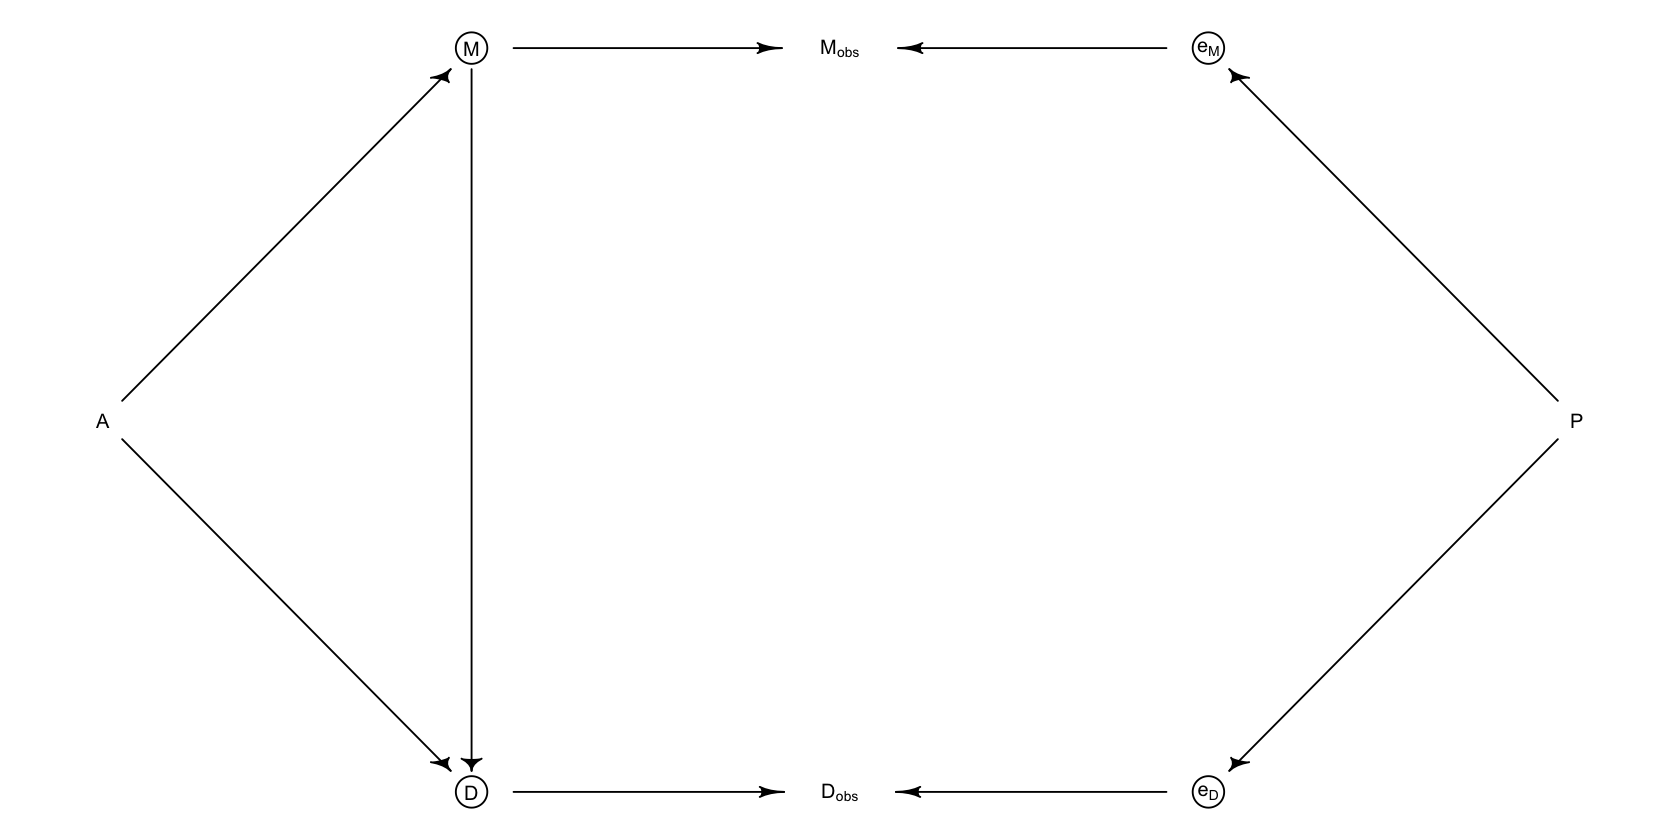

In [10]:
par(bg = 'white')
dag <- dagitty( 'dag {
A[pos="0,0"]
M[latent,pos="1,-1"]
M_obs[pos="2,-1"]
D[latent,pos="1,1"]
D_obs[pos="2,1"]
e_D[latent,pos="3,1"]
e_M[latent,pos="3,-1"]
P[pos="4,0"]
A -> M -> D -> D_obs <- e_D
A -> D
M -> M_obs <- e_M
e_M <- P -> e_D
}' )
drawdag(dag)

Now, regressing $D_{\text{obs}}$ on $M_{\text{obs}}$ will open a non-causal path through $P$! If we have an idea of the process we can deal with it by considering the covariance between the errors; it's basically the same as using an instrumental variable ([[Chapter 14]]).

Another thing that can happen is that another variable influences the error and creates another non-causal path. For instance, what if the true marriage rate infliences the error on the divorce rate?

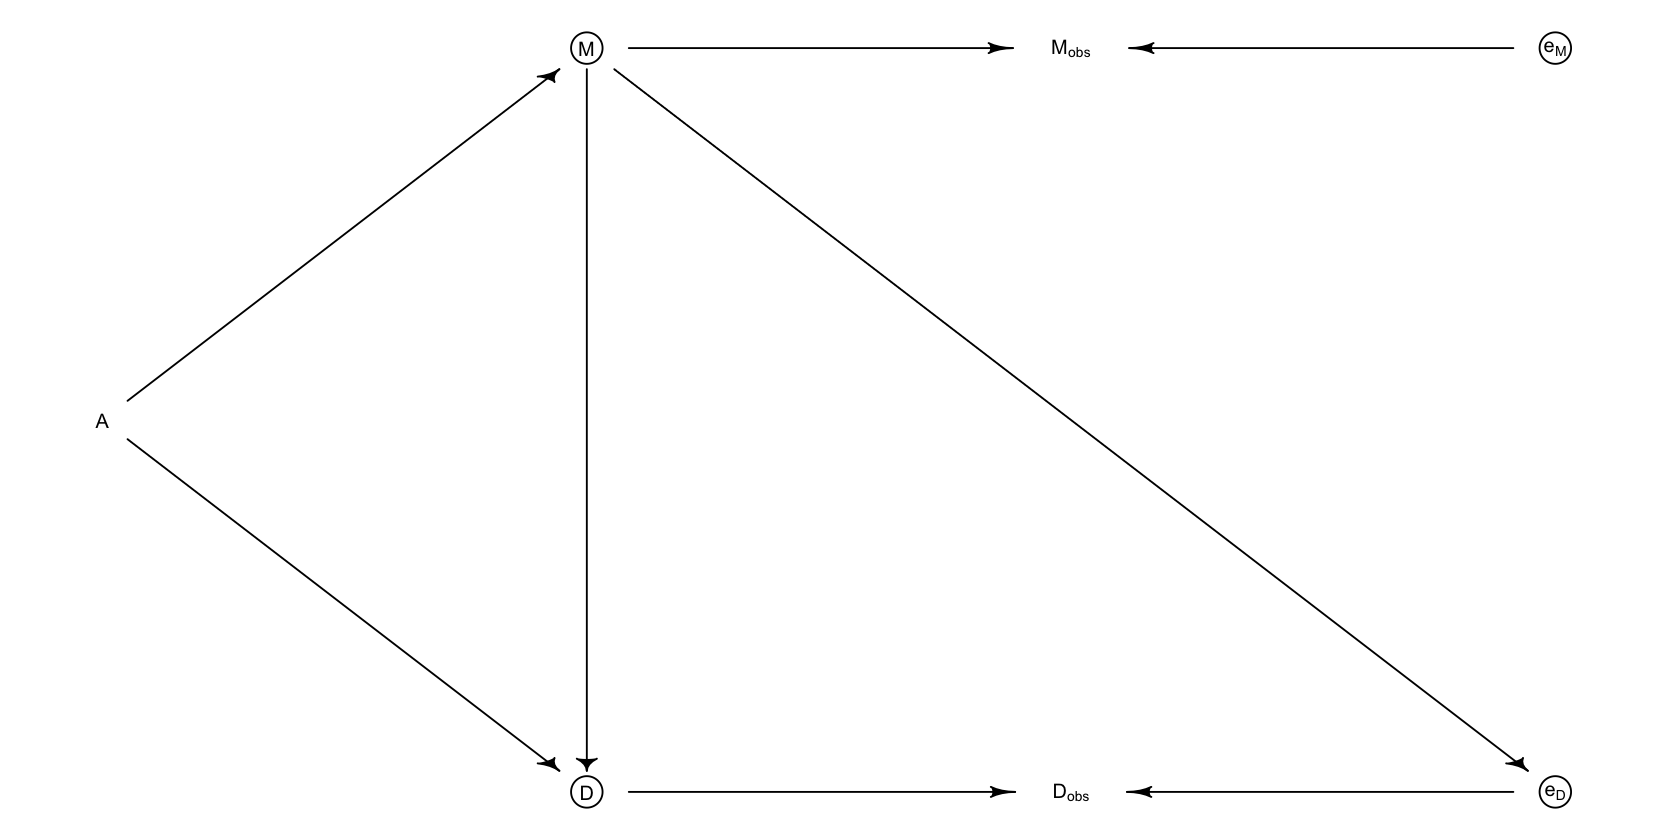

In [11]:
par(bg = 'white')
dag <- dagitty( 'dag {
A[pos="0,0"]
M[latent,pos="1,-1"]
M_obs[pos="2,-1"]
D[latent,pos="1,1"]
D_obs[pos="2,1"]
e_D[latent,pos="3,1"]
e_M[latent,pos="3,-1"]
A -> M -> D -> D_obs <- e_D
A -> D
M -> M_obs <- e_M
M -> e_D
}' )
drawdag(dag)

How could this occur? Well, if the marriage rate is small then there just aren't many couples to get divorce, which increases the error on the divorce rate. This produces a non-causal path from $M_{\text{obs}}$ to $D_{\text{obs}}$ which passes through $e_D$. If we can average over the uncertainty in the true M and D using information about ehmeasurement process, then we can probably account for this. However, it is rarely done.

Another issue is when we measure a causal variables less precisely than a non-causal variable. Say that we know that we know D and M very precisely, but now A is measured with error. Also assume that M has no causal effect on D, like this:

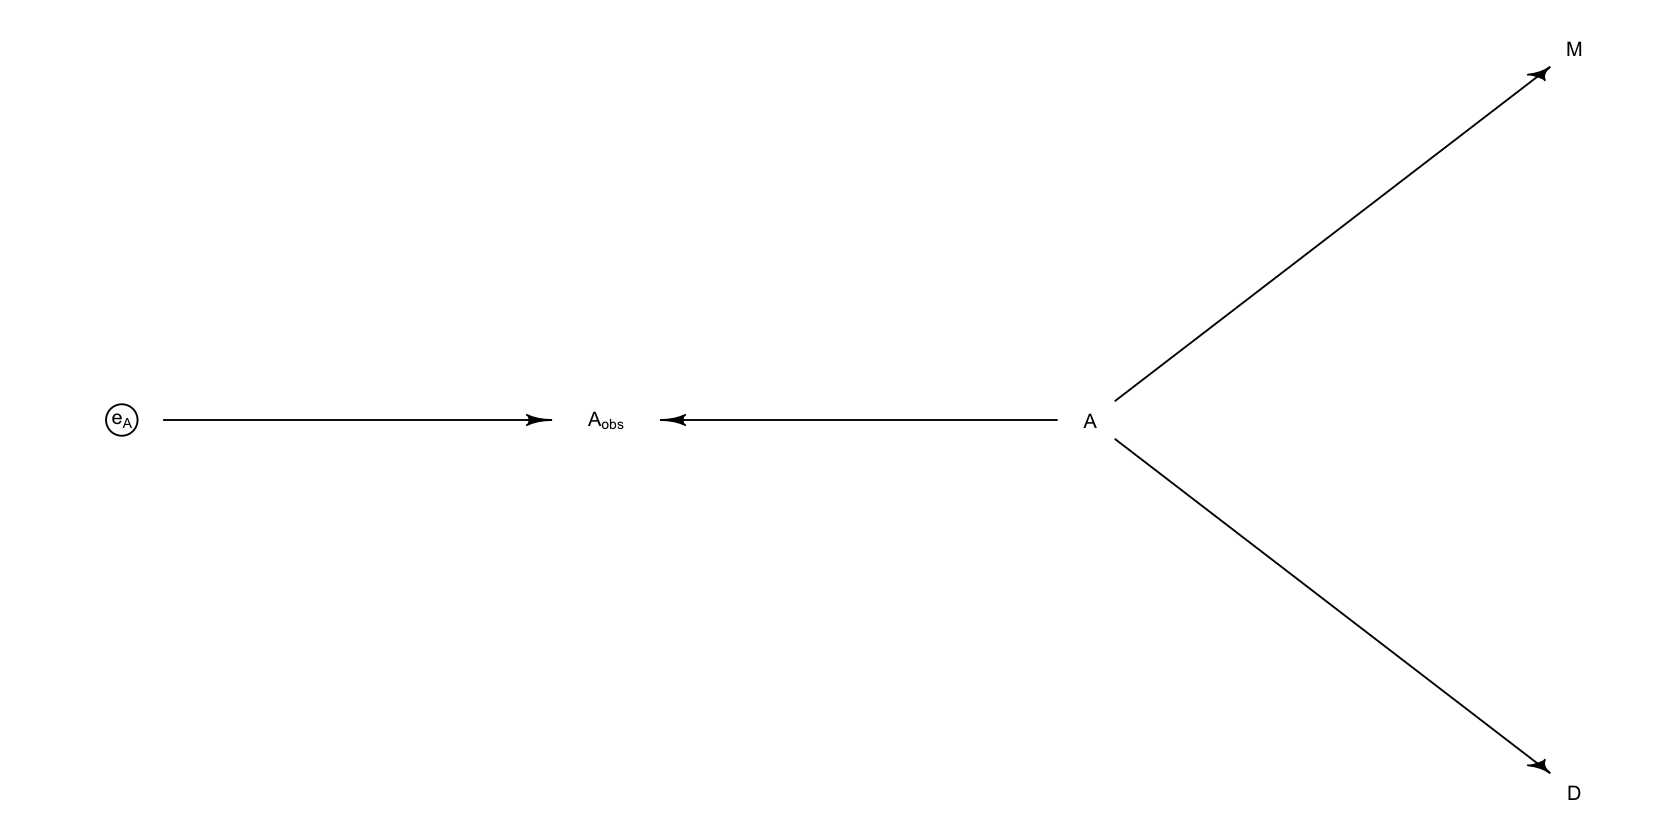

In [12]:
par(bg = 'white')
dag <- dagitty( 'dag {
e_A[latent, pos="0,0"]
A_obs[pos="1,0"]
A[pos="2,0"]
M[pos="3,-1"]
D[pos="3,1"]
e_A -> A_obs <- A -> D
A -> M
}' )
drawdag(dag)

In this case, a naive regression of D on $A_{\text{obs}}$ and M will suggest that M influences D when this is in fact not the case. The reason is that M contains information about the true A, and M is measured more precisely than A. It's like a proxy for A. Here's a small simulation which will create such an effect.

In [13]:
N <- 500
A <- rnorm(N)
M <- rnorm(N, -A)
D <- rnorm(N, A)
A_obs <- rnorm(N, A)

When you have your own data and measurement concerns, all of this can be overwhelming! The solution is the same as ever: write down your generative model, simulate the data, and create a model that can work, at least in theory.

## Missing Data

With measurement error, the insight is to realize that any uncertain piece of data can be replaced by a distribution that reflects uncertainty. But sometimes it goes beyond that - we are missing data entirely!

Most common approach is to just drop any any with missing data. This is known as [[Complete Case Analysis]], and is the default (and often silent) approach of lots of statistical software. Another common approach is to replace the value with some assumed value (like the mean for the other data or 0). Neither of these is completely safe. These approaches can produce bias.

Another approach is to **impute** missing values. A generative model tells you whether the process that produced the missing values will also prevent the identification of causal effects. We can add the missingness to a [[DAG]] and use the same critiera as before to see whether it produces confounding. A generative model can also provide information about data we haven't seen yet.

Missing data are still meaningful data, just with a special data. The fact that the data isn't there tells us something. There is a special type of model, [[Occupancy Model]]s, which deal with this.

### DAG ate my homework

Consider students who own dogs. The students produce homework, H. The homework varies in quality by how much studying a student does, S.

In [14]:
N <- 100
S <- rnorm(N)
H <- rbinom(N, size=10, inv_logit(S))

The homework is graded on a 10-point scale, and in general more studying results in more points.

Then some dogs eat the homework. We can think of this as its own variable, D, which is 0 or 1 depending on whether the dog ate the homework. We can't observe the true distribution anymore; we're observing $H^*$, the uneaten homework.

We'd like to see the effect of studying on homework, but we have to use $H^*$ instead of $H$. We are hoping that $H^*$ is a reliable indicator of $H$. When is this true?

Let's look at 4 scenarios:

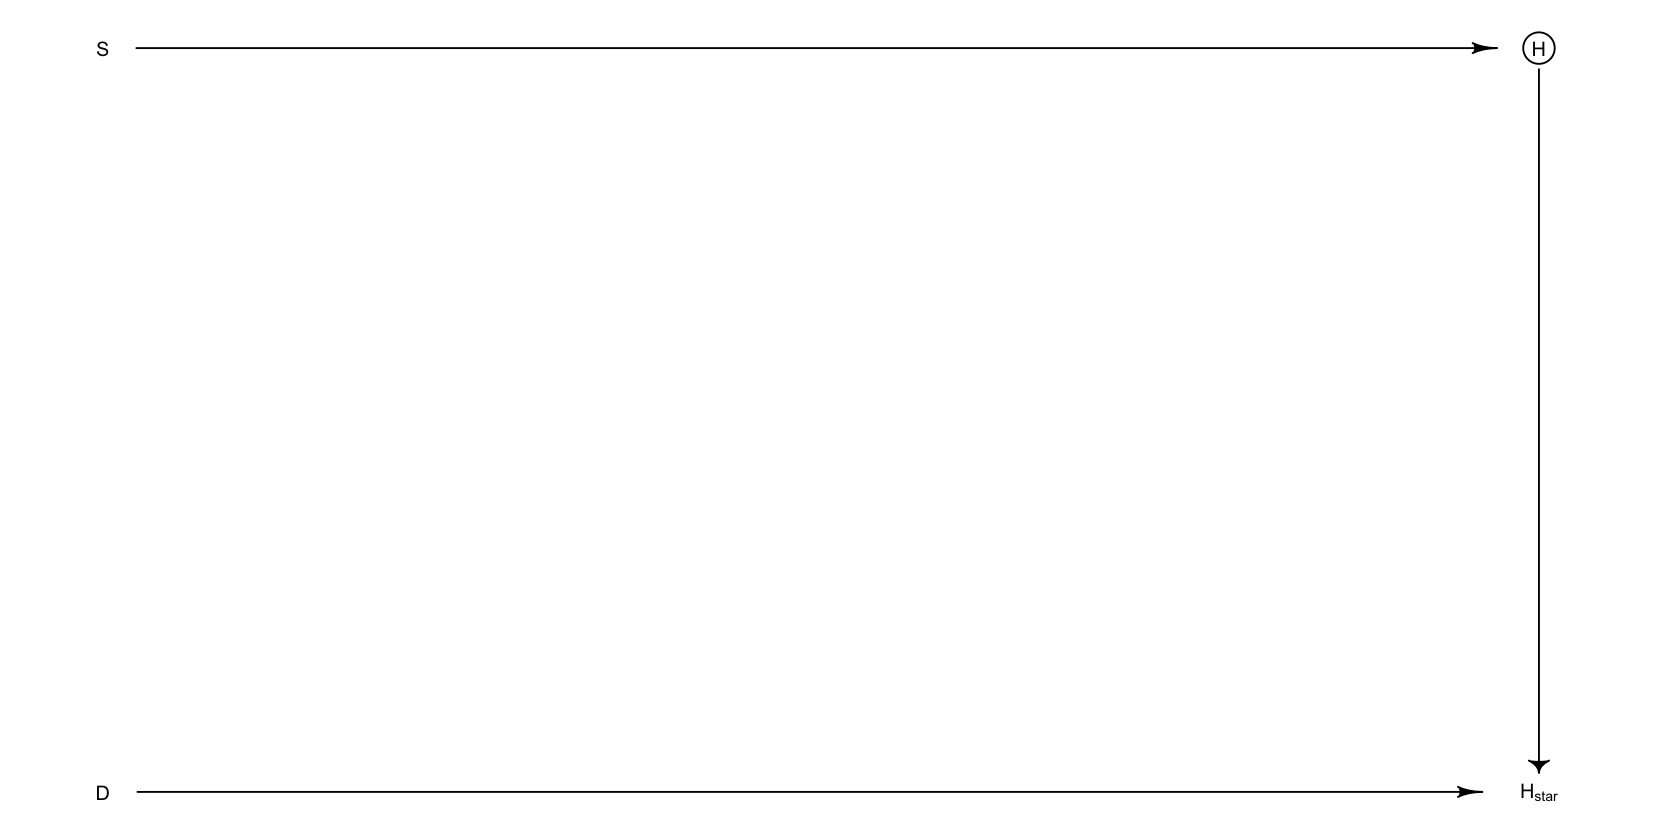

In [15]:
par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
S -> H
H -> H_star
H_star <- D
}' )
drawdag(dag)
# a)

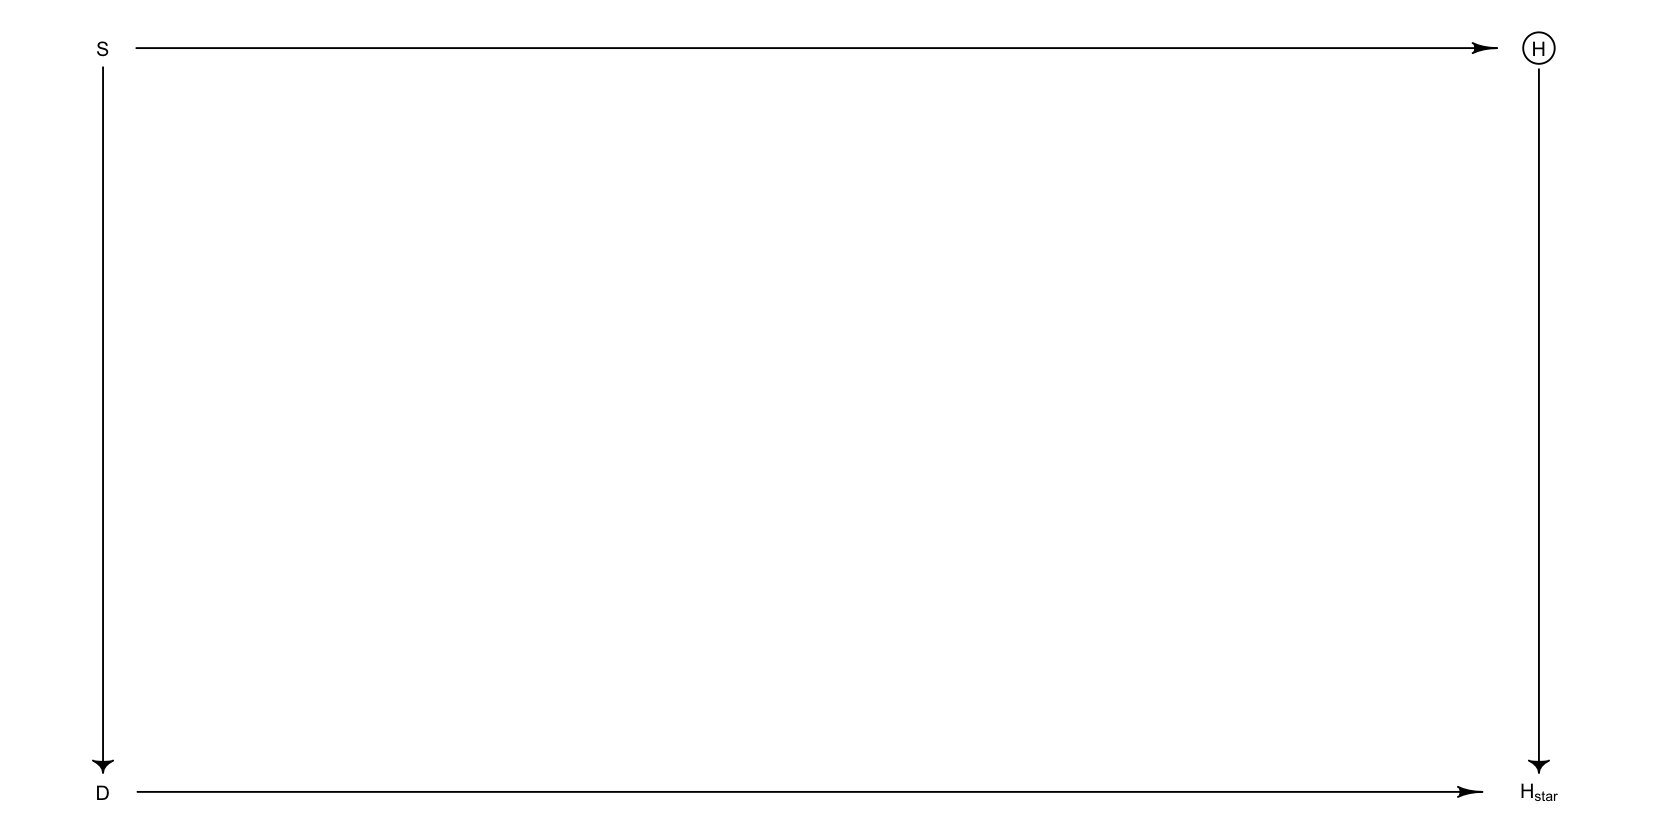

In [16]:
par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
S -> H
H -> H_star
H_star <- D
S -> D
}' )
drawdag(dag)
# b)

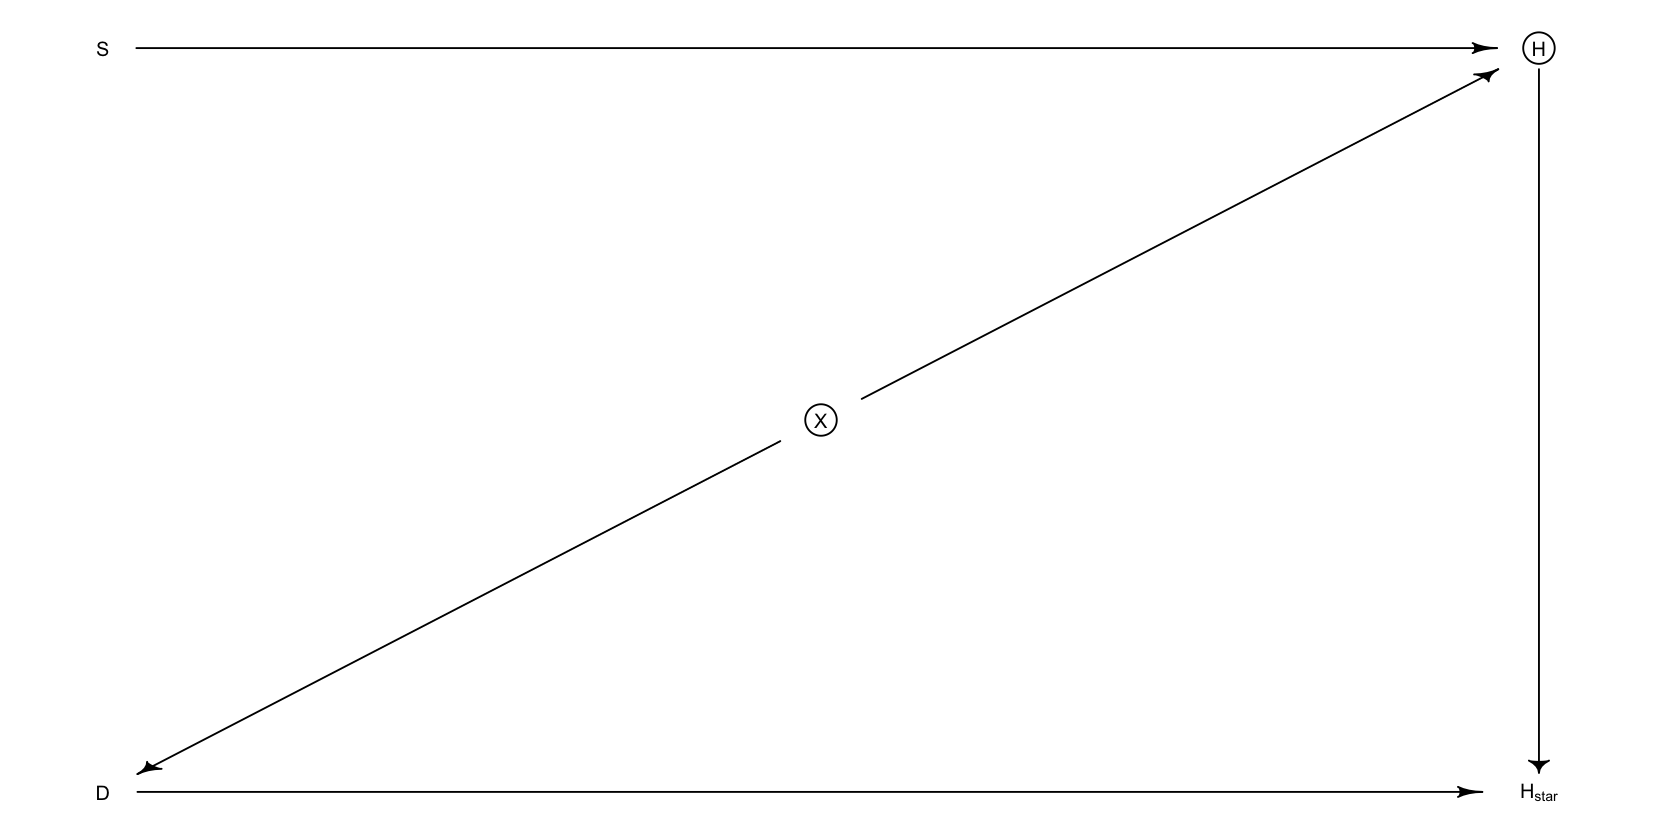

In [17]:
par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
X[latent,pos="0.5,0.5"]
S -> H
H -> H_star
H_star <- D
D <- X -> H
}' )
drawdag(dag)
# c)

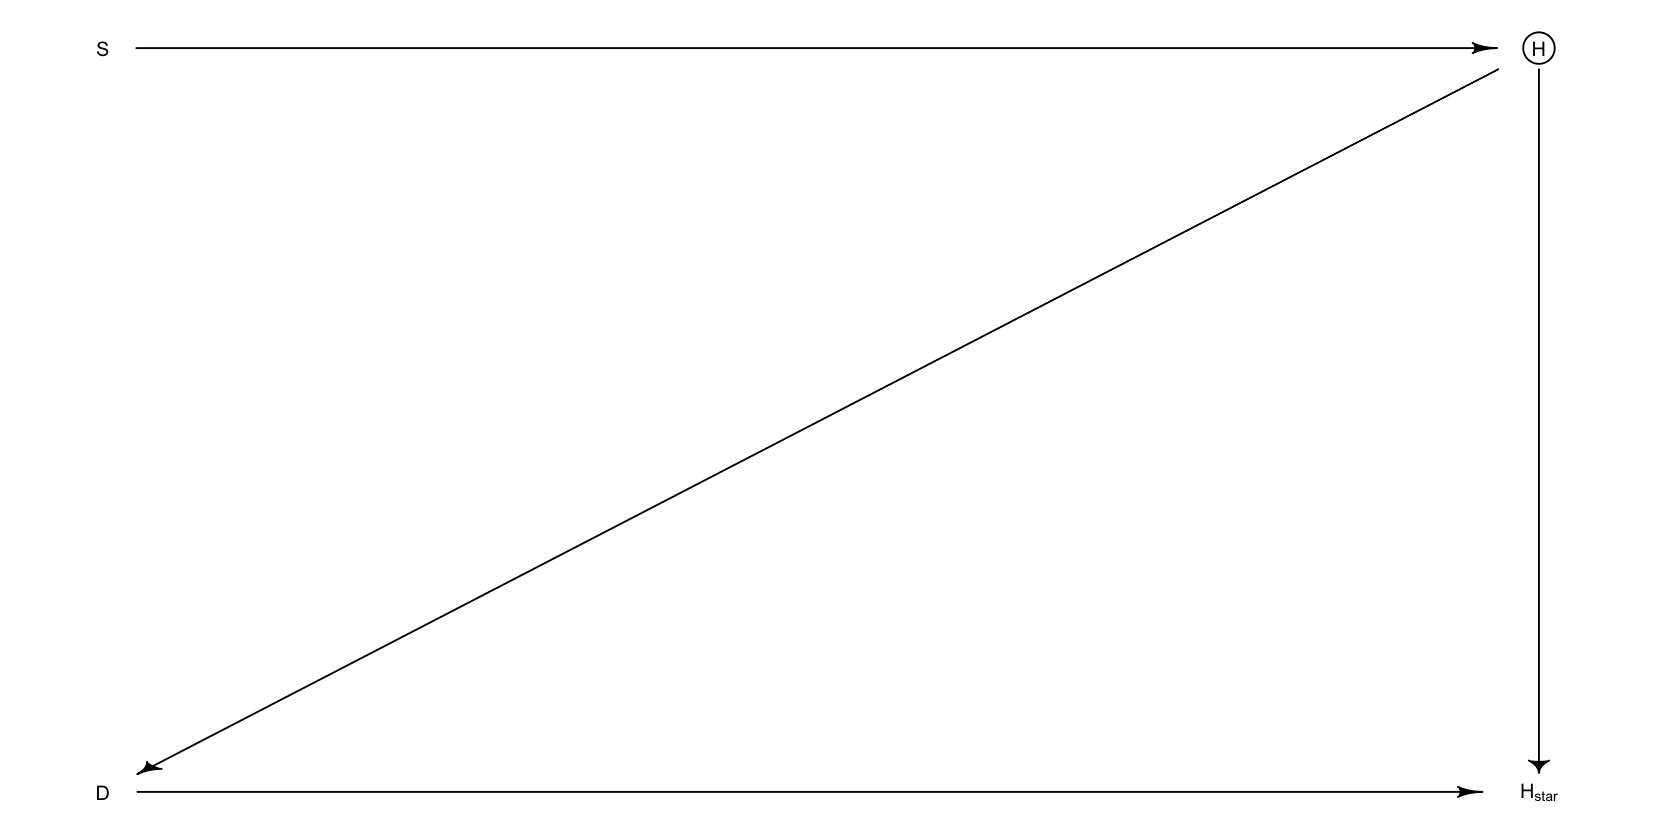

In [18]:
par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
S -> H
H -> H_star
H_star <- D
H -> D
}' )
drawdag(dag)
# c)

The simplest case is a), where the dogs eat the homework completely at random.

In [19]:
D <- rbern(N)
Hm <- H # this is H^*
Hm[D==1] <- NA

Can we still estimate the effect of S on H when we have to use H* instead? We can decide by considering whether the outcome H is independent of D. More generally, a minimal condition for missing values is that the outcome is indenpendent of (d-separated from) them.

In this case, H is independent of D ($H \perp D$) because $H^*$ is a collider.

The second case, b), is trickier. Here, studying affects whether the dog eats the homework. Maybe students who study a lot don't play with their dogs, who then take revenge by eating their homework.

In [20]:
D <- ifelse(S > 0, 1, 0)
Hm <- H
Hm[D==1] <- NA

Now the dogs are eating all of the homework of the students who are above average. This is clearly a problem we need to deal with! There is now a non-causal (backdoor) path $H \to H^* \leftarrow D \leftarrow S$ which we need to close. If we don't close this non-causal path, it'll confound the causal path $S \to H$. We can close the non-causal path by conditioning on $S$ (which we want to do anyway), so that's fine.

This doesn't mean that there can be no problems here. The missing data can mask effects in that area. For instance, say studying has no effect until you study more than the average. In that case, we wouldn't see that in this data at all.

The next scenario, c), is more difficult. Now there is a new unobserved variable that is observing both H and D, say X, the noise level of the student's house. In a noisy house, students produce lower-quality homework: $X \to H$. In addition, dogs in noisy houses tend to misbehave and eat the homework: $X \to D$. Now when we regress $H^*$ on $S$, there's a new causal pathway $H^* \leftarrow D \leftarrow X \to H$.

The tricky thing to figure out is what effect this has on our estimate of $S \to H$. Let's actually code this one out.

In [21]:
set.seed(501)
N <- 1000
X <- rnorm(N)
S <- rnorm(N)
H <- rbinom(N, size = 10, inv_logit(2 + S - 2 * X))
D <- ifelse(X > 0, 1, 0)
Hm <- H
Hm[D==1] <- NA

data_list <- list(
    H = H,
    S = S
)

m15.3 <- ulam(
    alist(
        H ~ binomial(10, p),
        logit(p) <- a + bS * S,
        a ~ normal(0, 1),
        bS ~ normal(0, 0.5)
    ),
    data = data_list,
    chains = 4,
    cores = 4
)
precis(m15.3)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteratio

mean      sd         5.5%      94.5%     rhat     ess_bulk
a  1.1137787 0.02440114 1.0753689 1.1528838 1.005822 1273.602
bS 0.6909998 0.02593923 0.6505647 0.7344682 1.002464 1226.848

We know that the true coefficient on S should be 1, and instead we get about 0.69 - we're way off. Note that this model uses the complete data, so it's not the missingness of the data that's the problem - it's a case of omitted variable bias, like we saw in [[Chapter 10]]. In a generalized linear moden, even if an unovserved variable like X doesn't structurally confound or interact with the predictor of interest like S that doesn't mean that it won't cause bian in estimation of the effect of S. The reason is that there are ceiling and floor effects on the outcome variables that induce interactions amoong all predictors.

So what impact does using the missing data have?

In [22]:
data_list_0 <- list(
    H = H[D==0],
    S = S[D==0]
)

m15.4 <- ulam(
    alist(
        H ~ binomial(10, p),
        logit(p) <- a + bS * S,
        a ~ normal(0, 1),
        bS ~ normal(0, 0.5)
    ),
    data = data_list_0,
    chains = 4,
    cores = 4
)
precis(m15.4)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

mean      sd         5.5%      94.5%    rhat     ess_bulk
a  2.9678386 0.07546972 2.8447471 3.090686 1.005279 978.9585
bS 0.9049999 0.06558462 0.7964059 1.011402 1.007610 882.0336

So this estimate is still biased, but way less - it actually includes the correct value in the range! What is going on? Basically, the ones we're missing are from the noisy houses, and it's the noisy houses that are messing up the estimates - they are the ones where the omitted variable, noise, is coming in to play. By dropping those houses, we actually improve the estimate!

Note that this just happened in this case - we could easily change things so that the missing data would make the estimate worse. For instance, if the rule was

```R
D <- ifelse(abs(X) < 1, 1, 0)
```
then we would see the exact opposite effect.

So having a structure like this doesn't mean that we are safe *or* that the effects of missingness will be bad, but it does tell us that we need to be careful.

Now we just need to examine the last case, d). Now there is a path $S \to D$. Dogs prefer to eat bad homework, perhaps because the students feed it to them.

In [23]:
N <- 1000
S <- rnorm(N)
H <- rbinom(N, size = 10, inv_logit(S))
D <- ifelse(H < 5, 1, 0)
Hm <- H
Hm[D==1] <- NA

Unfortunately, there is no good way to estimate the causal effect $S \to H$. There's nothing we can do here because there's nothing we can condition on to block the path $S \to H \to D \to H^*$. This kind of missingness, where the variable causes its own missing values, is the worst, because unless we have a firm grasp on the mechanism that produces it, there's nothing much we can do. Sometimes you just need to go back and take better measurements.

### Imputing primates

Addressing missing data often involves **imputation** of missing values. We do that both so that we can avoid biased estimation and also so that we can use all of the observed (not missing) data. 

The key idea is that the generative model contins information about values that haven't been observed.

Let's return to the primate milk example from [[Chapter 5]]. We used `data(milk)` to illustrate masking using both the neocortex percent and body mass to predict milk energy. There were some missing values, which at the time we dealt with by just dropping the entire row of data which contained them. Can we do better?

We need to think clearly about *why* the data were missing. The basic [[DAG]] is

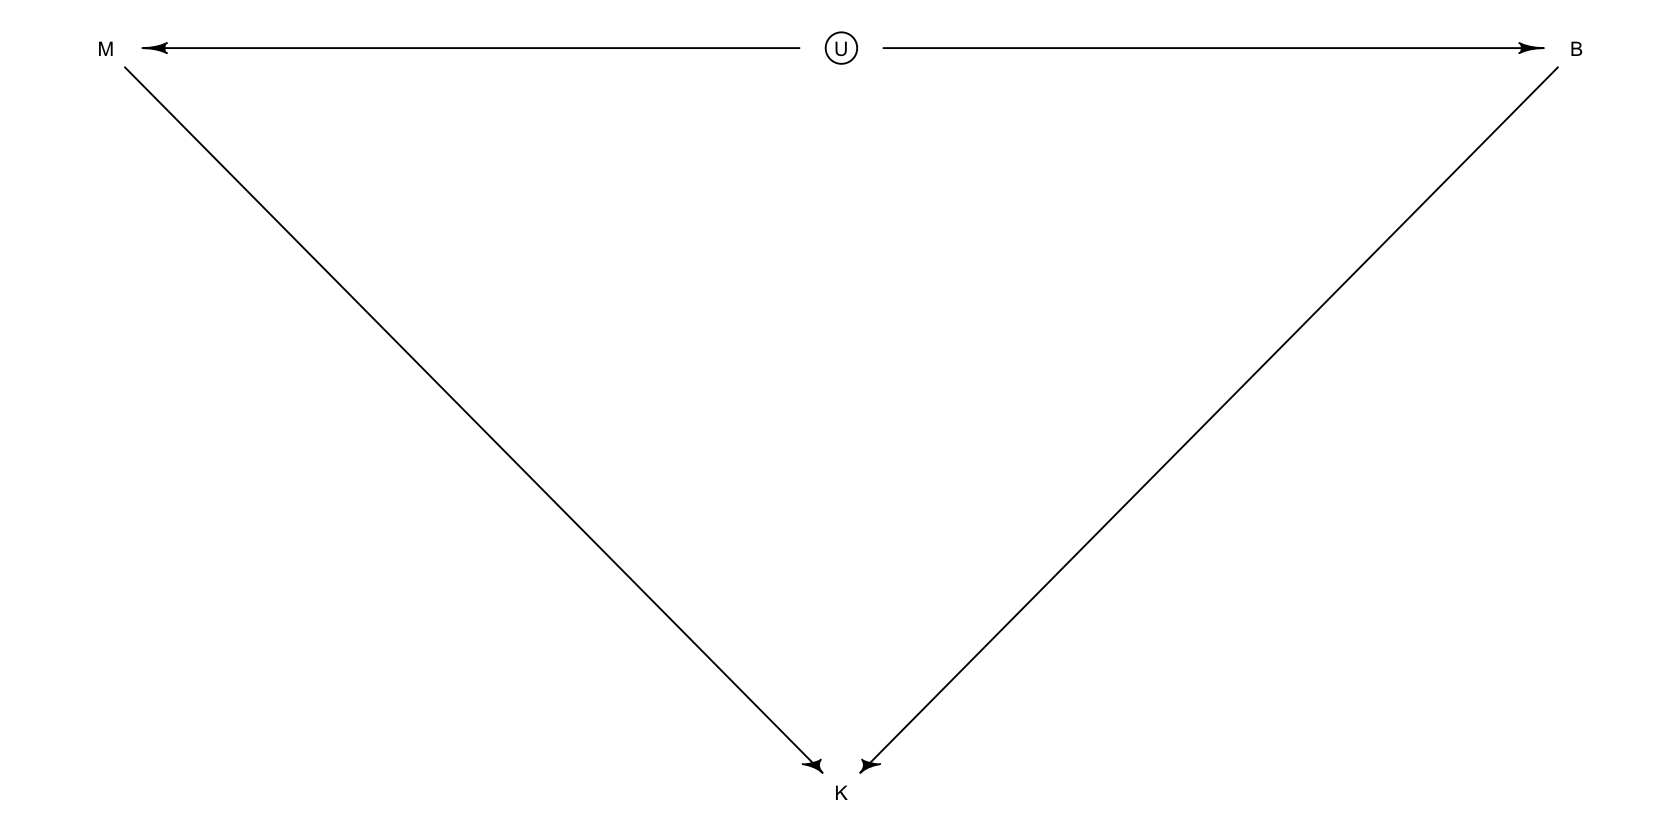

In [24]:
par(bg = 'white')
dag <- dagitty( 'dag {
U[latent,pos="0,0"]
M[pos="-1,0"]
B[pos="1,0"]
K[pos="0,2"]
U -> M -> K <- B <- U
}' )
drawdag(dag)

M: body mass, B: neocortex percent; K: milk energy; U: some unobserved variable that positively correlates M and B.

We want to add missingness to the model. We haven't observed B, but instead $B^*$, the observed values of B generated by B and some process. We don't know the process. Whatever it is, it sometimes produces missing values. This same process also generates $R_B$, which indicates which species have missing values. This is analogous to the D variable (where the dog at the homework) in the earlier example.

So let's look at some ways that the process could be.

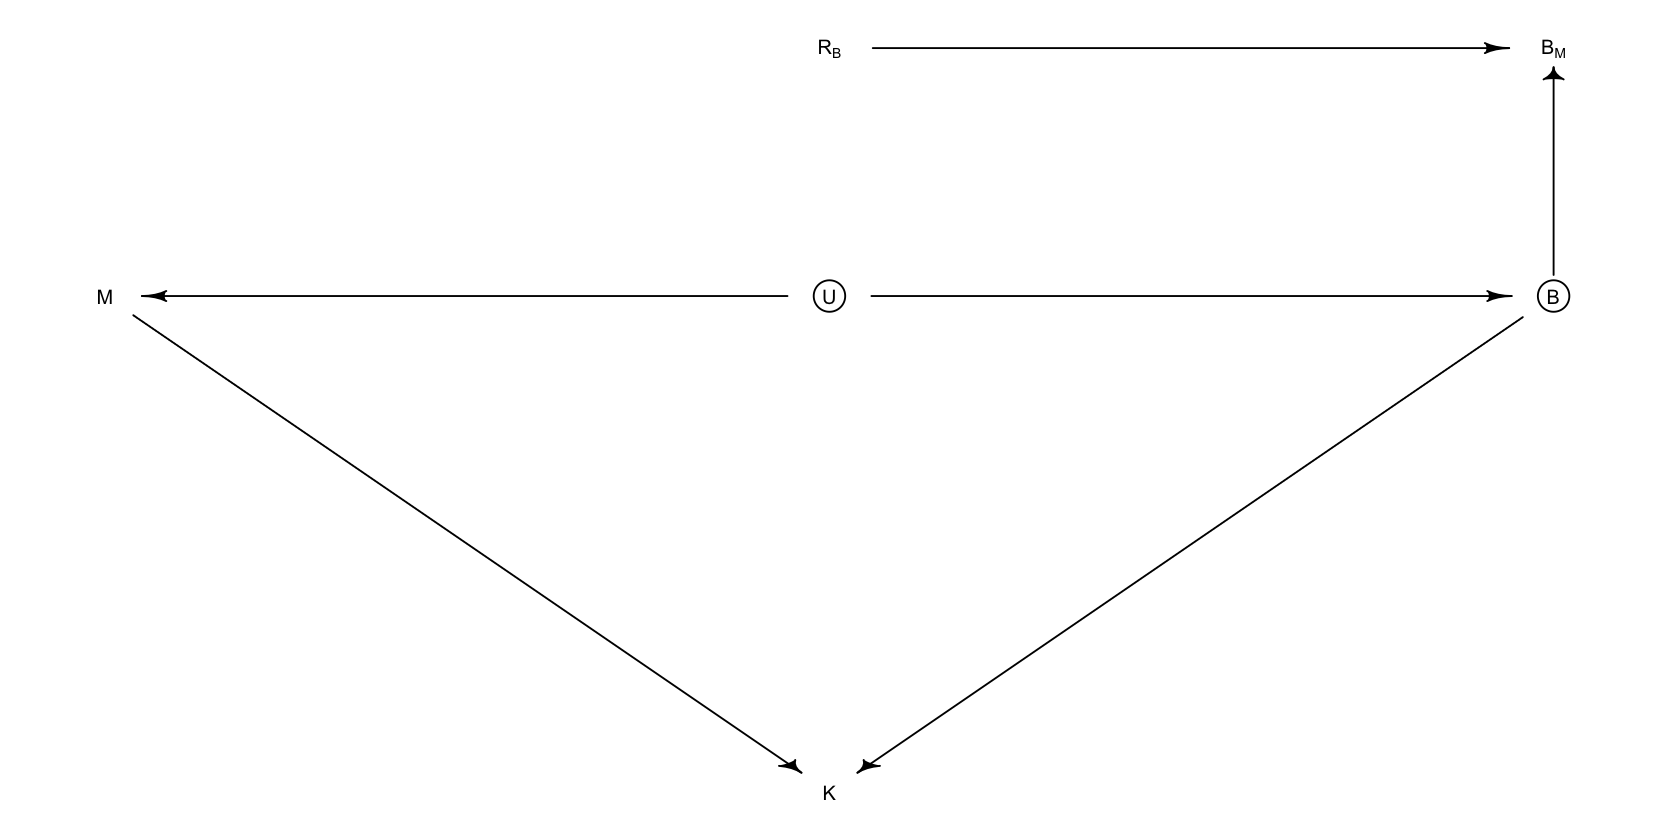

In [25]:
par(bg = 'white')
dag <- dagitty( 'dag {
U[latent,pos="0,0"]
M[pos="-1,0"]
B[latent,pos="1,0"]
K[pos="0,2"]
B_M[pos="1, -1"]
R_B[pos="0,-1"]
U -> M -> K <- B <- U
R_B -> B_M <- B
}' )
drawdag(dag)

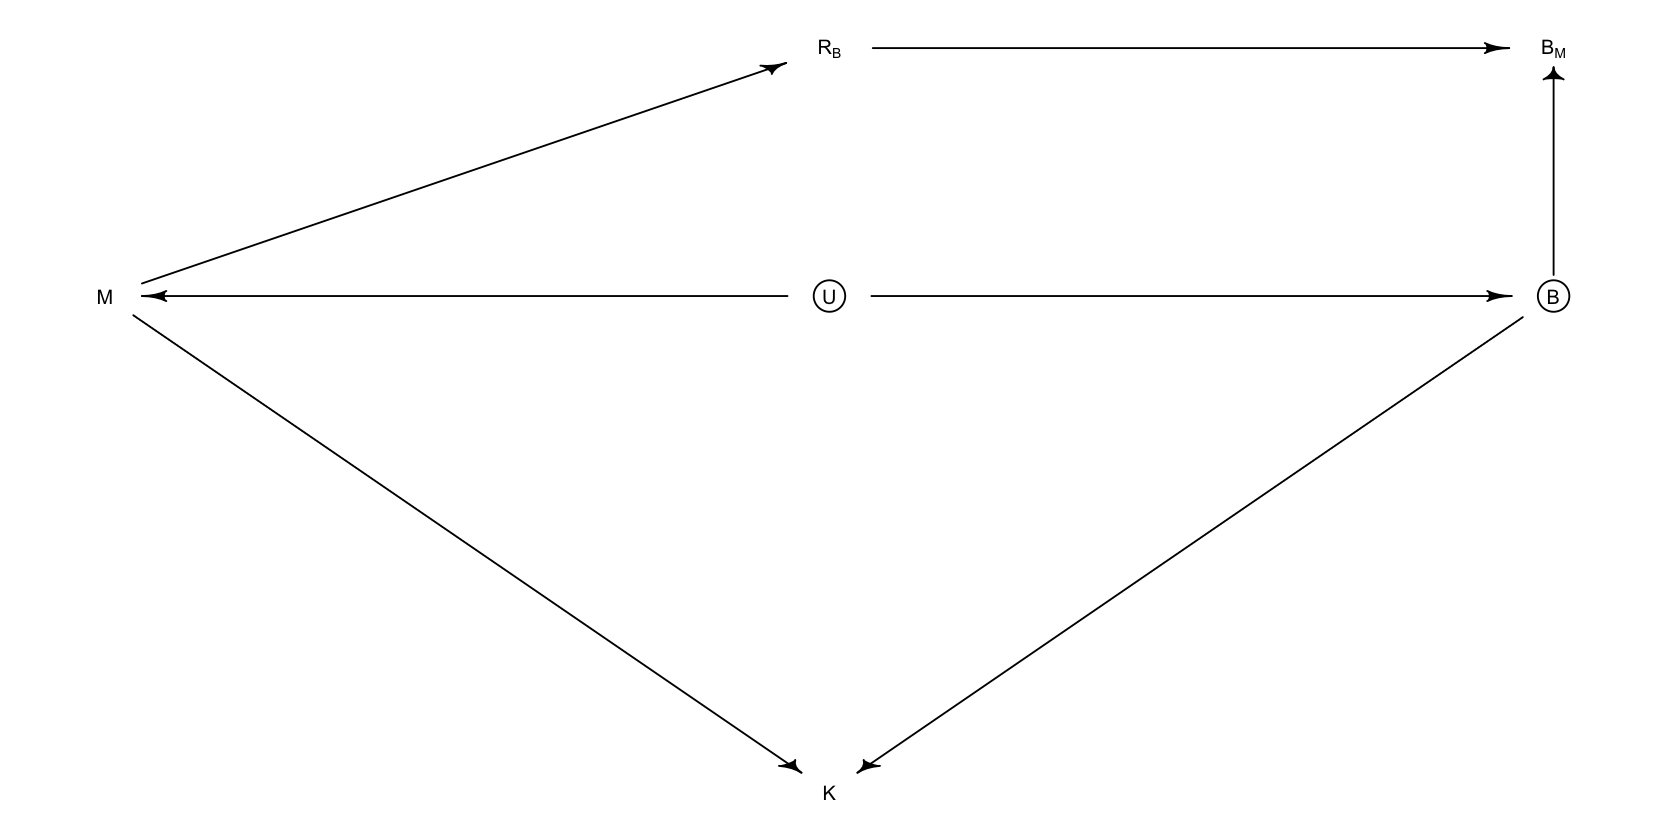

In [26]:
par(bg = 'white')
dag <- dagitty( 'dag {
U[latent,pos="0,0"]
M[pos="-1,0"]
B[latent,pos="1,0"]
K[pos="0,2"]
B_M[pos="1, -1"]
R_B[pos="0,-1"]
U -> M -> K <- B <- U
M -> R_B -> B_M <- B
}' )
drawdag(dag)

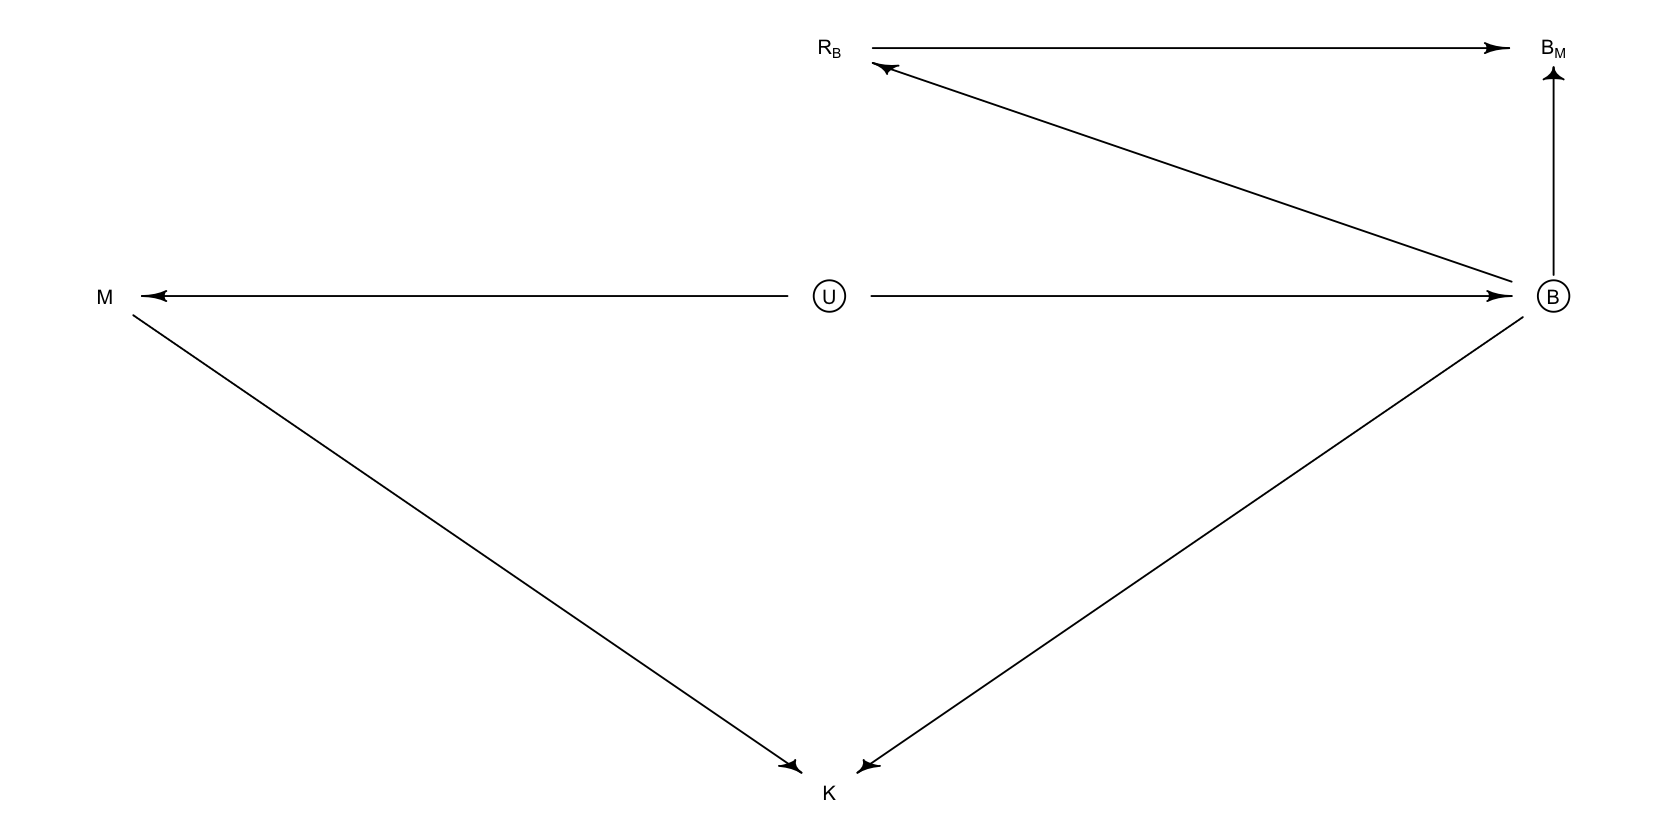

In [27]:
par(bg = 'white')
dag <- dagitty( 'dag {
U[latent,pos="0,0"]
M[pos="-1,0"]
B[latent,pos="1,0"]
K[pos="0,2"]
B_M[pos="1, -1"]
R_B[pos="0,-1"]
U -> M -> K <- B <- U
B -> R_B -> B_M <- B
}' )
drawdag(dag)


In the first case, there's nothing influencing the $R_B$; it's random. No new non-causal path is introduced. Dropping the missing values is annoying (because we now have less data), but it doesn't necessarily bias the results.

In the next one, body mass M influences the missing values. Maybe smaller species are harder to study, and so it's more likely that no one has bothered to measure their brain neocortex values. Now there's a new non-causal path $B_M \leftarrow R_B \leftarrow M \to K$. Luckily, we want to condition on $M$ anyway, which will block this path. It's probably a good idea to try to impute the missing values so that we don't throw away data.

How would we know if $M$ influences $R_B$? We could test it by trying to measure the causal influence of $M$ on $R_B$. [NOTE: I don't think you can - to do that you would need to block the route $M \to U \to B \to R_B$, and you can't condition on the unobserved confound $U$ or the real value of $B$.]

In the last example, we have the brain size itself influencing the missing values. This could happen if anthropologists are more interested in studying larger-brained species. For instance, there's a lot more study of chimpanzees than lemurs! This is a bad situation. If true, then the causal path $B \to K$ will be biased by the non-causal path through $R_B$. It is not possible to test (with the data that we have) if $B$ influences $R_B$. Lots of different paths can lead to this scenario. For instance,

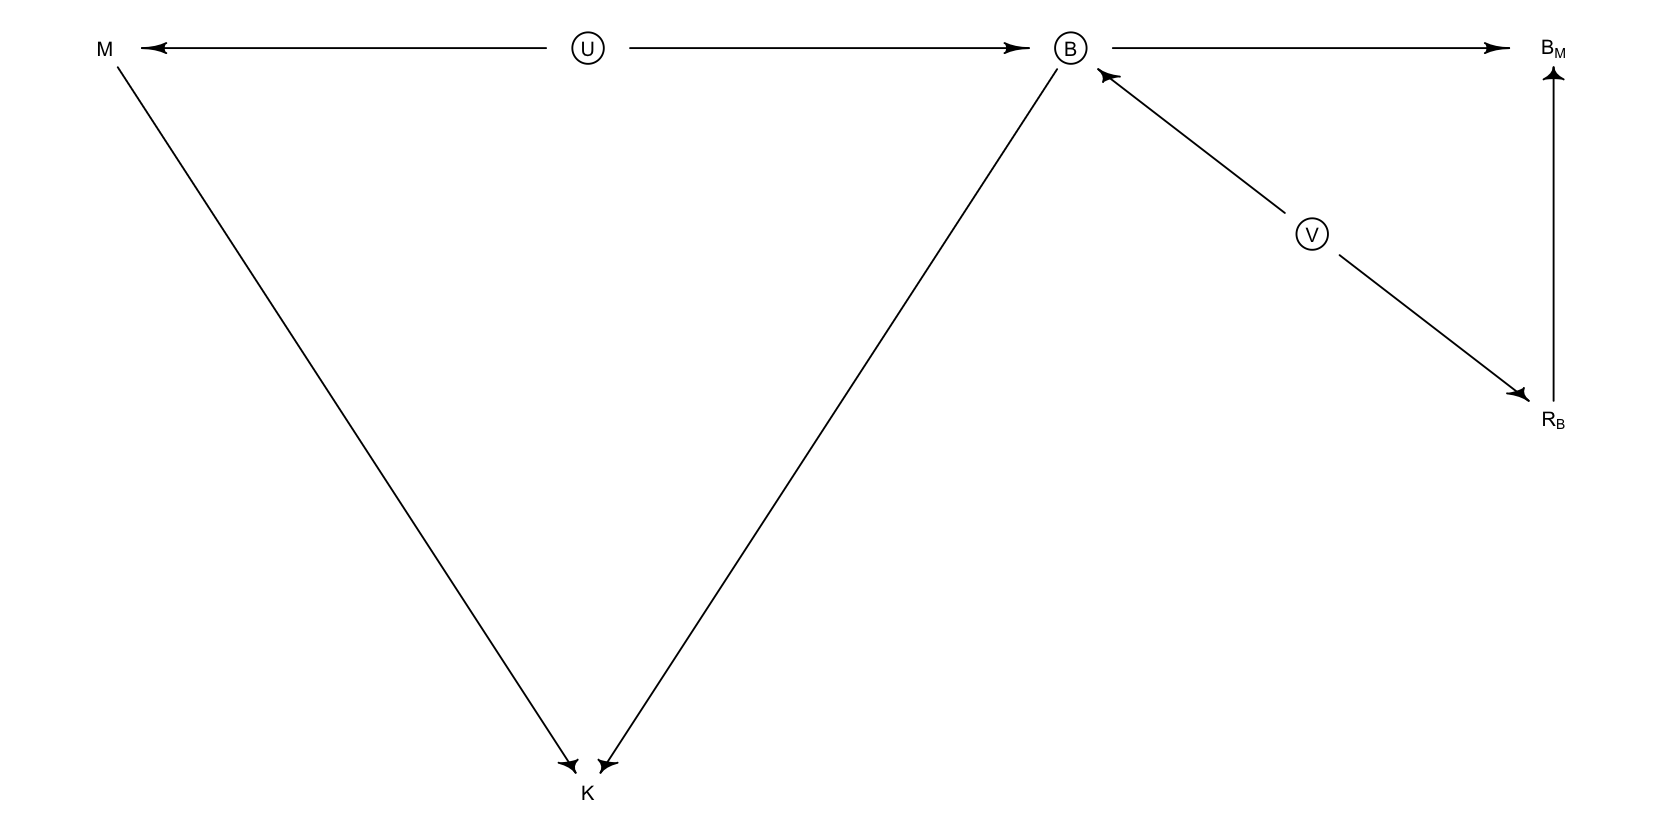

In [28]:
par(bg = 'white')
dag <- dagitty( 'dag {
U[latent,pos="0,0"]
M[pos="-1,0"]
B[latent,pos="1,0"]
K[pos="0,2"]
B_M[pos="2,0"]
R_B[pos="2,1"]
V[latent,pos="1.5,0.5"]
U -> M -> K <- B <- U
B_M <- B
B <- V -> R_B -> B_M
}' )
drawdag(dag)


Now, it's not just that $B$ influences $R_B$, it's that there's another unobserved variable $V$ that influences both. For instance, $V$ might be the phylogenetic similarity to humans; if you're more closely related to us you tend to have a larger brain, and also we are more interested in studying you.

In all of these scenarios we want to impute missing values. For the first two it's just to avoid throwing away perfectly good data just because we're missing the neocortex data. In the third, it's actually required for us to have any hope of getting a reasonable estimate of $B \to K$.

The trick is to model the variable that has missing values. Each missing value is assigned a unique parameter. The observed values give us information about the missing points. This distribution becomes a prior for the missing values, which will then be updated in full by the model itself. Conceptually, this is similar to the measurement error case; if we don't know something we condition it on what we know and let the model figure it out.

In our case, the variable with missing values is neocortex percent.

$$
B = [0.55, B_2, B_3, B_4, 0.65, \dots, 0.76, 0.75]
$$

at every index $i$ there's a missing value we substitute $B_i$.

The simplest model imputes $B_i$ from its own normal distribution:

$$
\begin{align*}
K_i &\sim \text{Normal}(\mu_i, \sigma) & \text{[distribution for the outcome $k$]} \\
\mu_i &= \alpha + \beta_B B_i + \beta_M \log M_i & \text{[linear model]} \\
B_i &\sim \text{Normal}(\nu, \sigma_B) & \text{[distribution for obs / missing $B_i$]} \\
\alpha &\sim \text{Normal}(0, 0.5) \\
\beta_B &\sim \text{Normal}(0, 0.5) \\
\beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\nu &\sim \text{Normal}(0.5, 1) \\
\sigma_B &\sim \text{Exponential}(1)
\end{align*}
$$

This model ignores the $B$ and $M$ are associated through $U$, but we'll start here.

The line $B_i \sim \text{Normal}(\nu, \sigma_B)$ is a bit weird. When the value of $B_i$ is present (we have data) it's treated as a likelihood, and so the model learns the values of $\nu$ and $\sigma_B$ which are consistent with the data. However, when the data is missing ($B_i$ is a parameter) the same line is interpreted as a prior on their values. Since $\nu$ and $\sigma_B$ are also estimated, the prior learns from the data, much like the varying effects in [[Chapter 14]].

One problem is that we are assuming that the value of $B_i$ is gaussian, when really we know that they're bounded between 0 and 1 (it's a proportion). We can probably do better, but this is fine for now.

There are a few ways that we can do this, but basically all of them are pretty awkward. We'll just let `ulam` sort it out for us!

In [29]:
data(milk)
d <- milk
d$neocortex.prop <- d$neocortex.perc / 100
d$logmass <- log(d$mass)
data_list <- list(
    K = standardize(d$kcal.per.g),
    B = standardize(d$neocortex.prop),
    M = standardize(d$logmass)
)

m15.5 <- ulam(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bB * B + bM * M,
        B ~ dnorm(nu, sigma_B),
        c(a, nu) ~ dnorm(0, 0.5),
        c(bB, bM) ~ dnorm(0, 0.5),
        sigma_B ~ dexp(1),
        sigma ~ dexp(1)
    ),
    data = data_list,
    chains = 4,
    cores = 4
)

Found 12 NA values in B and attempting imputation.



Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404a8a173e.stan', line 39, column 4 to column 37)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404a8a173e.stan', line 43, column 4 to column 29)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 finished in 0.1 seconds.
Chain 2 finished in 0.1 seconds.
Chain 3 finished in 0.1 seconds.
Chain 4 finished in 0.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.2 seconds.



In [30]:
precis(m15.5, depth = 2)

mean        sd        5.5%       94.5%      rhat      ess_bulk 
nu           -0.04806923 0.2155830 -0.4077549  0.2978903 1.0027600 1868.0193
a             0.03120284 0.1623288 -0.2288159  0.2823759 1.0002707 2585.4309
bM           -0.55226999 0.2054321 -0.8709424 -0.2141439 1.0006715 1095.1961
bB            0.50226800 0.2386156  0.1134150  0.8686776 1.0003071  685.4172
sigma_B       1.01531723 0.1781059  0.7735621  1.3418366 1.0019530 1170.2058
sigma         0.83768913 0.1434604  0.6274638  1.0891315 0.9991455 1161.8942
B_impute[1]  -0.55730325 0.9337633 -1.9996652  0.9153375 1.0026708 1724.8237
B_impute[2]  -0.70548448 0.9532522 -2.2121364  0.8663440 1.0018641 2234.0474
B_impute[3]  -0.72148205 0.9752446 -2.2625929  0.8954592 1.0007890 2123.7104
B_impute[4]  -0.28141481 0.8796742 -1.7024782  1.1307877 0.9991928 2754.0045
B_impute[5]   0.46687048 0.9284270 -1.0016713  1.9739118 1.0020424 2334.4280
B_impute[6]  -0.20205137 0.9204928 -1.6317521  1.2567215 1.0022914 3325.8821
B_impute[7]   0.20285666 0.8843572 -1.1949831  1.5937761 1.0001837 2991.8945
B_impute[8]   0.30949547 0.8885944 -1.0794815  1.7021163 0.9996722 3053.7255
B_impute[9]   0.54433826 0.8531000 -0.8331232  1.8878052 1.0024702 2442.1673
B_impute[10] -0.48879004 0.9069856 -1.9082390  0.9422354 1.0016513 2621.8590
B_impute[11] -0.30686694 0.8649289 -1.7085280  1.0512337 1.0001684 2672.0959
B_impute[12]  0.17402853 0.8990116 -1.2783172  1.5454635 1.0005535 2693.7855

Note the imputed values for the missing $B$.

Let's see how imputing the missing values has changed our estimation. The model is the same, we're just using different data.

In [31]:
obs_idx <- which(!is.na(d$neocortex.prop))
dat_list_obs <- list(
    K = data_list$K[obs_idx],
    M = data_list$M[obs_idx],
    B = data_list$B[obs_idx]
)
m15.6 <- ulam(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bB * B + bM * M,
        B ~ dnorm(nu, sigma_B),
        c(a, nu) ~ dnorm(0, 0.5),
        c(bB, bM) ~ dnorm(0, 0.5),
        sigma_B ~ dexp(1),
        sigma ~ dexp(1)
    ),
    data = dat_list_obs,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

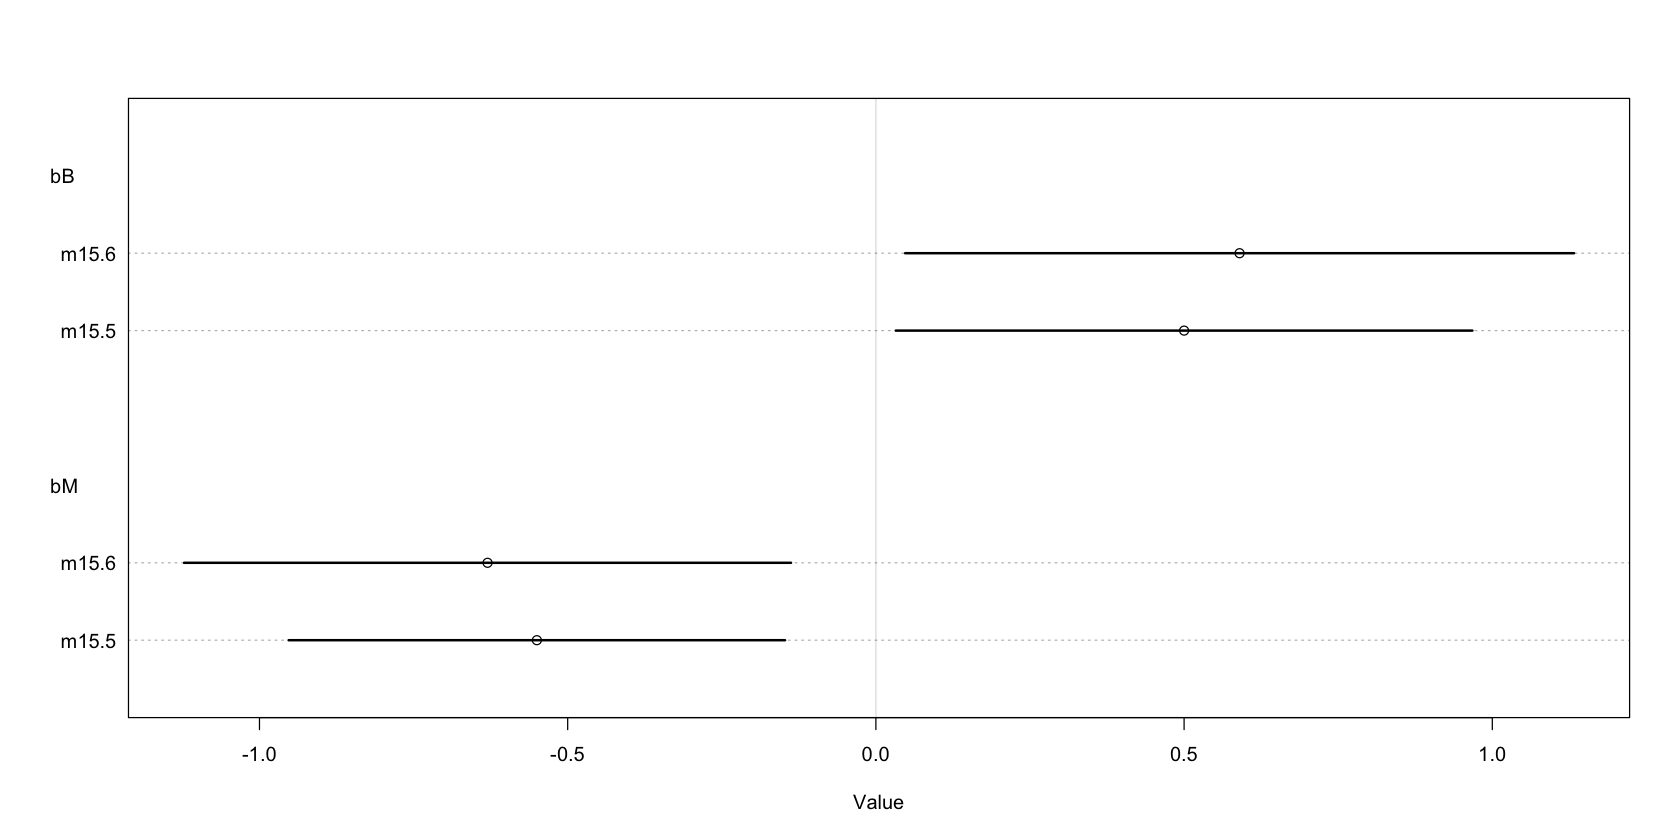

In [32]:
par(bg = 'white')
plot(coeftab(m15.5, m15.6), pars = c("bB", "bM"))

m15.5, the one with imputation, has a narrower distribution (is more certain) about both parameter estimates. Why? We have more data - by not throwing away all of the those 12 missing values, we also get to use the body mass and milk percent data, even though we have to introduce uncertainty about the neocortex percent.

We can improve this model by changing the imputation model to estimate the entire relationship between the two predictors - that is, we use the entire generative model. In the [[DAG]], $B$ and $M$ are related through $U$. If we include this unobserved variable, we might be able to make better imputations, and hence, make better predictions.

So, we're going to change the line

$$
B_i \sim \text{Normal}(\nu, \sigma_B)
$$

to a bivariate normal which includes both $M$ and $B$:

$$
M_i, B_i \sim \text{MVNormal}(( \mu_M, \mu_B ), \textbf{S})
$$

The matrix $\textbf{S}$ is a covariance matrix between $M$ and $B$, which allows us to use the covariance between those two to help us impute the missing values.

The `ulam` model is more complicated now, because we have to construct a variable which includes both the observed and unobserved values.

In [33]:
m15.7 <- ulam(
    alist(
        # K as a function of B and M
        K ~ dnorm(mu, sigma),
        mu <- a + bB * B_merge + bM * M,

        # M and B correlation
        MB ~ multi_normal(c(muM, muB), Rho_BM, Sigma_BM),
        matrix[29,2]:MB <<- append_col(M, B_merge),

        # define B_merge as a mix of observed and imputed values
        vector[29]:B_merge <- merge_missing(B, B_impute),

        # priors
        c(a, muM, muB) ~ dnorm(0, 0.5),
        c(bB, bM) ~ dnorm(0, 0.5),
        sigma ~ dexp(1),
        Rho_BM ~ lkj_corr(2),
        Sigma_BM ~ dexp(1)
    ),
    data = data_list,
    chains = 4,
    cores = 4
)
precis(m15.7, depth = 3)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32401f840782.stan', line 36, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32401f840782.stan', line 36, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32401f840782.stan', line 36, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable t

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32401f840782.stan', line 36, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32401f840782.stan', line 36, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable t

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32401f840782.stan', line 36, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32401f840782.stan', line 36, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable t

Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 400 / 1

mean         sd        5.5%        94.5%      rhat      ess_bulk 
muB          -0.049867886 0.1842053 -0.34041104  0.2454014 1.0016607 1864.0522
muM           0.001740307 0.1744704 -0.27306931  0.2774264 1.0015952 2342.3354
a             0.033657416 0.1640771 -0.23523179  0.2936468 1.0009896 2875.7879
bM           -0.636966920 0.2170533 -0.98011319 -0.2866520 1.0002201 1193.9946
bB            0.564695037 0.2568756  0.14944928  0.9673903 1.0012450  968.9015
sigma         0.834980374 0.1409154  0.63828523  1.0786707 1.0020399 1430.6925
Rho_BM[1,1]   1.000000000 0.0000000  1.00000000  1.0000000        NA        NA
Rho_BM[2,1]   0.610533166 0.1298522  0.38979946  0.7928994 0.9994500 1667.2226
Rho_BM[1,2]   0.610533166 0.1298522  0.38979946  0.7928994 0.9994500 1667.2226
Rho_BM[2,2]   1.000000000 0.0000000  1.00000000  1.0000000        NA        NA
Sigma_BM[1]   1.008962949 0.1352155  0.81522303  1.2390556 1.0006456 2416.4474
Sigma_BM[2]   0.946663344 0.1499618  0.74064967  1.2031937 1.0019780 1443.6988
B_impute[1]  -0.617648265 0.7213437 -1.79929240  0.5058020 1.0038092 2812.9280
B_impute[2]  -0.634756649 0.6907771 -1.73148930  0.4780104 1.0025851 2836.6357
B_impute[3]  -0.757461616 0.6869428 -1.82540230  0.3229633 1.0012604 2254.1162
B_impute[4]  -0.402377666 0.6801766 -1.46386460  0.6830685 0.9999496 3230.0317
B_impute[5]  -0.217424588 0.7147338 -1.34119915  0.9456616 1.0011874 2385.9170
B_impute[6]  -0.700370426 0.6840700 -1.77995320  0.3669666 1.0021016 2463.3523
B_impute[7]   0.049705186 0.6358146 -0.94774037  1.0608636 1.0008802 3054.7423
B_impute[8]   0.298297423 0.6855233 -0.79416820  1.4169114 0.9999001 2221.9723
B_impute[9]   0.506106822 0.6896608 -0.59069882  1.6213671 1.0013665 2512.8163
B_impute[10] -0.150875188 0.7036654 -1.30165660  0.9601608 1.0029806 2967.2145
B_impute[11]  0.071090809 0.6922913 -1.04332800  1.1395903 1.0016615 2291.2895
B_impute[12]  0.995586586 0.6841619 -0.07941456  2.1050053 1.0006221 2471.3722

The slopes haven't really changed much. There is now a strong correlation (about 0.6) between the M and B variables, which we already knew. What this means is that the imputed variables now have a slope which is similar to that of the data as a whole.

---
Overthinking: Stan imputation algorithm

In principle, imputation is using the same model but replacing data with parameters. To do this we need to construct a new variable which is a mix of observed and unobserved values.


```stan
functions {
    vector merge_missing(int[] miss_indexes, vector x_obs, vector x_miss) {
        int N = dims(x_obs)[1];
        int N_miss = dims(x_miss)[1];
        vector[N] merged;
        merged = x_obs;
        for (i in 1:N_miss) {
            merged[miss_indexes[i]] = x_miss[i];
        }
        return merged;
    }
}
```

In the model block, we call it like
```stan
B_merge = merge_missing(B_missidx, to_vector(B), B_imput);
B_merge ~ normal(nu, sigma_B);
for (i in 1:29) {
    mu[i] = a + bB * B_merge[i] + bM * M[i];
}
K ~ normal(mu, sigma);
```

`ulam` will build the index of missing values automatically, but if you're using [[Stan]] directly then you will need to build it yourself:

```R
B_missidx <- which(is.na(data_list$B))
```
---

### Where is your god now?

Sometimes people are curious about the effect of religion on society. Some religions have moralizing gods which enforce social norms. Others have no interest in doing that. If your religion has a moralizing god, does that make you better at cooperating?

In [34]:
data(Moralizing_gods)
str(Moralizing_gods)

'data.frame':	864 obs. of  5 variables:
 $ polity         : Factor w/ 30 levels "Big Island Hawaii",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year           : int  1000 1100 1200 1300 1400 1500 1600 1700 1800 -600 ...
 $ population     : num  3.73 3.73 3.6 4.03 4.31 ...
 $ moralizing_gods: int  NA NA NA NA NA NA NA NA 1 NA ...
 $ writing        : int  0 0 0 0 0 0 0 0 0 0 ...


Does belief in a moralizing god increase the rate of population growth? It's a tough question - there are a tonne of unobserved confounding variables here. Even if there is an effect, it could happen only over long time periods or during times of stress or chaos. At minimum, we want a comparison of population growth rates before and after adopting moralizing gods. We really can't think of the appearance of moralizing gods as being a random treatment in the sense of a [[Regression Discontinuity]] (See [[Chapter 14]]).

With all that being said, let's see how we can try anyway.

In [35]:
table(Moralizing_gods$moralizing_gods, useNA = 'always')


   0    1 <NA> 
  17  319  528 

There's a lot of missing data! But remember the dogs eating homework example - if the missing values are random then it won't affect the prediction (except by lowering the sample size).

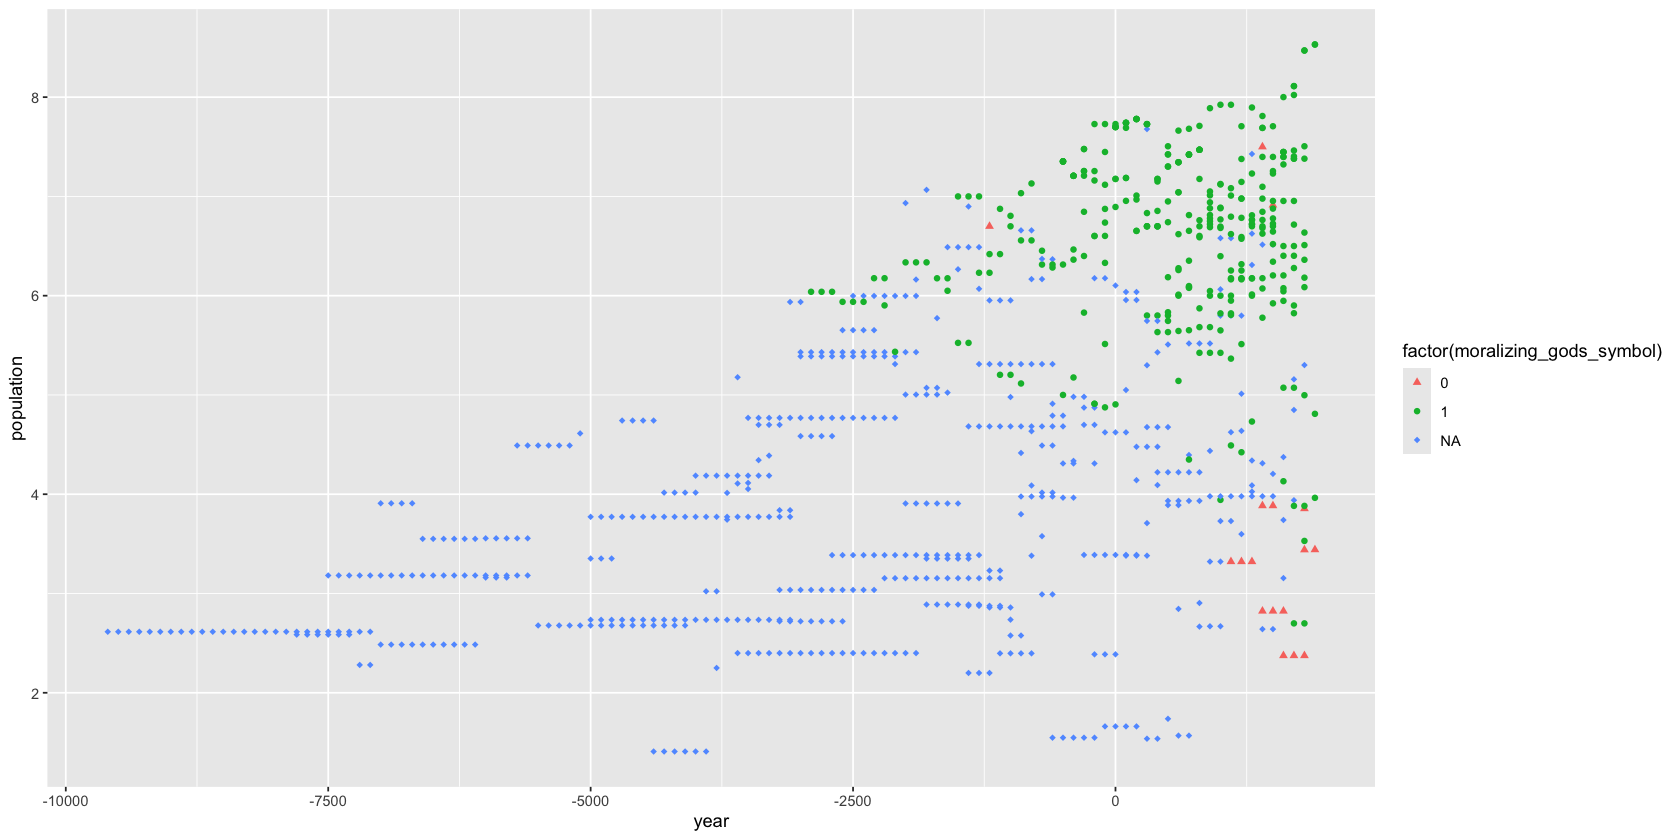

In [36]:
Moralizing_gods$moralizing_gods_symbol <- as.character(Moralizing_gods$moralizing_gods)
Moralizing_gods$moralizing_gods_symbol[is.na(Moralizing_gods$moralizing_gods_symbol)] <- "NA"

ggplot(Moralizing_gods, aes(year, population)) +
    geom_point(aes(shape = factor(moralizing_gods_symbol), colour = factor(moralizing_gods_symbol))) +
    scale_shape_manual(values = c("1" = 16, "0" = 17, "NA" = 18))

This doesn't look like a random pattern at all! Earlier societies are far more likely to have missing data. This is perhaps unsurprising - we need writing to be able to determine if they had moralizing gods.

Now let's take a look at the relationship between literacy and moralizing gods.

In [37]:
with(Moralizing_gods, table(gods=moralizing_gods, literacy=writing, useNA = 'always'))

      literacy
gods     0   1 <NA>
  0     16   1    0
  1      9 310    0
  <NA> 442  86    0

Most of the missing values are for non-literate societies. Also, smaller polities are more likely to have missing values, largely because they were more likely to be pre-literate. There is a strong associating between literacy, moralizing gods, and missing values.

In this case, statistics can't save us. Let's see why!

We can't just use [[Complete Case Analysis]]. Here's a guess as to the causal structure:

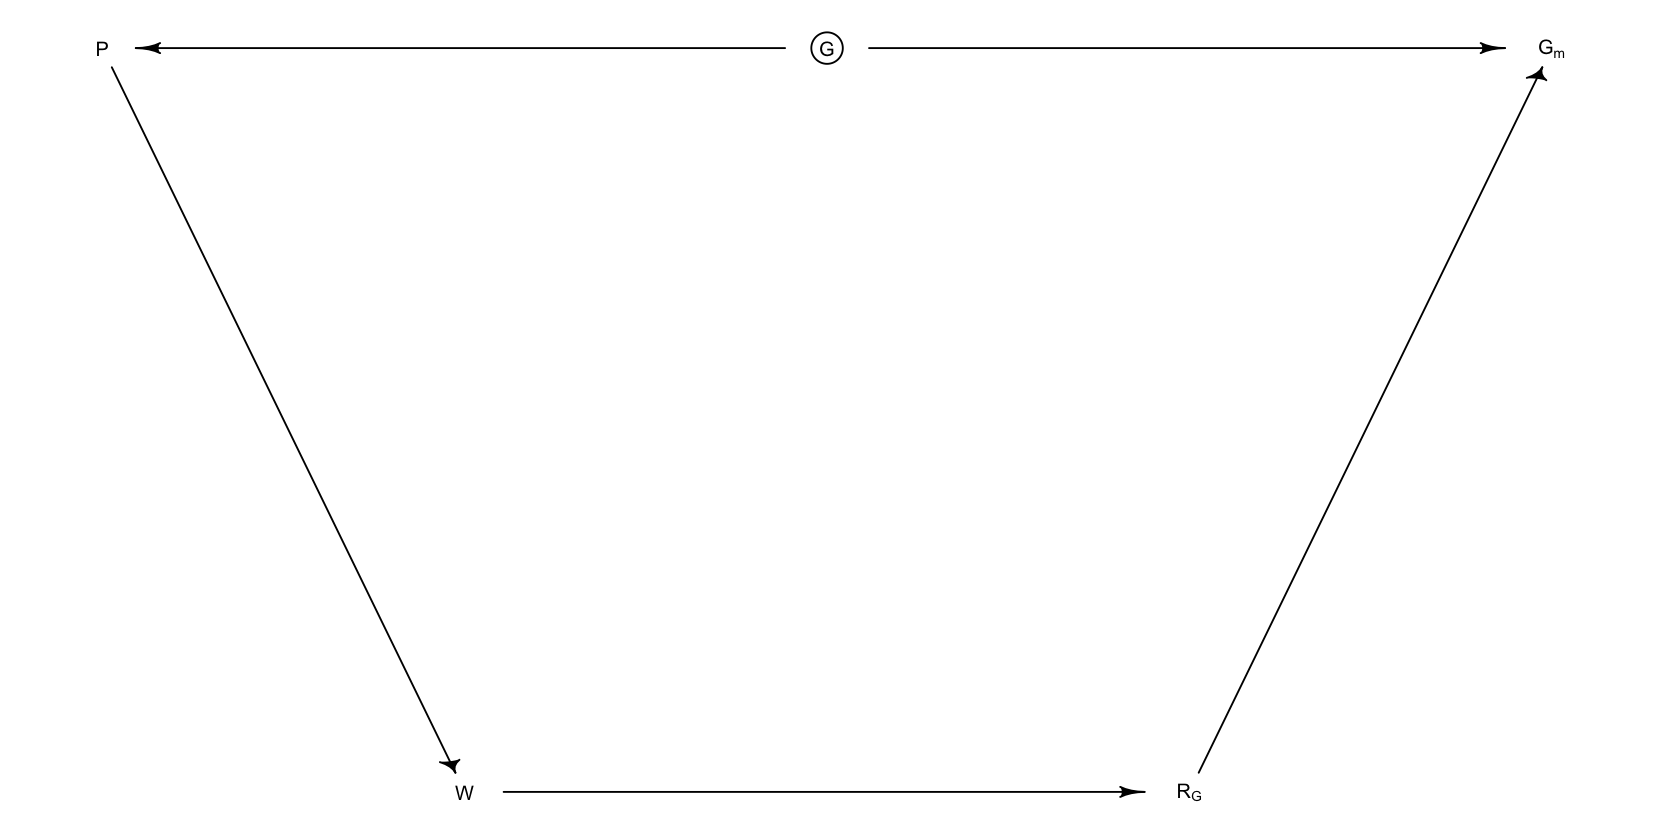

In [38]:
par(bg = 'white')
dag <- dagitty( 'dag {
P[pos="0,0"]
G[latent, pos="2,0"]
G_m[pos="4,0"]
R_G[pos="3,1"]
W[pos="1,1"]
G -> G_m <- R_G <- W <- P <- G
}' )
drawdag(dag)


Here 
- $P$ is the rate of population *growth* (not the same as the population variable).
- G is the belief in moralizing gods (unobserved)
- $G_m$ is the observed variable with missing values
- $W$ is the presence of writing
- $R_G$ is the missing values indicator.

This is optimistic because it assumes that there are no unovserved confounds among the variables, which seems unlikely. We're going to examine this because if we can't recover the missing data using this [[DAG]], we certainly won't be able to if there are confounds!

Because the missingness is informed by W (and therefore by P), we can't condition on it; it would be like conditioning on the outcome.

There is still hope if we are willing to make strong assumptions. If we could condition on $G$ instead of $G_m$, we'd be in the clear.In principle we could use imputation. However, this would require a good approximation of the generative model. How exactly is $G$ generated? It's unclear.

For instance: Hawai'i. By 1778, Hawai'i was a large and complex polity with moralizing gods. What happened in 1778? James Cook and crew made contact.

In [39]:
haw <- which(Moralizing_gods$polity == "Big Island Hawaii")
columns <- c("year", 'writing', 'moralizing_gods')
t(Moralizing_gods[haw, columns])

1    2    3    4    5    6    7    8    9   
year            1000 1100 1200 1300 1400 1500 1600 1700 1800
writing            0    0    0    0    0    0    0    0    0
moralizing_gods   NA   NA   NA   NA   NA   NA   NA   NA    1

After Captain Cook arrived, it is coded as having moralizing gods. Since they never developed writing, there is no direct evidence for when they developed moralizing gods. Any imputation model would have to make some pretty strong assumptions considering how much missing data there is.

The strongest assumption would be to just hard-code in a constant, like 0. This would be the assumption that if you believe in moralizing gods, you never produce a missing value. In Hawai'i's case, this would mean that we believe that moralizing gods appeared only after James Cook. This might seem like a crazy approach, but is relatively common.

In principle we could perform a model-based imputation of the missing values in `moralizing_gods`. However, we don't have any clearly correct way to do this. We can't just lean on the association between population size / growth rate and moralizing gods because that's the exact question we're investigating!

Sometimes statistics just tells us that we need more data.

Also, there's another obstacle: the moralizing gods variable is discrete (only 0 or 1). Whether imputing or dealing with measurement error, discrete variables are trickier than continuous ones.

## Categorical errors and discrete absences

Accounting for measurement error and missing data is relatively easy when the data is continuous - you replace the value with a distribution. However, when the data are discrete it's much trickier.

Two issues: 
1. Discrete variables don't produce a smooth surface for [[Hamiltonian Monte Carlo]]
2. Even other estimation techniques struggle with the discontinuities introduced by discrete variables.

We can avoid this by using a 'weighted average' to remove discrete parameters from the model. After sampling the other parameters, we can then use their samples to compute the posterior distribution of any discrete parameters that we removed.

### 15.3.1

Imagine a neighbourhood where every house contains a songbird. We survey the neighbourhood and sample one minute of song from each house, recording the number of notes. Some houses also have house cats, and so you weonder if the presence of a cat changes the amount that each bird sings. You now need to see which houses have cats. In some cases you can tell easily, but in about 20% of the cases you can't determine whether or not a cat lives there.

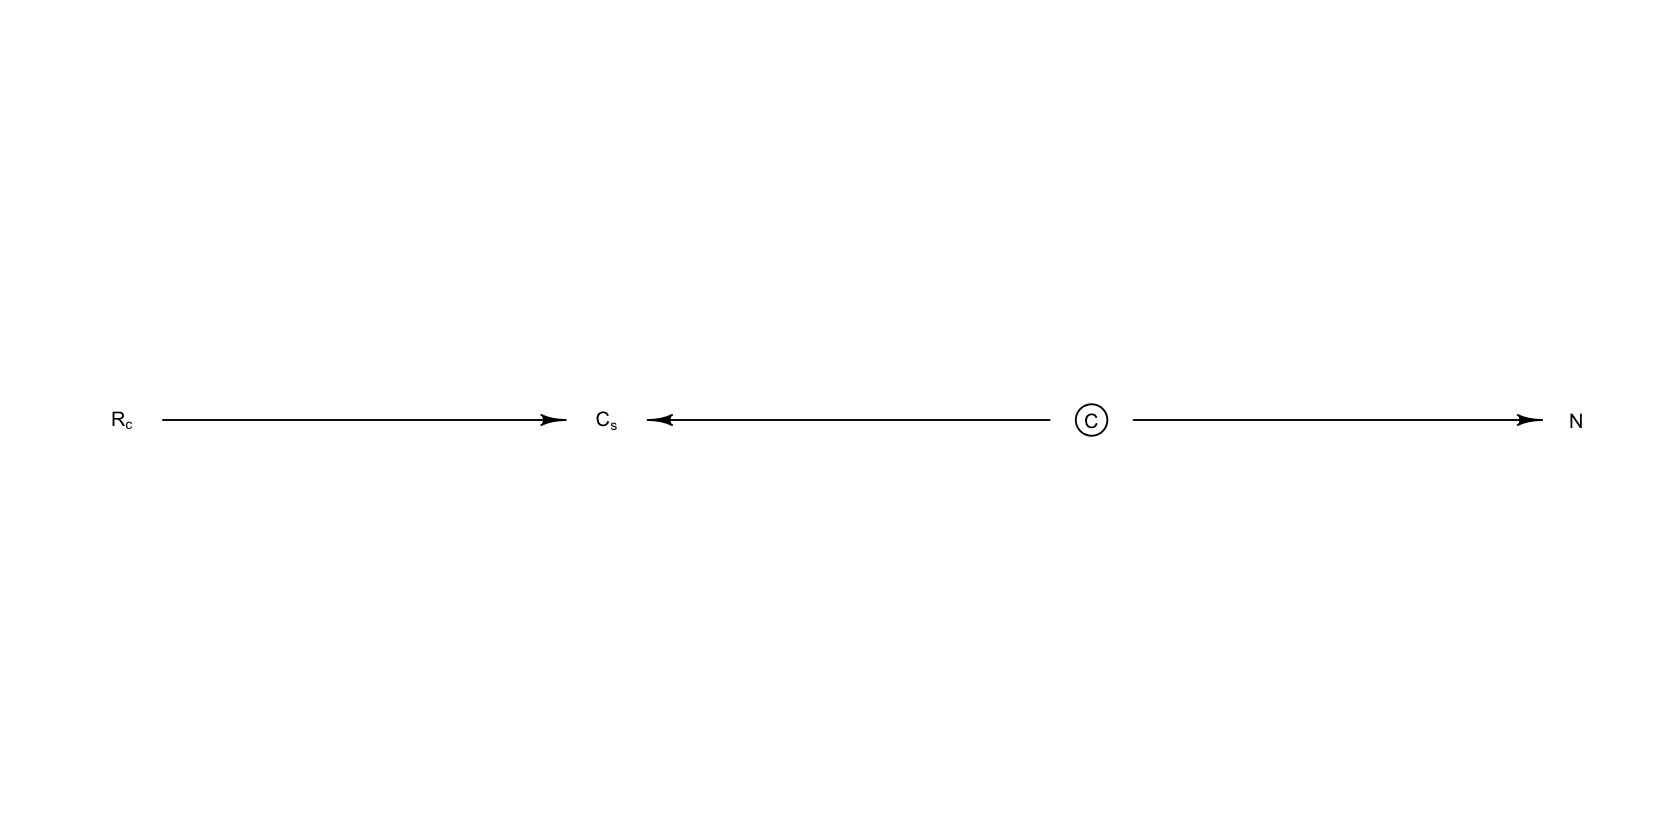

In [40]:
par(bg = 'white')
dag <- dagitty( 'dag {
R_c[pos="0,0"]
C_s[pos="1,0"]
C[latent,pos="2,0"]
N[pos="3,0"]
R_c -> C_s <- C -> N
}' )
drawdag(dag)

The presence / absence of a cat, $C$, influences the number of notes sung, $N$. Because of missings values $R_c$, we only observe $C_s$. A possible model for the above might look like

$$
\begin{align*}
N_i &\sim \text{Poisson}(\lambda_i) & [\text{Probability of notes sung}] \\
\log \lambda_i &= \alpha + \beta C_i & [\text{Rate of notes as a function of cat}] \\
C_i &\sim \text{Bernoulli}(k) & [\text{Probability cat is present}]\\
R_{C, i} &\sim \text{Bernoulli}(r) & [\text{Probability of not knowing $C_i$}] \\
\end{align*}
$$

In [41]:
set.seed(9)

N_houses <- 100L
alpha <- 5
beta <- -3
k <- 0.5
r <- 0.2
cat <- rbern(N_houses, k)
notes <- rpois(N_houses, alpha + beta * cat)
R_C <- rbern(N_houses, r)
cat_obs <- cat
cat_obs[R_C == 1] <- -9L # arbitrary value
dat <- list(
    notes = notes,
    cat = cat_obs,
    R_C = R_C,
    N = as.integer(N_houses)
)

We've replaced each unknown values of `cat_obs` with -9 arbitrarily; this is just a marker used to indicate missing data. It's good to use invalid data; in this case if we forget to remove / deal with these missing values, then since `cat` is Bernoulli distributed it will result in an error if we try to find the likelihood of -9 appearing.

To program the model, we can't just declare a parameter for each unobserved cat. Instead, we'll average over our uncertainty in whether a cat was there or not. More precisely, the likelihood of observing $N_i$ notes, unconditional on $C_i$, is

$$
\begin{align*}
P(N_i) &= (\text{probability of cat}) * (\text{probability of $N_i$ when there is a cat}) + (\text{probability of no cat}) * (\text{probability of $N_i$ when there is no cat}) \\
&= P(C_i = 1) P(N_i | C_i = 1) + P(C_i = 0) P(N_i | C_i = 0)
\end{align*}
$$

When we don't know $C_i$, we can compute the likelihood for $N_i$ for each possible value of $C_i$ - here 1 or 0 - then average these likelihoods using the probability that $C_i$ takes on each of these values. Now we need to code it into the model.

In [42]:
m15.8 <- ulam(
    alist(
        # singing bird model
        # cat known present / absent
        notes|R_C == 0 ~ poisson(lambda),
        log(lambda) <- a + b * cat,
        # cat NA
        notes|R_C==1 ~ custom(log_sum_exp(
            log(k) + poisson_lpmf(notes | exp(a + b)),
            log(1 - k) + poisson_lpmf(notes | exp(a))
        )),

        # priors
        a ~ normal(0, 1),
        b ~ normal(0, 0.5),

        # sneaking cat model
        cat|R_C == 0 ~ bernoulli(k),
        k ~ beta(2, 2)
    ),
    data = dat,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

The first line, `notes|R_C == 0`, is the probability of $N$ when R_C is 0; it's just the regular probability.

The next one is trickier. That's the probability of the notes when we don't observe the cat (missing data).

```R
notes|R_C==1 ~ custom(log_sum_exp(
            log(k) + poisson_lpmf(notes | exp(a + b)),
            log(1 - k) + poisson_lpmf(notes | exp(a))
        ))
```

This is the previous expression on the log scale. The term `log(k) + poisson_lpmf(notes | exp(a + b))` is $\log [ P(C_i = 1) P(N_i | C_i = 1)]$ and `log(1 - k) + poisson_lpmf(notes | exp(a))` is $\log [P(C_i = 0) P(N_i | C_i = 0)]$

The function `log_sum_exp` is a helper function which takes a bunch of log probabilities, exponentiates them, sums them, and the returns the log of the result (but in a numerically stable way).

The model for the missing data is at the bottom, `cat|R_C == 0 ~ bernoulli(k)`. This is indicating that the cat is missing at random.

Now we want to go back and calculate the probability that a cat was present at a house, after we've observed the number of notes sung. According to the model, what we want is $P(C_i = 1) = k$. If we have $N_i$, the number of notes sung, then we can use Bayes' Rule:

$$
P(C_i = 1 | N_i) = \frac{P(N_i | C_i = 1)P(C_1 = 1)}{P(N_i | C_i = 1)P(C_i = 1) + P(N_i | C_i = 0)P(C_i = 0)}
$$

To generate this quantity, we can use [[Stan]]'s **Generated Quantities** block. In `ulam`, we prefix a line with `gq>`.

In [43]:
m15.9 <- ulam(
    alist(
        # singing bird model
        # cat known present / absent
        notes|R_C == 0 ~ poisson(lambda),
        notes|R_C==1 ~ custom(log_sum_exp(
            log(k) + poisson_lpmf(notes | exp(a + b)),
            log(1 - k) + poisson_lpmf(notes | exp(a))
        )),
        log(lambda) <- a + b * cat,
        # cat NA

        # priors
        a ~ normal(0, 1),
        b ~ normal(0, 0.5),

        # sneaking cat model
        cat|R_C == 0 ~ bernoulli(k),
        k ~ beta(2, 2),

        # generated quantities
        gq> vector[N]:PrC1 <- exp(lpC1) / (exp(lpC1) + exp(lpC0)),
        gq> vector[N]:lpC1 <- log(k) + poisson_lpmf(notes[i] | exp(a + b)),
        gq> vector[N]:lpC0 <- log(1 - k) + poisson_lpmf(notes[i] | exp(a))
    ),
    data = dat,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 

In [44]:
precis(m15.9, depth = 2)

mean        sd          5.5%        94.5%      rhat      ess_bulk
a          1.6088882  0.06077754   1.5098078   1.7059633 0.9995016 1366.031
b         -0.7979828  0.11223719  -0.9765689  -0.6201138 1.0012675 1329.581
k          0.4614412  0.05621698   0.3711866   0.5524813 1.0011445 1577.764
lpC0[1]   -3.9527522  0.25588072  -4.3763616  -3.5639483 1.0029328 1328.587
lpC0[2]   -2.5568405  0.11813096  -2.7520357  -2.3855423 1.0023915 1491.507
lpC0[3]   -2.3734197  0.12863629  -2.5884336  -2.1745800 0.9996213 1547.906
lpC0[4]   -2.5960134  0.17007427  -2.8869408  -2.3381619 1.0003384 1490.919
lpC0[5]   -2.5960134  0.17007427  -2.8869408  -2.3381619 1.0003384 1490.919
lpC0[6]   -2.5568405  0.11813096  -2.7520357  -2.3855423 1.0023915 1491.507
lpC0[7]   -2.3739694  0.10750438  -2.5532747  -2.2154198 1.0015072 1544.069
lpC0[8]   -2.3734197  0.12863629  -2.5884336  -2.1745800 0.9996213 1547.906
lpC0[9]   -3.1062895  0.22066034  -3.4720563  -2.7689689 0.9999045 1456.373
lpC0[10]  -4.0220304  0.27539892  -4.4803104  -3.5996287 0.9992075 1436.173
lpC0[11]  -2.5960134  0.17007427  -2.8869408  -2.3381619 1.0003384 1490.919
lpC0[12]  -2.3734197  0.12863629  -2.5884336  -2.1745800 0.9996213 1547.906
lpC0[13]  -3.1062895  0.22066034  -3.4720563  -2.7689689 0.9999045 1456.373
lpC0[14]  -2.3739694  0.10750438  -2.5532747  -2.2154198 1.0015072 1544.069
lpC0[15]  -2.5568405  0.11813096  -2.7520357  -2.3855423 1.0023915 1491.507
lpC0[16]  -4.0220304  0.27539892  -4.4803104  -3.5996287 0.9992075 1436.173
lpC0[17]  -5.4354560  0.36981175  -6.0481660  -4.8676429 1.0017215 1331.039
lpC0[18]  -5.6309187  0.33224377  -6.1844224  -5.1220914 0.9991469 1421.274
lpC0[19]  -3.3644156  0.20227154  -3.6998726  -3.0660196 1.0024406 1317.183
lpC0[20]  -2.5960134  0.17007427  -2.8869408  -2.3381619 1.0003384 1490.919
lpC0[21]  -3.1062895  0.22066034  -3.4720563  -2.7689689 0.9999045 1456.373
lpC0[22]  -2.8938624  0.15407939  -3.1473353  -2.6666213 1.0024899 1335.708
lpC0[23]  -3.1062895  0.22066034  -3.4720563  -2.7689689 0.9999045 1456.373
lpC0[24]  -3.3644156  0.20227154  -3.6998726  -3.0660196 1.0024406 1317.183
lpC0[25]  -2.5960134  0.17007427  -2.8869408  -2.3381619 1.0003384 1490.919
lpC0[26]  -3.1062895  0.22066034  -3.4720563  -2.7689689 0.9999045 1456.373
lpC0[27]  -2.5568405  0.11813096  -2.7520357  -2.3855423 1.0023915 1491.507
⋮         ⋮           ⋮           ⋮           ⋮          ⋮         ⋮       
PrC1[71]  0.204317957 0.059629325 0.118971975 0.30699912 1.0014989 1654.628
PrC1[72]  0.357048831 0.070966480 0.247628050 0.47256187 1.0007908 1659.687
PrC1[73]  0.547760258 0.070520660 0.434100570 0.65974260 0.9997036 1642.343
PrC1[74]  0.725667923 0.059819690 0.623185345 0.81659579 0.9998290 1506.219
PrC1[75]  0.547760258 0.070520660 0.434100570 0.65974260 0.9997036 1642.343
PrC1[76]  0.547760258 0.070520660 0.434100570 0.65974260 0.9997036 1642.343
PrC1[77]  0.924909741 0.030446418 0.868147600 0.96417507 1.0014663 1389.964
PrC1[78]  0.204317957 0.059629325 0.118971975 0.30699912 1.0014989 1654.628
PrC1[79]  0.547760258 0.070520660 0.434100570 0.65974260 0.9997036 1642.343
PrC1[80]  0.357048831 0.070966480 0.247628050 0.47256187 1.0007908 1659.687
PrC1[81]  0.357048831 0.070966480 0.247628050 0.47256187 1.0007908 1659.687
PrC1[82]  0.204317957 0.059629325 0.118971975 0.30699912 1.0014989 1654.628
PrC1[83]  0.547760258 0.070520660 0.434100570 0.65974260 0.9997036 1642.343
PrC1[84]  0.725667923 0.059819690 0.623185345 0.81659579 0.9998290 1506.219
PrC1[85]  0.547760258 0.070520660 0.434100570 0.65974260 0.9997036 1642.343
PrC1[86]  0.006452691 0.006495851 0.001169335 0.01697424 1.0018826 1453.368
PrC1[87]  0.547760258 0.070520660 0.434100570 0.65974260 0.9997036 1642.343
PrC1[88]  0.204317957 0.059629325 0.118971975 0.30699912 1.0014989 1654.628
PrC1[89]  0.851614539 0.044853860 0.770645540 0.91501225 0.9999195 1421.374
PrC1[90]  0.851614539 0.044853860 0.770645540 0.91501225 0.9999195 1421.374
PrC1[91]  0.357048831 0.070966480 0.247628050 0.47256187 1

Those three lines with `gq>` are perfrming the calculation for $P(C_i=1|N_i)$. We can get those samples in the usual way, even though they're in the generated quantities block instead of the model.

This same approach generalizes to more than two options. For instance, if there were either 0, 1, or 2 cats in each house, then the expression would be

```R
notes | R_C == 1 ~ custom( log_sum_exp(
    binomial_lpmf(2|2,k) + poisson_lpmf(notes | exp( a + b * 2)),
    binomial_lpmf(1|2,k) + poisson_lpmf(notes | exp( a + b * 1)),
    binomial_lpmf(0|2,k) + poisson_lpmf(notes | exp( a + b * 0)),
))
```

Each line is the probability of a specific number of cats, assuming that cats are binomially distributed with a maximum 2 and probability k, plus the log probability of a certain number of notes, assuming that specific number of cats. 

Unordered probabilities work the same way, but now the leading term would be from some simplex of probabilities.

The same approach works when you have more than one missing variable. For instance, say that the houses may also contain a dog ($D_i$). Now we have four possible states: 
1. cat and dog
1. cat, no dog
1. no cat, dog
1. no cat, no dog

For some fraction of houses, we are unable to learn whether they have a dog. Now both the cat and dog variable may be NA. If both are NA, then we have to average over the four possibilities:

$$
\begin{align*}
P(N_i) &= P(C_i = 1)P(D_i = 1)P(N_i | C_i = 1, D_i = 1) \\
    &+ P(C_i = 0) P(D_i = 1) P(N_i | C_i = 0, D_i = 1) \\
    &+ P(C_i = 1) P(D_i = 0) P(N_i | C_i = 1, D_i = 0) \\
    &+ P(C_i = 0) P(D_i = 0) P(N_i | C_i = 0, D_i = 0)
\end{align*}
$$

If the cat is NA and the dog is known present, then we only have to average over the first and third probabilities.

$$
P(N_i) = P(C_i = 1)P(N_i | C_i = 1, D_i = 1) + P(C_i = 0) P(N_i | C_i = 0, D_i = 1)
$$

conversely, if only the dog is NA and the cat is known absent, then we have

$$
P(N_i) = P(D_i = 1)P(N_i | D_i = 1, C_i = 0) + P(D_i = 0) P(N_i | D_i = 0, C_i = 1)
$$

In principle this isn't hard, but it does produce very complicated code; you have to account for each case and write a special probability statement for each.

This general technique will also occur in [[Chapter 16]] where we'll encounter a [[State Space Model]]. These models can have a large number of discrete or continuous unobserved variables. Typically we don't write out each possibility in the code, but instead an algorithm to work over the different possibilities and compute the necessary average likelihoods. For example, in a [[Hidden Markov Model]], an algorithm known as the [[Forward Algorithm]] is used to do the averaging.

### Discrete error

The example above concerned missing data, but if the data are instead measured with error the process is very similar. For instance, say that we assign each house a probability of a cat being present, $k_i$. When the cat is present we have $k_i = 1$, when we're sure it's absent we have $k_i = 0$, and if it's a coin flip we have $k_i = 0.5$ These $k_i$ values would then replace the single parameter $k$ in the model, becoming the weights that we use to average over our uncertainty.

## Practice

**15E1** Rewrite the Oceanic tools model (from [[Chapter 11]]) below so that it assumes measured error in the log population sizes of each society. Don't fit the model to data, just rewrite the model.

$$
\begin{align*}
T_i &\sim \text{Poisson}(\mu_i) \\
\log \mu_i &= \alpha + \beta \log P_i \\
\alpha &\sim \text{Normal}(0, 1.5)\\
\beta &\sim \text{Normal}(0, 1)\\
\end{align*}
$$

**Answer**

What we have are the observed values, $P_i$. If we assume that the population is measured with error, then we actually want the values to be based on the true population values, $P_i^*$. Since they're measured with error, we have that $P_i \sim \text{Normal}(P_i^*, \sigma_P)$ (assuming the same standard deviation for each population). Then

$$
\begin{align*}
T_i &\sim \text{Poisson}(\mu_i) \\
\log \mu_i &= \alpha + \beta \log P_i^* \\
P_i &\sim \text{Normal}(P_i^*, \sigma_P) \\
\sigma_P &\sim \text{Exponential}(1) \\
\alpha &\sim \text{Normal}(0, 1.5)\\
\beta &\sim \text{Normal}(0, 1)\\
\end{align*}
$$

**15E2** Rewrite the same model so that it allows imputation of missing values for log population. There aren't any missing values in the variable, but you can still write down a model formula that would imply imputation, if any values were missing.

**Answer**
$$
\begin{align*}
T_i &\sim \text{Poisson}(\mu_i) \\
\log \mu_i &= \alpha + \beta P^*_i \\
P^* &\sim \text{Normal}(\mu_{ p, i }, \sigma_p) \\
\mu_{p, i} &\sim \text{Normal}(\log P_i, 1)\\
\alpha &\sim \text{Normal}(0, 1.5)\\
\beta &\sim \text{Normal}(0, 1)\\
\end{align*}
$$

Basically, we're putting adaptive priors on $P^*$ - if the value is there then this is a likelihood, and if it's missing (needs to be imputed) then it's a prior.

**15M1** Using the mathematical form of the imputation model in the chapter, explain what is being assumed about how the missing values were generated.

**Answer** I'm guessing that the one that they're talking about is 

$$
\begin{align*}
K_i &\sim \text{Normal}(\mu_i, \sigma) & \text{[distribution for the outcome $k$]} \\
\mu_i &= \alpha + \beta_B B_i + \beta_M \log M_i & \text{[linear model]} \\
B_i &\sim \text{Normal}(\nu, \sigma_B) & \text{[distribution for obs / missing $B_i$]} \\
\alpha &\sim \text{Normal}(0, 0.5) \\
\beta_B &\sim \text{Normal}(0, 0.5) \\
\beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\nu &\sim \text{Normal}(0.5, 1) \\
\sigma_B &\sim \text{Exponential}(1)
\end{align*}
$$

In this case, since the missing values (contained in but not totally comprising, $B$) have a mean $\nu$ and variance $\sigma_B$ which do not depend on the other variables, it means that the missing variables get their values only from the existing values for $B$.

**15M2** Reconsider the primate milk missing data examples from the chapter. This time, assign $B$ a distribution that is properly bounded between zero and 1. A beta distribution, for example, is a good choice.

**Answer** The new mathematical model with $B$ having a beta distribution looks like
$$
\begin{align*}
K_i &\sim \text{Normal}(\mu_i, \sigma) & \text{[distribution for the outcome $k$]} \\
\mu_i &= \alpha + \beta_B B_i + \beta_M \log M_i & \text{[linear model]} \\
B_i &\sim \text{Beta}(\gamma, \delta) & \text{[distribution for obs / missing $B_i$]} \\
\gamma &\sim \text{Gamma}(1, 1) & [\text{Mean of $1 * 1 = 1$}]\\
\delta &\sim \text{Gamma}(1, 1) \\
\alpha &\sim \text{Normal}(0, 0.5) \\
\beta_B &\sim \text{Normal}(0, 0.5) \\
\beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\end{align*}
$$

In [45]:
data(milk)
d <- milk
d$neocortex.prop <- d$neocortex.perc / 100
d$logmass <- log(d$mass)

# data_list <- list(
#     K = standardize(d$kcal.per.g),
#     # B = standardize(d$neocortex.prop),
#     B = d$neocortex.prop, # if we want this to be a proportion, we don't want to standardized it (z-score)
#     M = standardize(d$logmass)
# )
data_list <- list(
    K = standardize(d$kcal.per.g),
    # B = standardize(d$neocortex.prop),
    B = d$neocortex.prop, # if we want this to be a proportion, we don't want to standardized it (z-score)
    M = standardize(d$logmass)
)
print(data_list)

m15m2.test.imputation <- ulam(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bB * B + bM * M,
        B ~ beta(alpha_param, beta_param),
        c(alpha_param, beta_param) ~ gamma(1.0, 1.0),
        c(a, nu) ~ dnorm(0, 0.5),
        c(bB, bM) ~ dnorm(0, 0.5),
        sigma_B ~ dexp(1),
        sigma ~ dexp(1)
    ),
    data = data_list,
    chains = 4,
    cores = 4,
    constraints = list(B = "lower=0, upper=1")  # Ensures B stays in [0,1]
)

d_complete <- d[complete.cases(d), ]
complete_data_list <- list(
    K = standardize(d_complete$kcal.per.g),
    # B = standardize(d$neocortex.prop),
    B = d_complete$neocortex.prop, # if we want this to be a proportion, we don't want to standardized it (z-score)
    M = standardize(d_complete$logmass)
)

m15m2.test.complete <- ulam(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bB * B + bM * M,
        B ~ beta(alpha_param, beta_param),
        c(alpha_param, beta_param) ~ gamma(1.0, 1.0),
        c(a, nu) ~ dnorm(0, 0.5),
        c(bB, bM) ~ dnorm(0, 0.5),
        sigma_B ~ dexp(1),
        sigma ~ dexp(1)
    ),
    data = complete_data_list,
    chains = 4,
    cores = 4,
    constraints = list(B = "lower=0, upper=1")  # Ensures B stays in [0,1]
)

$K
 [1] -0.9400408 -0.8161263 -1.1259125 -1.0019980 -0.2585112 -1.0639553
 [7] -0.5063402  1.5382486  1.6621631  1.7241203  0.9806335 -1.1259125
[13]  0.4230184  0.4230184  0.5469328  0.2371467  0.4849756  2.0339065
[19]  0.9186762  1.2284624 -1.0019980 -0.1345968 -0.8161263 -0.6302546
[25] -0.9400408 -0.6922119 -1.0019980 -0.5682974  0.4230184
attr(,"scaled:center")
[1] 0.6417241
attr(,"scaled:scale")
[1] 0.1614016

$B
 [1] 0.5516     NA     NA     NA     NA 0.6454 0.6454 0.6764     NA 0.6885
[11] 0.5885 0.6169 0.6032     NA     NA 0.6997     NA 0.7041     NA 0.7340
[21]     NA 0.6753     NA 0.7126 0.7260     NA 0.7024 0.7630 0.7549

$M
 [1] -0.4558357 -0.4150024 -0.3071581 -0.5650254 -0.3874772  0.1274408
 [7]  0.1407505 -0.3071581 -1.0508443 -1.0762697 -2.0978301 -1.2937974
[13] -1.5201893 -1.1499822 -0.1164199 -0.5910392  0.3035582 -0.1568095
[19]  0.3710728  0.6288397  0.3445228  0.1407505  0.5478687  1.2527355
[25]  1.7273591  1.8494033  1.3341500  1.2120204  1.5103660
attr(,"sca

Found 12 NA values in B and attempting imputation.

Warning in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404196321.stan', line 40, column 25: Found
    int division:
      1 / 1
    Values will be rounded towards zero. If rounding is not desired you can
    write
    the division as
      1.0 / 1
    If rounding is intended please use the integer division operator %/%.
Warning in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404196321.stan', line 40, column 31: Found
    int division:
      1 / 1
    Values will be rounded towards zero. If rounding is not desired you can
    write
    the division as
      1.0 / 1
    If rounding is intended please use the integer division operator %/%.
Warning in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404196321.stan', line 41, column 24: Found
    int division:
      1 / 1
    Values will be rounded towards zero. If rounding is not desired you can
    write
    the divisio

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...



Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: beta_lpdf: Random variable[3] is -1.91913, but must be in the interval [0, 1] (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404196321.stan', line 43, column 4 to column 47)

Chain 1 Exception: beta_lpdf: Random variable[3] is -1.91913, but must be in the interval [0, 1] (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404196321.stan', line 43, column 4 to column 47)

Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: beta_lpdf: Random variable[3] is -0.848702, but must be in the interval [0, 1] (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32404196321.stan', line 43, column 4 to column 47)

Chain 1 Exception: beta_lpdf: Random variable[3] is -0.848702, but must be in the interval [0, 1] (in '/var/folders/86/1fgck35j5s9g

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32402c4705b1.stan', line 24, column 4 to column 37)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32402c4705b1.stan', line 30, column 4 to column 29)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-32402c4705b1.stan', line 24, column 4 to column 37)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 0.2 seconds.



OK, so it looks like there's a problem with imputation with a beta distribution. I may need to do this by hand. Resources:
- [Statistical Rethinking in STAN](https://vincentarelbundock.github.io/rethinking2/15.html)


In [46]:
stancode(m15m2.test.complete)

data{
     vector[17] K;
     vector[17] M;
     vector[17] B;
}
parameters{
     real<lower=0> beta_param;
     real<lower=0> alpha_param;
     real nu;
     real a;
     real bM;
     real bB;
     real<lower=0> sigma_B;
     real<lower=0> sigma;
}
model{
     vector[17] mu;
    sigma ~ exponential( 1 );
    sigma_B ~ exponential( 1 );
    bB ~ normal( 0 , 0.5 );
    bM ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 0.5 );
    nu ~ normal( 0 , 0.5 );
    alpha_param ~ gamma( 1/1 , 1/1 );
    beta_param ~ gamma( 1/1 , 1/1 );
    B ~ beta( alpha_param , beta_param );
    for ( i in 1:17 ) {
        mu[i] = a + bB * B[i] + bM * M[i];
    }
    K ~ normal( mu , sigma );
}



In [47]:
stancode(m15m2.test.imputation)

functions{


    vector merge_missing( array[] int miss_indexes , vector x_obs , vector x_miss ) {
        int N = dims(x_obs)[1];
        int N_miss = dims(x_miss)[1];
        vector[N] merged;
        merged = x_obs;
        for ( i in 1:N_miss )
            merged[ miss_indexes[i] ] = x_miss[i];
        return merged;
    }
}
data{
     vector[29] K;
     vector[29] M;
     vector[29] B;
    array[12] int B_missidx;
}
parameters{
     real<lower=0> beta_param;
     real<lower=0> alpha_param;
     real nu;
     real a;
     real bM;
     real bB;
     real<lower=0> sigma_B;
     real<lower=0> sigma;
     vector[12] B_impute;
}
model{
     vector[29] mu;
     vector[29] B_merge;
    sigma ~ exponential( 1 );
    sigma_B ~ exponential( 1 );
    bB ~ normal( 0 , 0.5 );
    bM ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 0.5 );
    nu ~ normal( 0 , 0.5 );
    alpha_param ~ gamma( 1/1 , 1/1 );
    beta_param ~ gamma( 1/1 , 1/1 );
    B_merge = merge_missing(B_missidx, to_vector(B), B_impute);

In [48]:
imputed_data <- c(data_list, list(N = nrow(d), N_miss = sum(is.na(d$neocortex.prop)), B_missidx = which(is.na(d$neocortex.prop))))
# STAN doesn't like it when variable values are NA, so we're going to set any missing ones to -1. It shouldn't make a difference, since we're going to impute them anyway.
imputed_data$B[is.na(imputed_data$B)] <- -1
stancode <- "functions{
    vector merge_missing(array[] int miss_indexes , vector x_obs , vector x_miss) {
        int N = dims(x_obs)[1];
        int N_miss = dims(x_miss)[1];
        vector[N] merged;
        merged = x_obs;
        for ( i in 1:N_miss )
            merged[ miss_indexes[i] ] = x_miss[i];
        return merged;
    }
}
data{
     int N; // number of observations
     int N_miss; // number of missing values
     vector[N] K;
     vector[N] M;
     vector[N] B;
    array[N_miss] int B_missidx;
}
parameters{
     real<lower=0> beta_param;
     real<lower=0> alpha_param;
     real nu;
     real a;
     real bM;
     real bB;
     real<lower=0> sigma_B;
     real<lower=0> sigma;
     vector<lower=0, upper=1>[N_miss] B_impute;
}
model{
    vector[N] mu;
    vector[N] B_merge;
    sigma ~ exponential( 1 );
    sigma_B ~ exponential( 1 );
    bB ~ normal( 0 , 0.5 );
    bM ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 0.5 );
    nu ~ normal( 0 , 0.5 );
    alpha_param ~ gamma(1.0, 1.0);
    beta_param ~ gamma(1.0, 1.0);
    B_impute ~ beta(1, 1);
    B_merge = merge_missing(B_missidx, to_vector(B), B_impute);
    B_merge ~ beta( alpha_param , beta_param );
    for ( i in 1:N ) {
        mu[i] = a + bB * B_merge[i] + bM * M[i];
    }
    K ~ normal( mu , sigma );
}
"
stancode_file <- write_stan_file(stancode)

model <- cmdstan_model(stancode_file)
fit <- model$sample(data = imputed_data, chains = 4, parallel_chains = 4)

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324076ee50c1.stan', line 40, column 4 to column 34)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 2 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 2 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 2 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Ch

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324076ee50c1.stan', line 40, column 4 to column 34)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 1 finished in 0.2 seconds.
Chain 2 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 finished in 0.2 seconds.
Chain 3 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.
Chain 4 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 finished in 0.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.2 seconds.
Total execution time: 0.2 seconds.



In [49]:
posterior <- as_draws_matrix(fit)
head(posterior)

lp__     beta_param alpha_param nu         a         bM         bB       
1 -24.3948 2.76544    4.60466      0.8956660 -0.163650 -0.0152937  0.343327
2 -21.3384 2.81059    5.30149      0.4757730 -0.432682 -0.4747310  0.411607
3 -24.2566 3.70111    8.66088      0.5359960 -0.188319 -0.2393150  0.483367
4 -24.3516 2.42957    3.85309     -0.5181060 -0.328965 -0.5455050  0.490310
5 -26.5059 2.68323    6.72605      0.0693677 -0.874985 -0.3206340  1.031910
6 -24.5405 5.92458    9.87532      0.2546180  0.331076 -0.3029100 -0.733127
  sigma_B  sigma    B_impute[1] ⋯ B_impute[3] B_impute[4] B_impute[5]
1 0.747969 0.888148 0.516067    ⋯ 0.548990    0.792935    0.304793   
2 0.308225 1.014890 0.669597    ⋯ 0.535254    0.660782    0.714172   
3 2.274700 1.178570 0.771080    ⋯ 0.875672    0.443240    0.734044   
4 0.324919 0.869730 0.479296    ⋯ 0.480713    0.917149    0.692206   
5 0.144991 0.932241 0.622190    ⋯ 0.669018    0.804864    0.557800   
6 3.534470 0.866355 0.728439    ⋯ 0.667816    0.642241    0.835996   
  B_impute[6] B_impute[7] B_impute[8] B_impute[9] B_impute[10] B_impute[11]
1 0.655246    0.901345    0.852681    0.746519    0.617328     0.637194    
2 0.796494    0.597494    0.877004    0.542701    0.896501     0.645634    
3 0.882480    0.836814    0.834769    0.695446    0.769329     0.500086    
4 0.376969    0.471039    0.460914    0.709871    0.467807     0.804246    
5 0.904338    0.861631    0.841662    0.775639    0.746079     0.390919    
6 0.467920    0.483509    0.511515    0.653781    0.624126     0.874156    
  B_impute[12]
1 0.666233    
2 0.810681    
3 0.674421    
4 0.601727    
5 0.904498    
6 0.432954

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


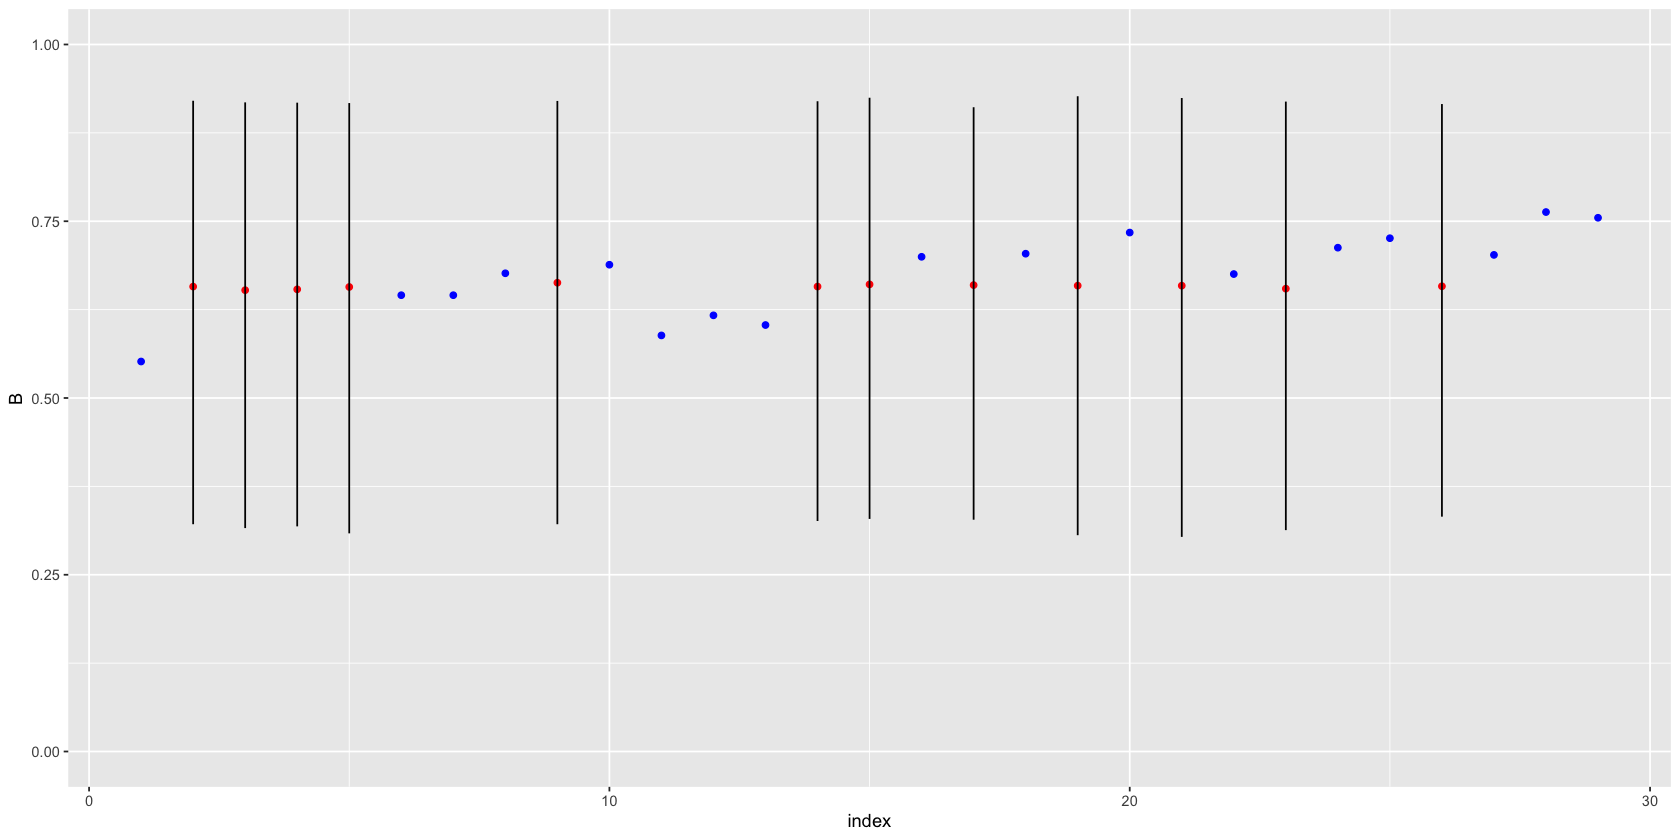

In [50]:
# TODO plot the existing and imputed B values
# TODO plot the old and new versions of Bb
imputed_draws <- posterior[, grep("B_impute", colnames(posterior))]

plot_df <- data.frame(index = seq_len(length(imputed_data$B)), B = imputed_data$B)
plot_df[plot_df$B == -1,]$B <- NA

missing_indices <- which(is.na(plot_df$B))
imputed_df <- data.frame(index = missing_indices, mean = rep(NA, length(missing_indices)), lower = rep(NA, length(missing_indices)), upper = rep(NA, length(missing_indices)))
# print(imputed_df)
current_imputed_index <- 1
for (i in 1:length(plot_df$B)) {
    if (is.na(plot_df$B[i])) {
        column <- imputed_draws[, current_imputed_index]
        imputed_df[imputed_df$index == i, 'lower'] <- quantile(column, 0.025)
        imputed_df[imputed_df$index == i, 'upper'] <- quantile(column, 0.975)
        imputed_df[imputed_df$index == i, 'mean'] <- mean(column)

        current_imputed_index <- current_imputed_index + 1
    }
}
ggplot() +
    geom_point(data = plot_df, mapping = aes(index, B), color = "blue") +
    geom_point(data = imputed_df, mapping = aes(index, mean), color = "red") +
    geom_errorbar(data = imputed_df, mapping = aes(x = index, ymin = lower, ymax = upper), width = 0) + 
    coord_cartesian(ylim = c(0, 1))

I suppose that this is roughly what we were expecting - the imputed $B$ values are shifted up to essentially match the measured values, but there's quite a bit of uncertainty.

In [51]:
precis(fit)

12 vector or matrix parameters hidden. Use depth=2 to show them.



mean          sd        5.5%        94.5%       rhat      ess_bulk
beta_param   3.2043369635 0.9720516  1.81235445  4.90912755 1.0010160 2044.940
alpha_param  6.1920868325 1.9525178  3.42931870  9.62942000 1.0009217 2287.090
nu          -0.0006995903 0.4963325 -0.79122130  0.78178182 1.0008067 8012.466
a           -0.0536044536 0.3030462 -0.51963529  0.42961155 0.9996542 3793.645
bM          -0.2974625862 0.1772150 -0.57820962 -0.01417019 1.0004480 6130.688
bB           0.0850189948 0.4255296 -0.59473992  0.78300201 1.0000399 3706.061
sigma_B      1.0048398565 1.0134897  0.05500349  2.91307210 0.9999914 4934.443
sigma        0.9821424575 0.1344245  0.79613033  1.21799220 1.0013423 6654.466

2.5%        50%      97.5% 
-0.7267641  0.0781368  0.9366069

2.5%         50%       97.5% 
-0.63826000 -0.29739700  0.04861502

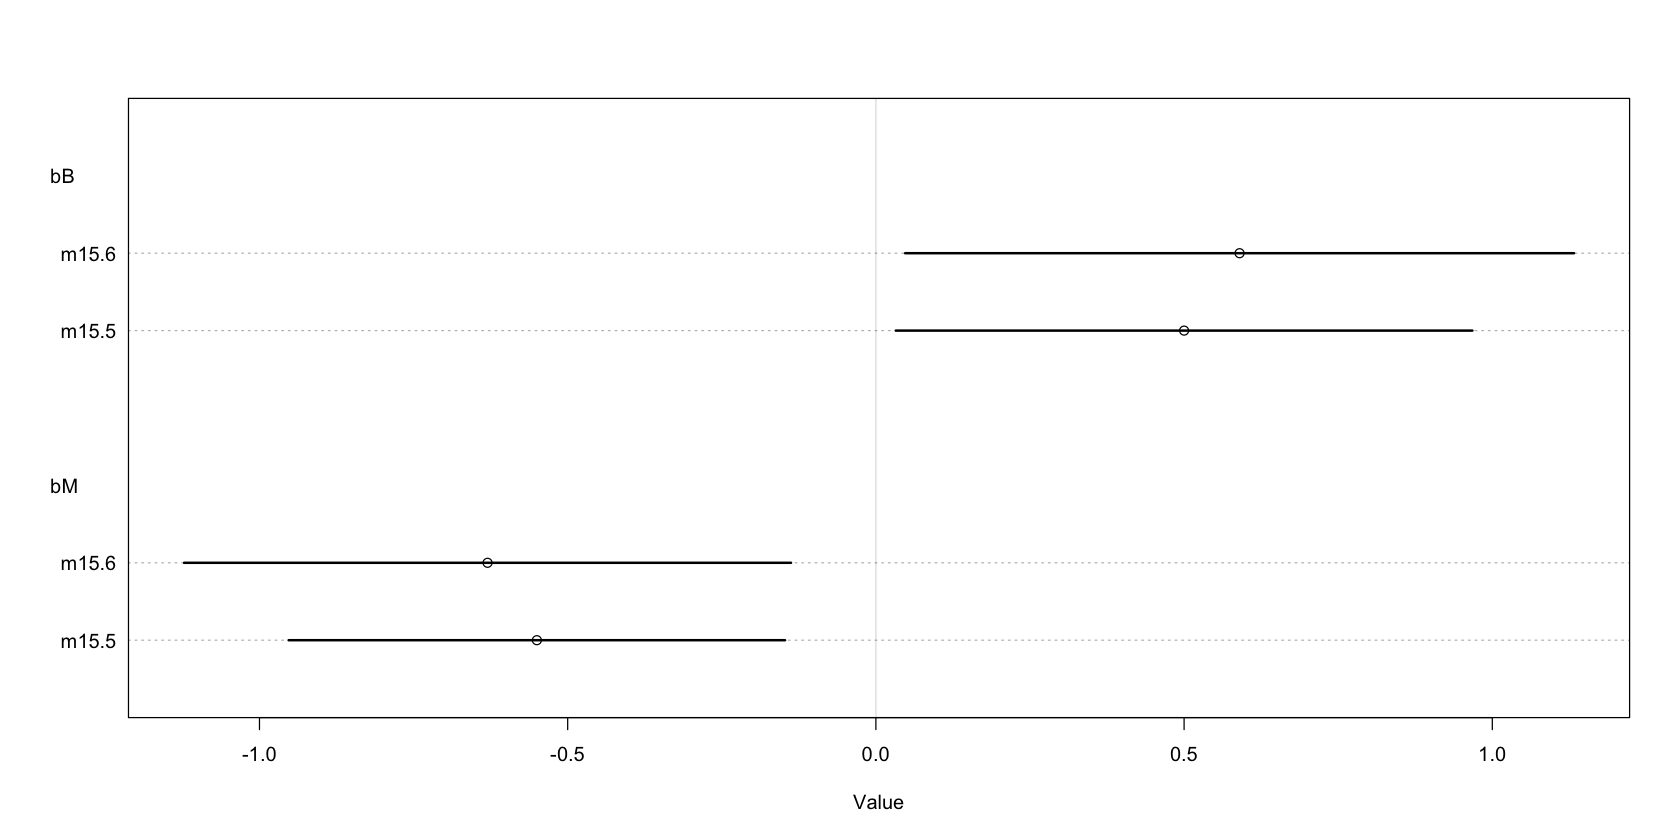

In [52]:
par(bg = 'white')
plot(coeftab(m15.5, m15.6), pars = c("bB", "bM"))

quantile(posterior[, "bB"], c(0.025, 0.5, 0.975))
quantile(posterior[, "bM"], c(0.025, 0.5, 0.975))

We are now far less certain of our estimates! Note that `bB` covers basically the range [-0.76, 0.94] and `bM`, while still reliably negative (barely), is also wider than was calculated in m15.5 or m15.6.

**15M3** Repeat the divorce data measurement error models, but this time double the standard errors. Can you explain how doubling the standard errors impacts inference?

In [53]:
data(WaffleDivorce)
d <- WaffleDivorce

dlist <- list(
    D_obs = standardize(d$Divorce),
    D_sd = d$Divorce.SE / sd ( d$Divorce ),
    M = standardize(d$Marriage),
    A = standardize(d$MedianAgeMarriage),
    N = nrow(d)
)

# this is m15.1
m15m3.standard_error <- ulam(
    alist(
        D_obs ~ dnorm(D_true, D_sd),
        vector[N]:D_true ~ dnorm(mu, sigma),
        mu <- a + bA * A + bM * M,
        a ~ dnorm(0, 0.2),
        bA ~ normal(0, 0.5),
        bM ~ normal(0, 0.5),
        sigma ~ dexp(1)
    ),
    data = dlist,
    chains = 4,
    cores = 4
)

dlist_doubled_error <- list(
    D_obs = standardize(d$Divorce),
    D_sd = 2 * d$Divorce.SE / sd ( d$Divorce ),
    M = standardize(d$Marriage),
    A = standardize(d$MedianAgeMarriage),
    N = nrow(d)
)
m15m3.doubled_error <- ulam(
    alist(
        D_obs ~ dnorm(D_true, D_sd),
        vector[N]:D_true ~ dnorm(mu, sigma),
        mu <- a + bA * A + bM * M,
        a ~ dnorm(0, 0.2),
        bA ~ normal(0, 0.5),
        bM ~ normal(0, 0.5),
        sigma ~ dexp(1)
    ),
    data = dlist_doubled_error,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

See https://mc-stan.org/misc/warnings for details.


See https://mc-stan.org/misc/warnings for details.




In [54]:
precis(m15m3.standard_error)
precis(m15m3.doubled_error)

50 vector or matrix parameters hidden. Use depth=2 to show them.



mean        sd         5.5%       94.5%      rhat     ess_bulk 
a     -0.05185715 0.09873051 -0.2137308  0.1043458 1.001582 1789.2205
bA    -0.61234673 0.16334389 -0.8663504 -0.3480951 1.001383  958.5278
bM     0.05858046 0.17269494 -0.2209977  0.3263502 1.001046  784.9012
sigma  0.58449119 0.10788102  0.4200216  0.7663323 1.014893  503.4299

50 vector or matrix parameters hidden. Use depth=2 to show them.



mean       sd         5.5%        94.5%       rhat     ess_bulk 
a     -0.1056330 0.09999044 -0.27576702  0.04220647 1.017035 175.36087
bA    -0.6389166 0.18135555 -0.91751900 -0.34973120 1.055389  52.62025
bM     0.2120033 0.19127631 -0.09537198  0.52671568 1.039259 195.76128
sigma  0.1755129 0.09665959  0.05786010  0.35881950 1.096639  30.90808

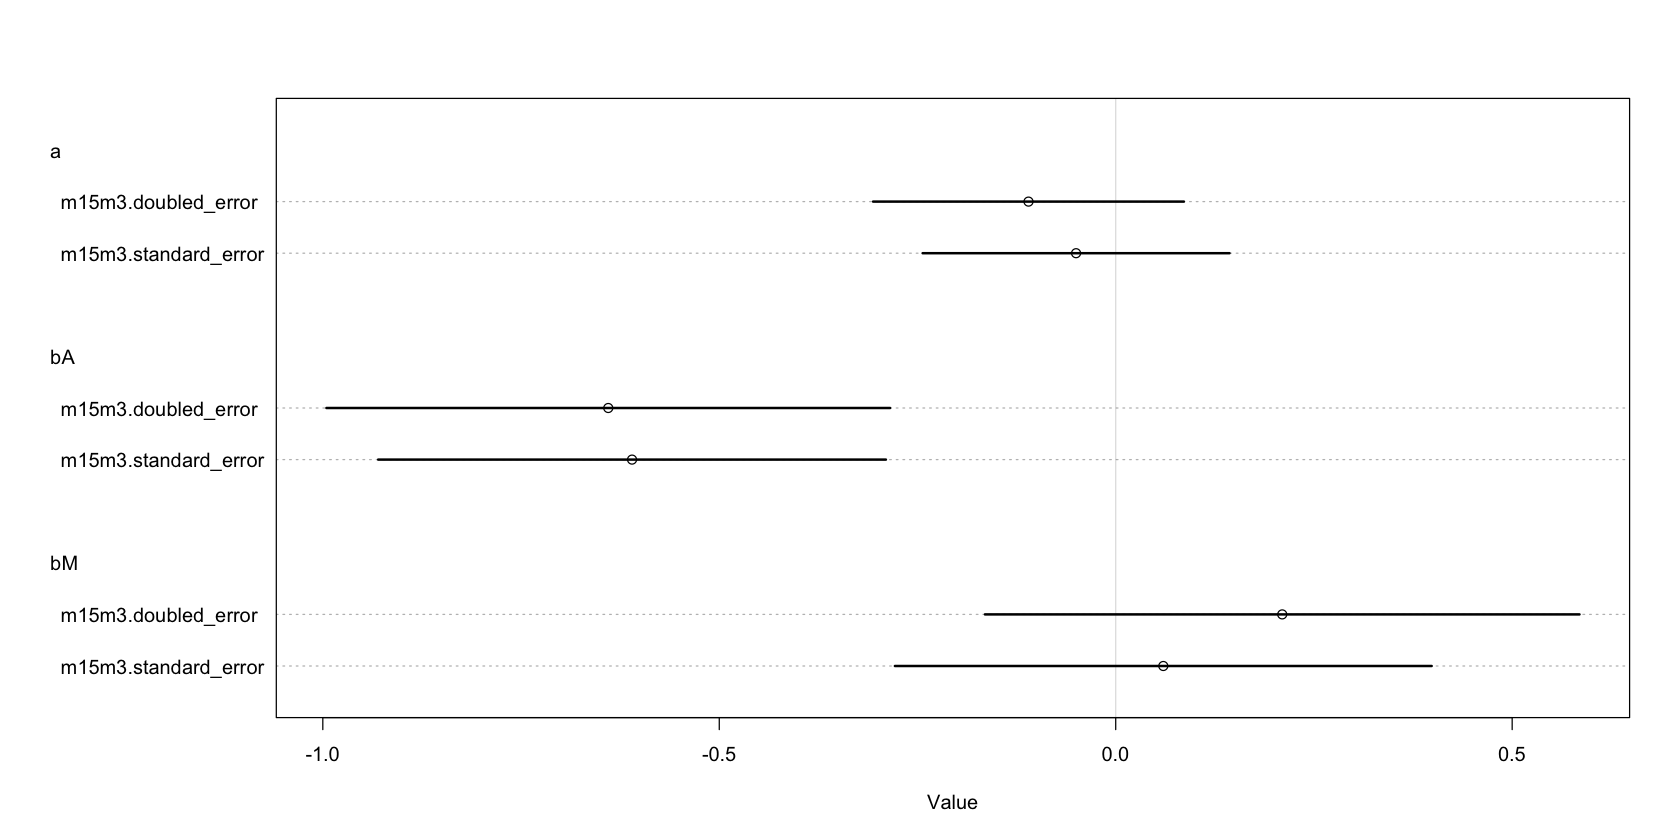

In [55]:
par(bg = 'white')
plot(coeftab(m15m3.standard_error, m15m3.doubled_error), pars = c("a", "bA", "bM"))

Doubling the standard error had an effect on both the intercept and the coefficient for marriage, `bM`. In both cases there was a shift in the mean, but there is still significant overlap between the models.

**15M4** Simulate data from this [[DAG]]: $X \to Y \to Z$ Now fit a model which predicts $Y$ using both $X$ and $Z$. What kind of confound arises, in terms of inferring the causal influence of $X$ on $Y$?

**Answer**

In [56]:
NUM_POINTS <- 1e3
X <- rnorm(NUM_POINTS)
Y <- rnorm(NUM_POINTS, mean = X, sd = 1)
Z <- rnorm(NUM_POINTS, mean = Y + 1, sd = 1)

data_list <- list(
    N = NUM_POINTS,
    X = X,
    Y = Y,
    Z = Z
)
model_string <- "data {
    int N;
    vector[N] X;
    vector[N] Y;
    vector[N] Z;
}
parameters {
    real a;
    real bX;
    real bZ;
    real<lower=0> sigma;
}
model {
    bX ~ normal(0, 1);
    bZ ~ normal(0, 1);
    a ~ normal(0, 1);
    sigma ~ exponential(1);
    vector[N] mu = a + bX * X + bZ * Z;
    Y ~ normal(mu, sigma);
}
"
model_file <- write_stan_file(model_string)
m15m4 <- cmdstan_model(model_file)
m15m4_fit <- m15m4$sample(data = data_list, chains = 4, parallel_chains = 4)

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-3240352560c9.stan', line 19, column 4 to column 26)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-3240352560c9.stan', line 19, column 4 to column 26)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types l

Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-3240352560c9.stan', line 19, column 4 to column 26)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-3240352560c9.stan', line 19, column 4 to column 26)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types l

Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-3240352560c9.stan', line 19, column 4 to column 26)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-3240352560c9.stan', line 19, column 4 to column 26)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types l

Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 4 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 4 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 4 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 

mean       sd         5.5%       94.5%      rhat      ess_bulk
a     -0.5090261 0.02638418 -0.5508299 -0.4656636 1.0008752 2902.955
bX     0.4940170 0.02597959  0.4531954  0.5351110 0.9996881 3069.525
bZ     0.5094419 0.01476967  0.4862583  0.5330897 1.0010847 2539.388
sigma  0.6782986 0.01500815  0.6549509  0.7028617 1.0001494 3670.684

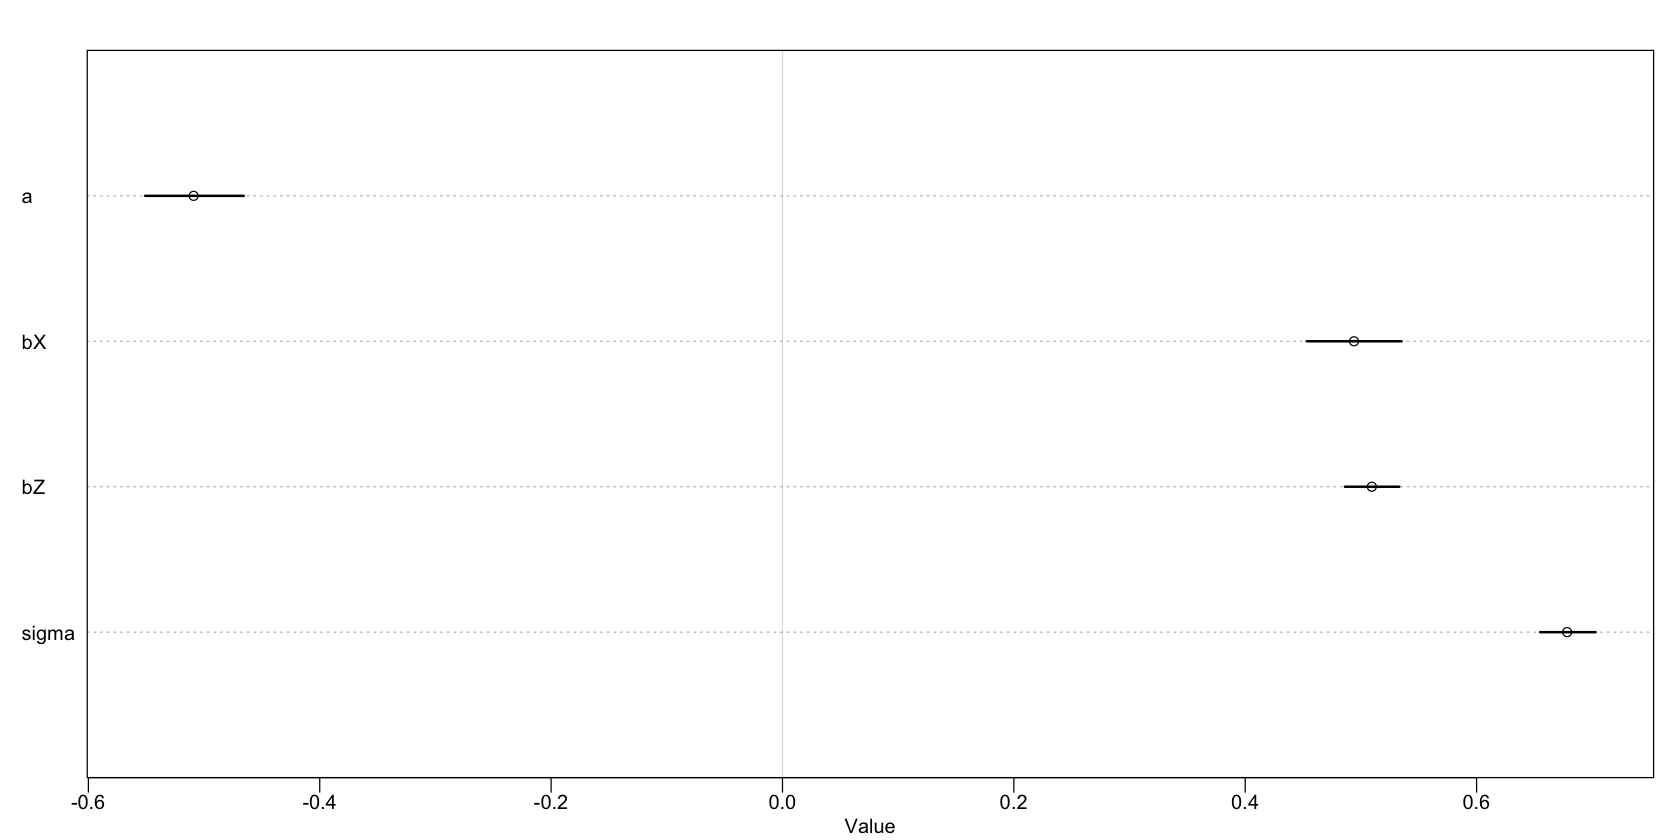

In [57]:
precis(m15m4_fit)

par(bg = 'white')
plot(precis(m15m4_fit))

Note that we know that the above variable values are incorrect because we know the model.

I am honestly not sure what kind of confound would arise here. At least to my understanding, there is no confounding here - we're just including an additional variable in the regression which we shouldn't. If we were looking for the effect of $X$ on $Z$ and conditioning on $Y$ then we would have a collider bias, but I'm not sure what we have here.



**15M5** Return to the singing bird model, m15.9, and compare the posterior estimates of cat presence (PrC1) to the true simulated values. How good is the model at inferring the missing data? Can you think of a way to change the simulation so that the precision of the inference is stronger?

In [58]:
set.seed(9)

N_houses <- 100L
alpha <- 5
beta <- -3
k <- 0.5
r <- 0.2
cat <- rbern(N_houses, k)
notes <- rpois(N_houses, alpha + beta * cat)
R_C <- rbern(N_houses, r)
cat_obs <- cat
cat_obs[R_C == 1] <- -9L # arbitrary value
dat <- list(
    notes = notes,
    cat = cat_obs,
    R_C = R_C,
    N = as.integer(N_houses)
)
dat

# same as m15.9
m15m5.1 <- ulam(
    alist(
        # singing bird model
        # cat known present / absent
        notes|R_C == 0 ~ poisson(lambda),
        notes|R_C == 1 ~ custom(log_sum_exp(
            log(k) + poisson_lpmf(notes | exp(a + b)),
            log(1 - k) + poisson_lpmf(notes | exp(a))
        )),
        log(lambda) <- a + b * cat,
        # cat NA

        # priors
        a ~ normal(0, 1),
        b ~ normal(0, 0.5),

        # sneaking cat model
        cat|R_C == 0 ~ bernoulli(k),
        k ~ beta(2, 2),

        # generated quantities
        gq> vector[N]:PrC1 <- exp(lpC1) / (exp(lpC1) + exp(lpC0)),
        gq> vector[N]:lpC1 <- log(k) + poisson_lpmf(notes[i] | exp(a + b)),
        gq> vector[N]:lpC0 <- log(1 - k) + poisson_lpmf(notes[i] | exp(a))
    ),
    data = dat,
    chains = 4,
    cores = 4
)

$notes
  [1]  9  6  4  3  3  6  5  4  2  1  3  4  2  5  6  1 11  0  8  3  2  7  2  8  3
 [26]  2  6  4  1  0  3  3  4  3  9  3  3  0  9  1  2  0  0  4  3  4  1  4  6  5
 [51]  1  5  4  6  7  4  1  2  2  3  5  8  3  8  2  8  4  6  0  1  5  4  3  2  3
 [76]  3  0  5  3  4  4  5  3  2  3 10  3  5  1  1  4  4  3  2  7  2  2  2  6  6

$cat
  [1] -9  0  0 -9  0  0  0  0  1  1  0  0  1 -9  0  1  0  1  0  0  1 -9  0  0  1
 [26] -9  0 -9 -9 -9  0 -9  0  1  0  1  1  1  0  1 -9  1  1  0  0 -9 -9 -9  0  1
 [51]  1  1 -9  1 -9  1  1  1 -9 -9  0  0  0  0 -9 -9  1  0  1  1  0  0  1  1  0
 [76]  0  1  1  1  0 -9  0 -9 -9  0  0  1  0  1  1  0 -9  0  1  0  1  0  1  0 -9

$R_C
  [1] 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0
 [38] 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1

$N
[1] 100

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 

In [59]:
m15m5.1.results <- precis(m15m5.1, depth = 2, pars = c("PrC1"))
df <- data.frame(m15m5.1.results)
# head(df)
# rownames(df)
# names(m15m5.1.results)
df <- df[R_C == 1,]
df

mean       sd         X5.5.       X94.5.     rhat     ess_bulk
PrC1[1]   0.01325312 0.01077700 0.002884623 0.03224664 1.000613 1618.319
PrC1[4]   0.54650601 0.07123526 0.430359835 0.65866006 1.001455 1577.196
PrC1[14]  0.20429393 0.05918961 0.115081810 0.30169352 1.000354 1830.908
PrC1[22]  0.05414094 0.02813563 0.019341954 0.10489579 1.000445 1716.457
PrC1[26]  0.72397816 0.06193532 0.619554720 0.81761903 1.002192 1383.415
PrC1[28]  0.35645211 0.07080443 0.242866940 0.46904100 1.000639 1759.214
PrC1[29]  0.84986481 0.04797280 0.762807320 0.91556829 1.002425 1279.776
PrC1[30]  0.92340280 0.03381042 0.863321720 0.96480491 1.002454 1244.607
PrC1[32]  0.54650601 0.07123526 0.430359835 0.65866006 1.001455 1577.196
PrC1[41]  0.72397816 0.06193532 0.619554720 0.81761903 1.002192 1383.415
PrC1[46]  0.35645211 0.07080443 0.242866940 0.46904100 1.000639 1759.214
PrC1[47]  0.84986481 0.04797280 0.762807320 0.91556829 1.002425 1279.776
PrC1[48]  0.35645211 0.07080443 0.242866940 0.46904100 1.000639 1759.214
PrC1[53]  0.35645211 0.07080443 0.242866940 0.46904100 1.000639 1759.214
PrC1[55]  0.05414094 0.02813563 0.019341954 0.10489579 1.000445 1716.457
PrC1[59]  0.72397816 0.06193532 0.619554720 0.81761903 1.002192 1383.415
PrC1[60]  0.54650601 0.07123526 0.430359835 0.65866006 1.001455 1577.196
PrC1[65]  0.72397816 0.06193532 0.619554720 0.81761903 1.002192 1383.415
PrC1[66]  0.02681032 0.01761490 0.007556725 0.05904141 1.000548 1662.921
PrC1[81]  0.35645211 0.07080443 0.242866940 0.46904100 1.000639 1759.214
PrC1[83]  0.54650601 0.07123526 0.430359835 0.65866006 1.001455 1577.196
PrC1[84]  0.72397816 0.06193532 0.619554720 0.81761903 1.002192 1383.415
PrC1[92]  0.35645211 0.07080443 0.242866940 0.46904100 1.000639 1759.214
PrC1[100] 0.10750728 0.04274929 0.048522297 0.18001275 1.000308 1772.244

In [60]:
df$variable <- rownames(df)
df$actual_cat_present <- cat[R_C == 1]
df$difference <- df$mean - df$actual_cat_present

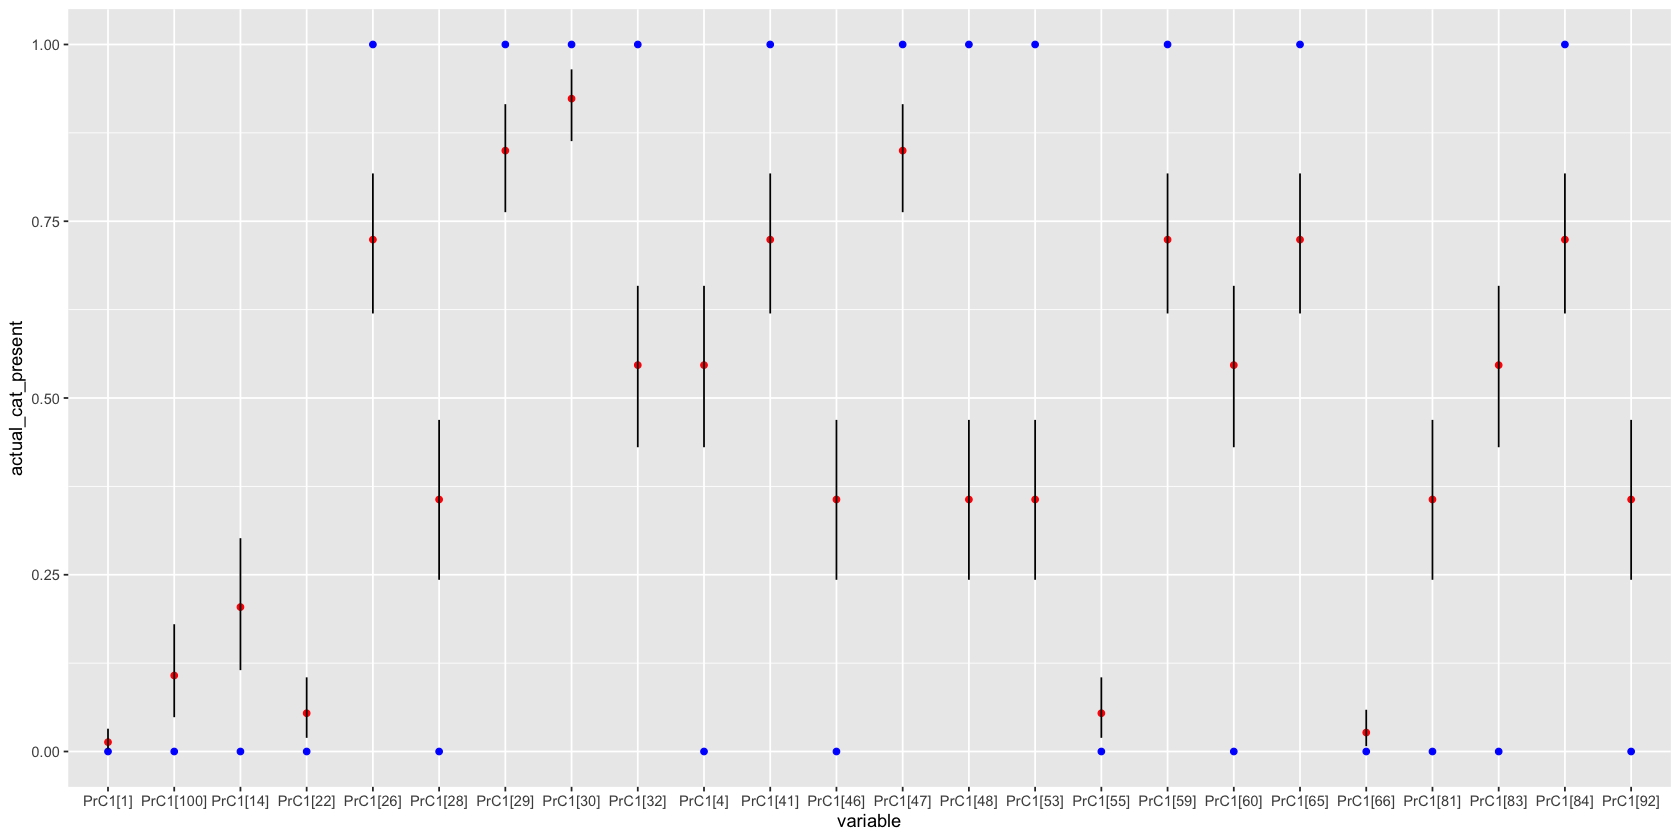

In [61]:
ggplot(df, aes(variable)) +
    geom_point(aes(y = actual_cat_present), color = "blue") +
    geom_point(aes(y = mean), color = "red") +
    geom_errorbar(aes(ymin = X5.5., ymax = X94.5.), width = 0)

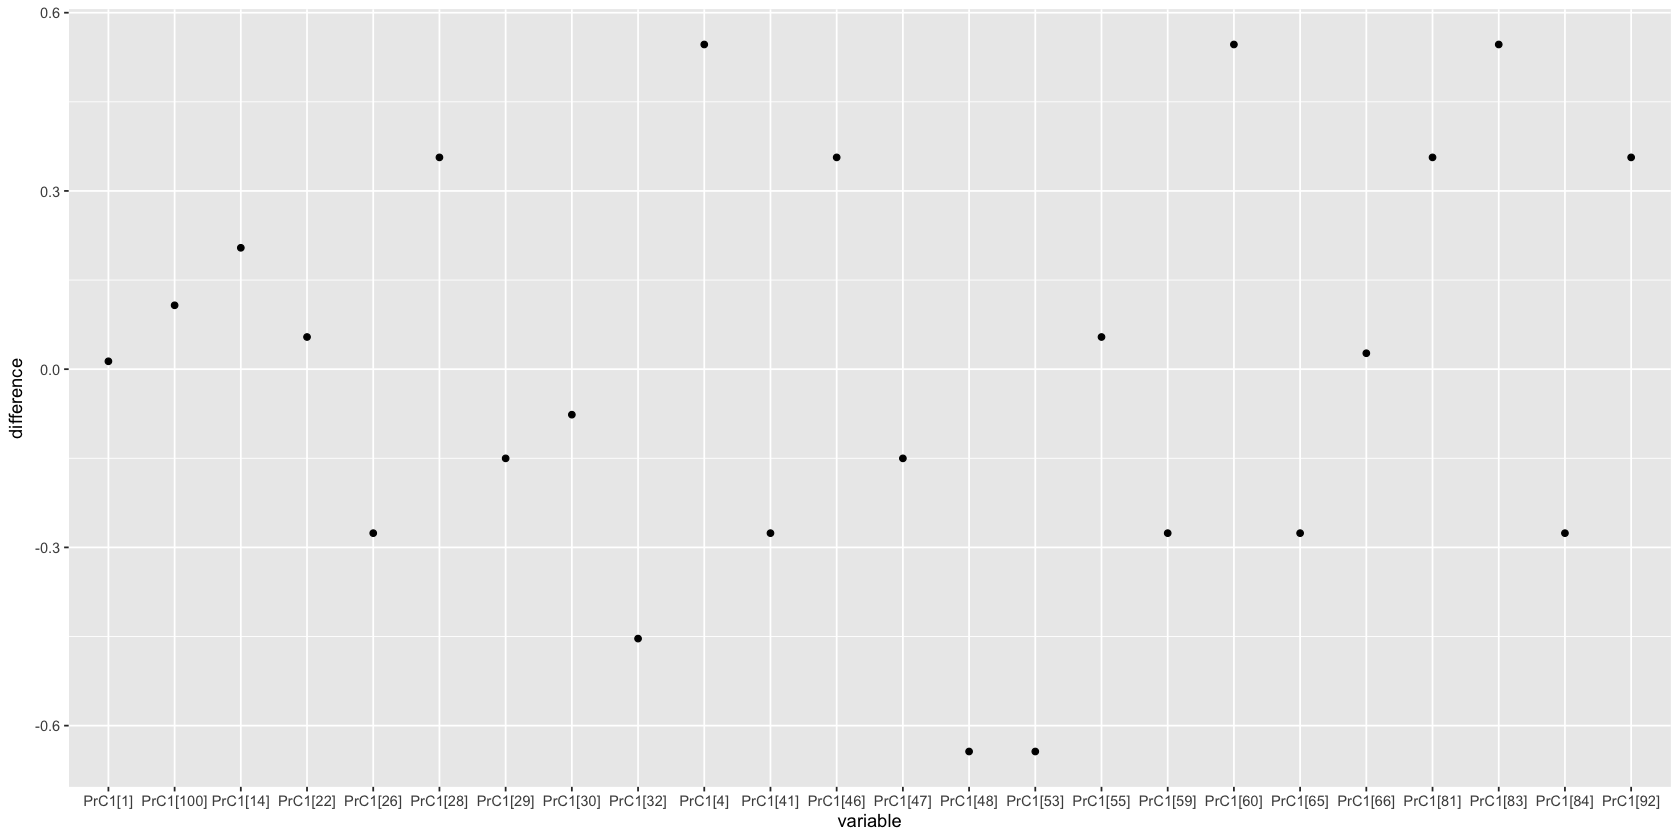

In [62]:
ggplot(df, aes(variable)) +
    geom_point(aes(y = difference))

In [63]:
mean(df$difference)

[1] 0.001162769

From the graphs above and the mean difference, it looks like we're generally not doing a very good job of determining whether or not there's a cat present. Very rarely do the error bars around the predicted value overlap the actual one (or even come close, given that we're modelling it with a beta distribution and so true overlap wouldn't happen).

Ideally we would have some other source of data which we could include in the cat presence model, but I don't think that we really have any. One thing we could try is to start with a weaker prior on the presence of cats. At the momenth the beta(2, 2) prior has a weak bias toward the 50% presence of cats, which seems like a good way to go. However, if we weaken that to beta(1, 1), a flat prior, that might allow the data to pull the probabilities closer to their true value.

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 

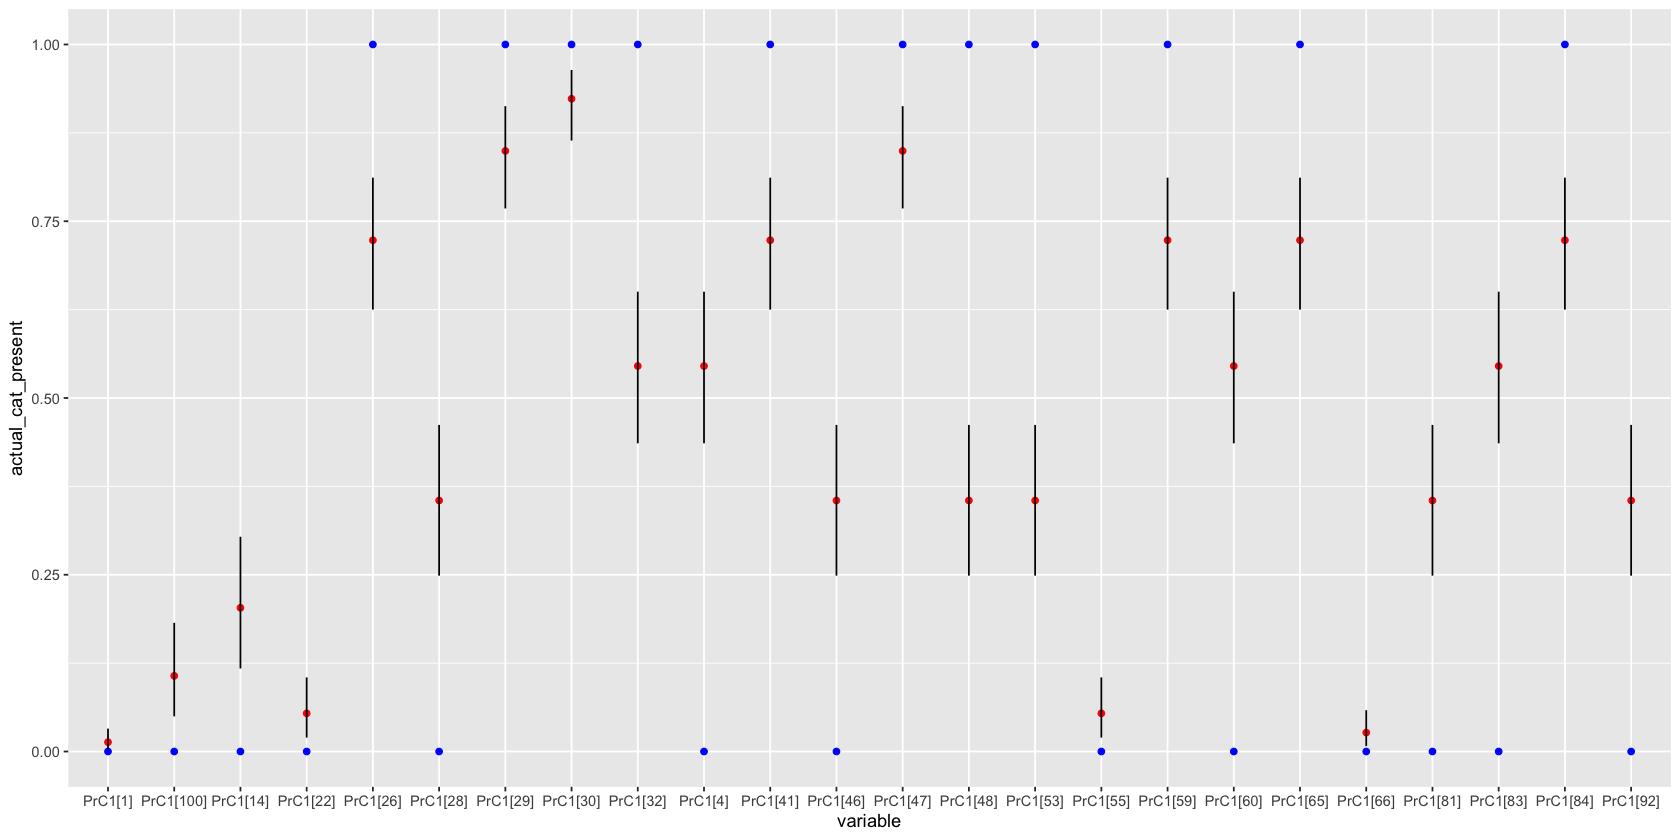

[1] 0.0002839956


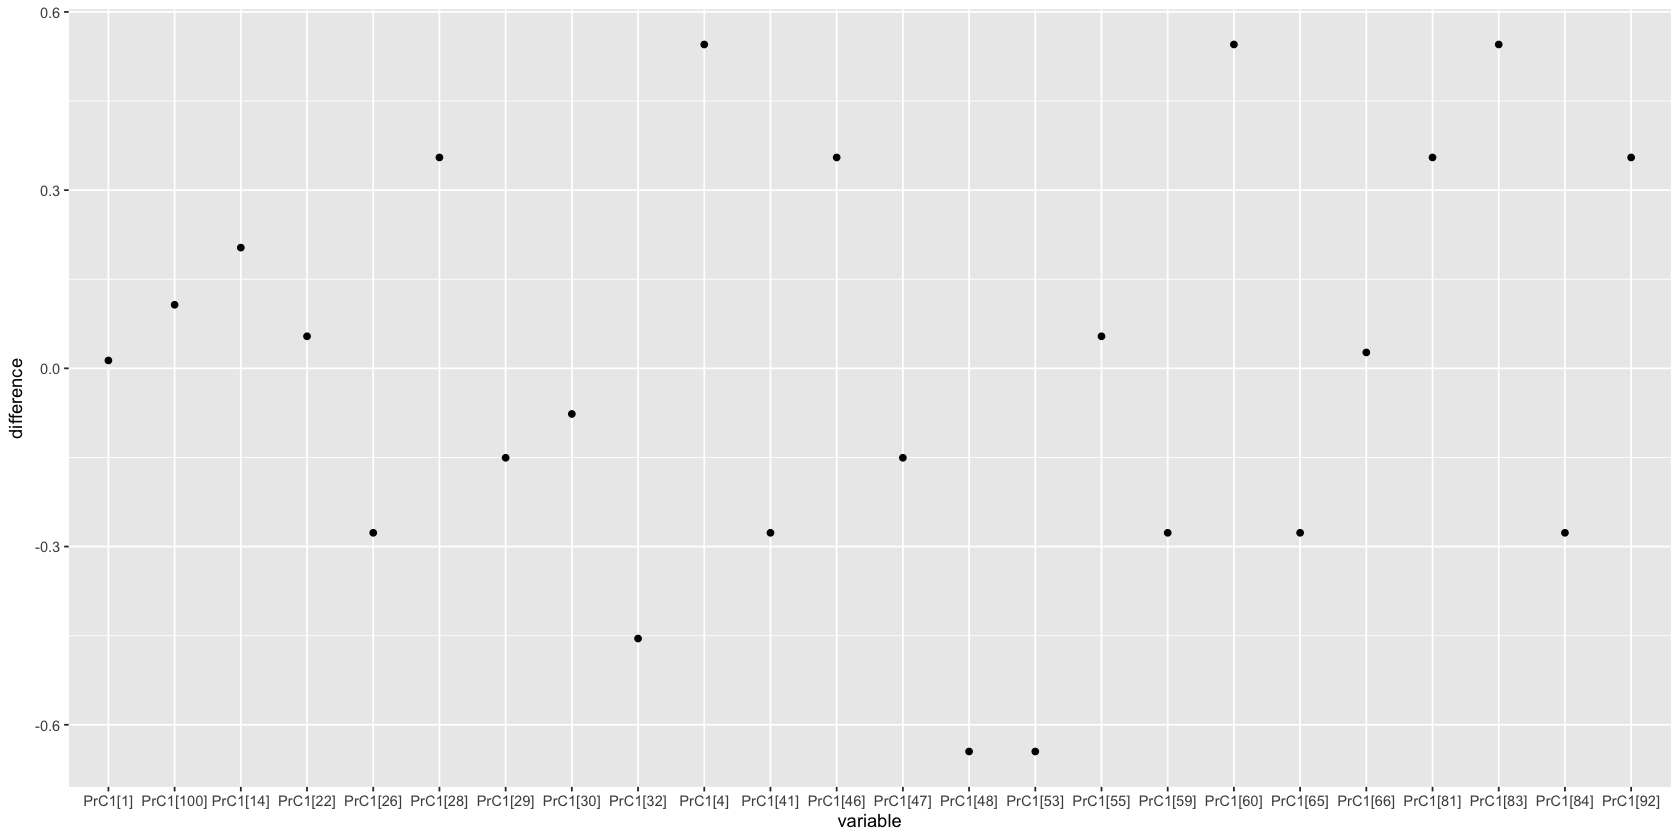

In [64]:
m15m5.2 <- ulam(
    alist(
        # singing bird model
        # cat known present / absent
        notes|R_C == 0 ~ poisson(lambda),
        notes|R_C == 1 ~ custom(log_sum_exp(
            log(k) + poisson_lpmf(notes | exp(a + b)),
            log(1 - k) + poisson_lpmf(notes | exp(a))
        )),
        log(lambda) <- a + b * cat,
        # cat NA

        # priors
        a ~ normal(0, 1),
        b ~ normal(0, 0.5),

        # sneaking cat model
        cat|R_C == 0 ~ bernoulli(k),
        k ~ beta(1, 1),

        # generated quantities
        gq> vector[N]:PrC1 <- exp(lpC1) / (exp(lpC1) + exp(lpC0)),
        gq> vector[N]:lpC1 <- log(k) + poisson_lpmf(notes[i] | exp(a + b)),
        gq> vector[N]:lpC0 <- log(1 - k) + poisson_lpmf(notes[i] | exp(a))
    ),
    data = dat,
    chains = 4,
    cores = 4
)
m15m5.2.results <- precis(m15m5.2, depth = 2, pars = c("PrC1"))
df <- data.frame(m15m5.2.results)
# head(df)
# rownames(df)
# names(m15m5.1.results)
df <- df[R_C == 1,]
df$variable <- rownames(df)
df$actual_cat_present <- cat[R_C == 1]
df$difference <- df$mean - df$actual_cat_present

# actual vs. predicted probabilities
print(
    ggplot(df, aes(variable)) +
        geom_point(aes(y = actual_cat_present), color = "blue") +
        geom_point(aes(y = mean), color = "red") +
        geom_errorbar(aes(ymin = X5.5., ymax = X94.5.), width = 0)
)

# difference between actual and predicted probabilities
print(
    ggplot(df, aes(variable)) +
        geom_point(aes(y = difference))
)

print(mean(df$difference))

So, based on the mean difference in the probabilities this approach is slightly better, but not by a huge amount. Also, looking at the graphs it seems like the model has not improved a lot. So, it's better, but I would really like to see more better improvement.

**15M6** Return to the four dog-eats-homework missing data examples. Simulate each and then fit one or more models to try to recover valid estimates for $S \to H$.

**Answer**



In [65]:
set.seed(100)

N <- 100
S <- rnorm(N)
H <- rbinom(N, size = 10, inv_logit(S))

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

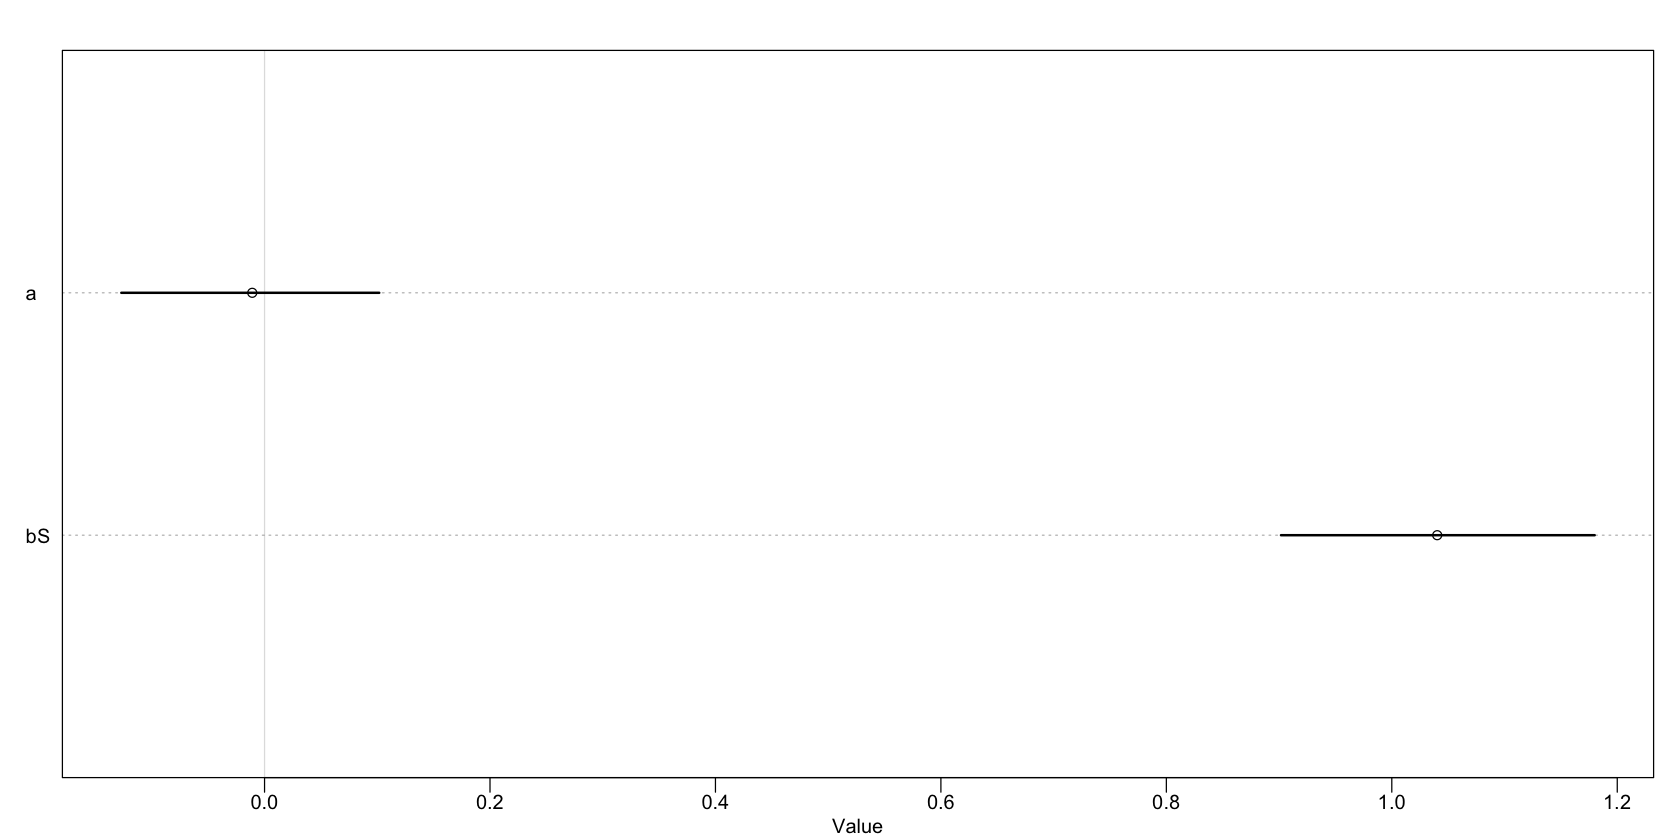

In [66]:
# base model - just recover the values, not dealing with missing data at this point.
base_data <- list(
    S = S,
    H = H
)
m15m6.base <- ulam(
    alist(
        H ~ binomial(10, p),
        logit(p) <- a + bS * S,
        a ~ normal(0, 1),
        bS ~ normal(1, 1)
    ),
    data = base_data,
    chains = 4,
    cores = 4
)
results <- precis(m15m6.base, depth = 2)
print(results)
par(bg = 'white')
plot(results)

OK, now let's introduce the fact that we have data missing at random and see if we can recover the values.

In [67]:
D <- rbern(N) # half the values are missing, totally at random
Hm <- H
Hm[D==1] <- NA

In [70]:
# missing_at_random_data <- list(
#     S = S,
#     H = Hm,
#     N_miss = length(which(is.na(Hm))),
#     miss_idx = which(is.na(Hm))
# )
# m15m6.1.model <- "
# functions {
#     vector merge_missing(array[] int miss_indexes ,vector x_obs , vector x_miss) {
#         int N = dims(x_obs)[1];
#         int N_miss = dims(x_miss)[1];
#         vector[N] merged;
#         merged = x_obs;
#         for (i in 1:N_miss)
#             merged[ miss_indexes[i] ] = x_miss[i];
#         return merged;
#     }
# }
# data {
#     int N;
#     int N_miss;
#     vector[N] S;
#     vector<lower=0, upper=10>[N] H;
#     array[N_miss] int<lower=0> miss_idx;
# }
# parameters {
#     real a;
#     real bS;
#     array[N_miss] int<lower=0, upper=10> H_impute;
# }
# model {
#     a ~ normal(0, 1);
#     bS ~ normal(1, 1);
#     vector[N] p = inv_logit(a + bS * S);
#     for (i in 1:N_miss) {
#         H_impute[i] ~ binomial(10, 0.5);
#     }
#     array[N] int H_merge = merge_missing(miss_idx, to_vector(H), H_impute);
#     H_merge ~ binomial(10, p);
# }"
# m15m6.1.file <- write_stan_file(m15m6.1.model)
# m15m6.1.stan_model <- cmdstan_model(m15m6.1.file)
# m15m6.1.fit <- m15m6.1.stan_model$sample(data = missing_at_random_data, chains = 4, parallel_chains = 4)
# # m15m6.1 <- ulam(
# #     alist(
# #         H ~ binomial(10, p),
# #         logit(p) <- a + bS * S,
# #         a ~ normal(0, 1),
# #         bS ~ normal(1, 1)
# #     ),
# #     data = missing_at_random_data,
# #     chains = 4,
# #     cores = 4
# # )
# results <- precis(m15m6.1.fit, depth = 2)
# print(results)
# par(bg = 'white')
# plot(results)

OK, so the issue here is that to impute the values for `H`, we need to have `H_impute` as a parameter. Unforunately, `H_impute` is an array of integers, which, because they necessarily take on discrete values, [[Stan]] doesn't like; it messes with the [[HMC]] algorithm. Apparently the correct way to deal with this is kind of the same as in the cat example (where we averaged over the discrete values). However, since there are 11 possible values here, that seems like a lot of work! Instead, I'm just going to imagine that the homework values can take on real values rather than being scored 0 - 10. To do this, I'll take the score as being drawn from a beta distribution instead.

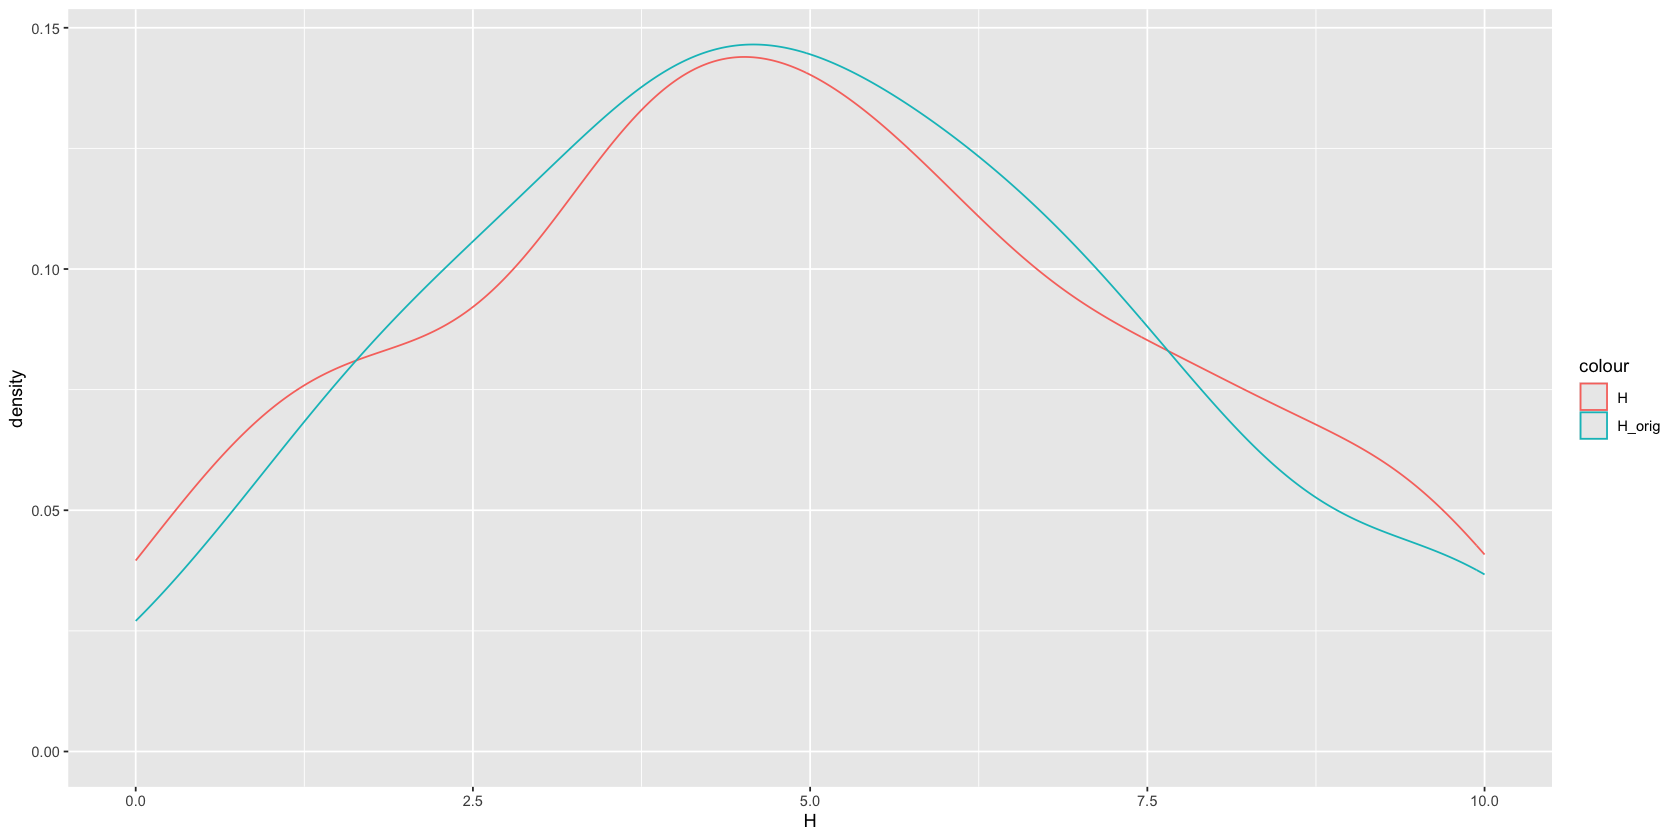

In [71]:
set.seed(100)

N <- 100
S <- rnorm(N)

# parameters for the beta
phi <- inv_logit(S)
lambda <- 6

alpha <- lambda * phi
beta <- lambda * (1 - phi)

H_orig <- rbinom(N, size = 10, inv_logit(S))
H <- 10 * rbeta(N, alpha, beta)

check_df <- data.frame(H_orig = H_orig, H = H)
ggplot(check_df) +
    geom_density(aes(H, colour = "H")) +
    geom_density(aes(H_orig, colour = "H_orig"))

This looks good enough to me!

Running MCMC with 4 parallel chains...



Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: beta_lpdf: First shape parameter[1] is -0.690846, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 Exception: beta_lpdf: First shape parameter[1] is -0.690846, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)



Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: Second shape parameter[1] is -435.271, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: Second shape parameter[1] is -525.855, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, suc

Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[1] is -173.244, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[1] is -299.141, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such 

Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.0185264, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.000809539, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadicall

Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 


Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.00457772, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 


Chain 2 Exception: beta_lpdf: First shape parameter[55] is -0.0548801, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.00444154, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this

Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.00398024, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.0998208, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically

Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.003532, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[55] is -0.0364091, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, 

Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 


Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.0110578, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[80] is -0.00449299, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: Second shape parameter[89] is -0.0419368, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadicall

Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 


Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.00249548, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: Second shape parameter[20] is -0.00251023, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if th

Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.00935181, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.0070458, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically

Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 


Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.0577056, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 


Chain 4 Exception: beta_lpdf: First shape parameter[60] is -0.0355418, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[97] is -0.00870082, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this

Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 


Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.025576, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

C

Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 


Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.0106042, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[26] is -0.013572, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this w

Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.00904551, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.0184695, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically

Chain 4 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[80] is -0.00694031, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[55] is -0.000116774, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.0126522, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadicall

Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 


Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.0163918, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 


Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.0178777, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[55] is -0.000405628, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if thi

Chain 4 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 4 Iteration:  800 / 2000 [ 40%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: Second shape parameter[20] is -0.429332, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[80] is -0.00192504, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically

Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 


Chain 1 Exception: beta_lpdf: First shape parameter[17] is -0.463359, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.00883719, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this 

Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[55] is -0.0585936, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.00210261, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically

Chain 3 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: Second shape parameter[54] is -8.55283e-05, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue

Chain 4 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1100 / 2000 [ 55%]  (Sampling) 


Chain 4 Exception: beta_lpdf: First shape parameter[80] is -0.0511918, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: Second shape parameter[20] is -0.0197152, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this

Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 


Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.00702444, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 2 Iteration: 1400 / 2000 [ 70%]  (Sampling) 


Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.0018022, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.00280922, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this

Chain 3 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 3 Iteration:  800 / 2000 [ 40%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.0761739, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: Second shape parameter[32] is -0.0304658, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically

Chain 4 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 4 Iteration: 1300 / 2000 [ 65%]  (Sampling) 


Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: Second shape parameter[20] is -0.171444, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: Second shape parameter[58] is -0.0522069, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: Second shape parameter[85] is -0.0266703, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadicall

Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 2 Iteration: 1700 / 2000 [ 85%]  (Sampling) 


Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.00225805, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


Chain 3 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 3 Iteration: 1200 / 2000 [ 60%]  (Sampling) 


Chain 3 Exception: beta_lpdf: First shape parameter[55] is -0.006359, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.0117855, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this w

Chain 4 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 4 Iteration: 1500 / 2000 [ 75%]  (Sampling) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[94] is -0.00706653, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[57] is -0.0205941, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically

Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 


Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.00303565, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.00245776, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if thi

Chain 2 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1900 / 2000 [ 95%]  (Sampling) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: Second shape parameter[96] is -0.0170924, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.0127419, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically

Chain 3 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 3 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 3 Iteration: 1700 / 2000 [ 85%]  (Sampling) 


Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[80] is -0.0168944, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Chain 4 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 4 Iteration: 1700 / 2000 [ 85%]  (Sampling) 


Chain 4 Exception: beta_lpdf: First shape parameter[62] is -0.00665215, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[80] is -0.218702, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this 

Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 


Chain 2 Exception: beta_lpdf: First shape parameter[80] is -0.000613685, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: beta_lpdf: Second shape parameter[20] is -0.0184912, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if th

Chain 2 finished in 5.7 seconds.
Chain 1 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1900 / 2000 [ 95%]  (Sampling) 


Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.0628405, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Chain 3 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: First shape parameter[57] is -0.0154745, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: beta_lpdf: Second shape parameter[89] is -0.00474544, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 3 If this warning occurs sporadicall

Chain 4 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1900 / 2000 [ 95%]  (Sampling) 


Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: Second shape parameter[89] is -0.0424896, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[55] is -0.000663239, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: beta_lpdf: First shape parameter[80] is -0.00357793, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 1 If this warning occurs sporadical

Chain 1 finished in 6.4 seconds.
Chain 3 finished in 5.1 seconds.
Chain 4 Iteration: 2000 / 2000 [100%]  (Sampling) 


Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[80] is -0.00433466, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: beta_lpdf: First shape parameter[80] is -0.0147192, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpeSfynj/model-324035c5cbb2.stan', line 20, column 4 to column 38)

Chain 4 If this warning occurs sp

Chain 4 finished in 6.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 5.9 seconds.
Total execution time: 6.6 seconds.



See https://mc-stan.org/misc/warnings for details.




              mean         sd        5.5%       94.5%      rhat ess_bulk
a      -0.01899262 0.03471261 -0.07445003  0.03740045 1.0023022 1422.866
bS      1.01285688 0.05967495  0.91732101  1.10435045 1.0046395 1418.924
lambda  6.07636187 0.90175708  4.70827855  7.57100125 1.0006759 1763.792
S[1]    0.34440472 0.63756043 -0.65799557  1.37516870 1.0005591 5403.169
S[2]   -0.79298625 0.61298746 -1.79085540  0.20178889 1.0011007 5528.748
S[3]   -0.01906918 0.64164372 -1.00706915  0.98482948 1.0062886 6336.209
S[4]    0.54402613 0.65663971 -0.48712909  1.59224325 1.0021646 5376.590
S[5]   -0.03282800 0.66286424 -1.10279765  0.99281528 1.0026289 4864.465
S[6]    0.41109419 0.63987567 -0.57574655  1.43597350 0.9999003 5069.039
S[7]   -0.33892532 0.63388954 -1.35552880  0.65111230 1.0010822 5657.927
S[8]    0.48908536 0.65893068 -0.54242053  1.53229210 1.0033198 4999.165
S[9]   -0.26766755 0.66406823 -1.33867510  0.77217111 1.0009874 5332.375
S[10]  -0.09634924 0.66351816 -1.13786155  0.932952

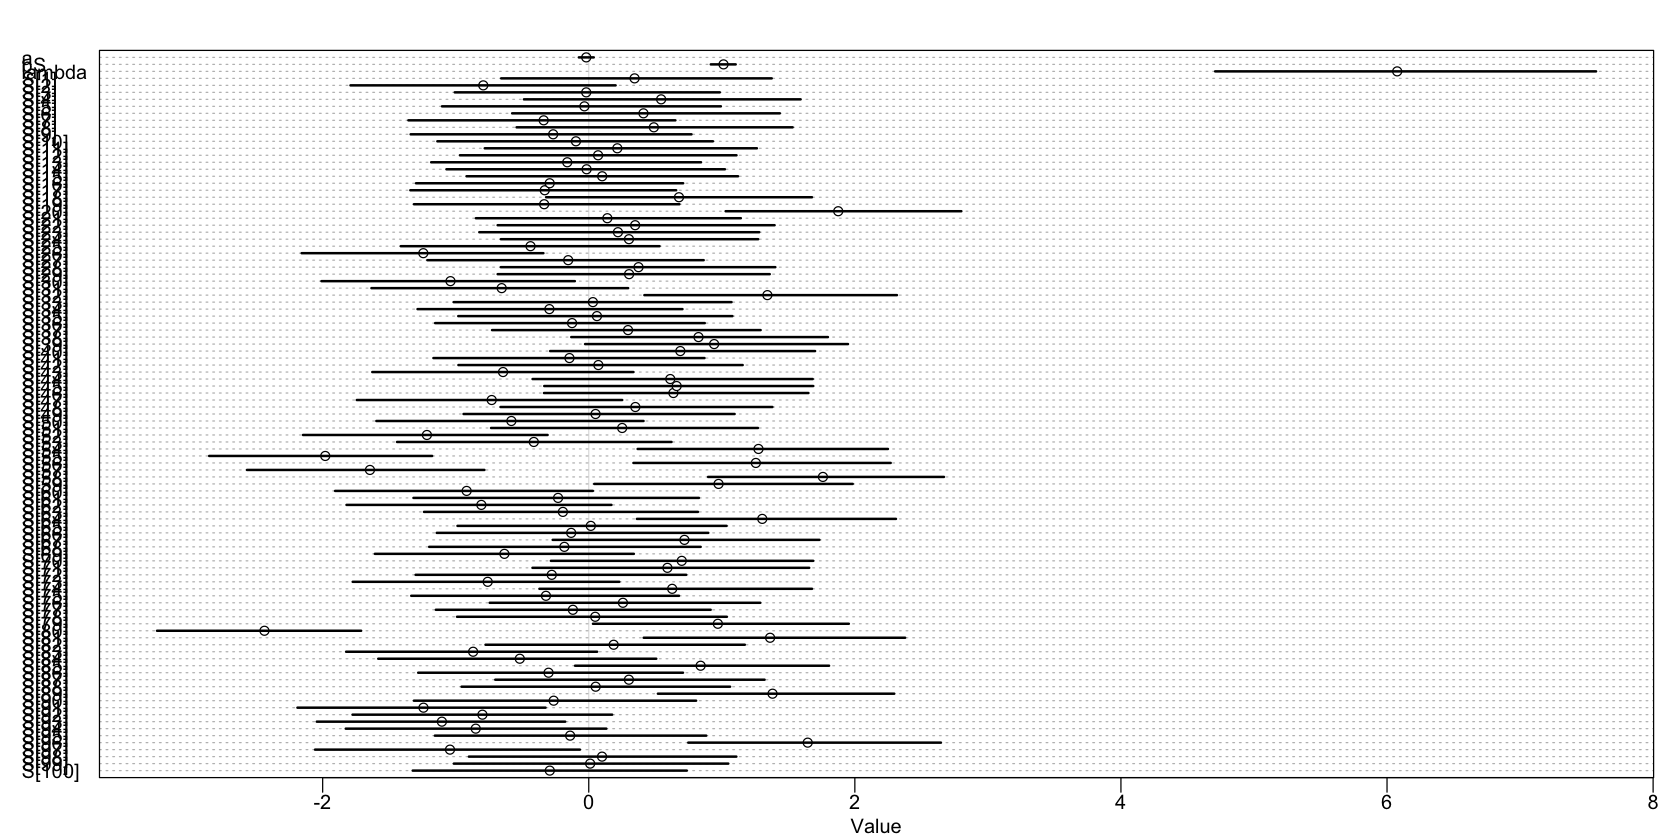

In [72]:
# base model - just recover the values, not dealing with missing data at this point.
base_data <- list(
    N = length(S),
    H = H / 10 # normalize
)
m15m6.base.model <- "
data {
    int N;
    vector<lower=0, upper=10>[N] H;
}
parameters {
    real a;
    real bS;
    real lambda;
    vector[N] S;
}
model {
    S ~ std_normal();
    a ~ std_normal();
    bS ~ normal(1, 0.1);
    vector[N] phi = a + bS * inv_logit(S);
    lambda ~ normal(6, 1);
    vector[N] alpha_param = lambda * phi;
    vector[N] beta_param = lambda * (1 - phi);
    H ~ beta(alpha_param, beta_param);
}
"
m15m6.base.file <- write_stan_file(m15m6.base.model)
m15m6.base.stan_model <- cmdstan_model(m15m6.base.file)
m15m6.base.fit <- m15m6.base.stan_model$sample(data = base_data, chains = 4, parallel_chains = 4, adapt_delta = 0.95)
results <- precis(m15m6.base.fit, depth = 2)
print(results)
par(bg = 'white')
plot(results)

In [73]:
draws_df <- as_draws_df(m15m6.base.fit)
head(draws_df)
colnames(draws_df)

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


lp__     a          bS      lambda  S[1]     S[2]      S[3]      S[4]    
1 30.68360 -0.0488395 1.13930 6.97174 0.470866 -1.249660 -0.711052 0.648798
2 24.93980 -0.0364657 1.03032 7.95052 0.669063 -0.763400 -0.945011 1.124330
3  4.95332 -0.0290490 1.10057 7.35999 0.569052 -1.069990 -0.954200 0.499326
4 -3.74445 -0.0132914 1.00192 4.66111 0.231520 -1.078670 -0.592972 0.346260
5  9.35613 -0.0387683 1.02242 5.82426 0.261423 -0.260876  0.632561 0.625114
6 11.38470 -0.0108144 1.01147 6.55064 0.400280 -1.121400  0.369012 0.699636
  S[5]      S[6]     ⋯ S[94]     S[95]      S[96]   S[97]     S[98]    
1  0.507116 0.862534 ⋯ -0.998598 -0.5143000 1.89106 -1.341190  0.418043
2  0.136164 0.902031 ⋯ -1.507690  0.5493900 2.03739 -0.817395  0.264284
3  0.231755 0.523738 ⋯ -0.964689  0.0760503 2.31066 -0.102452 -0.210280
4 -0.431920 0.570325 ⋯  0.049051 -0.8488820 1.80797 -1.215810 -0.102212
5  0.227339 0.428662 ⋯ -1.537180  0.4520930 1.44011 -0.658286  0.620106
6  0.268188 0.892054 ⋯ -1.009640 -0.1524900 1.57164 -0.888876 -1.027250
  S[99]      S[100]     .chain .iteration .draw
1 -0.9864420 -0.0497506 1      1          1    
2 -0.1905810 -0.4287850 1      2          2    
3  0.1292890  0.2353920 1      3          3    
4 -0.7047330 -0.6937200 1      4          4    
5  0.7656750  0.2450710 1      5          5    
6  0.0895812 -1.0680400 1      6          6

[1] "lp__"       "a"          "bS"         "lambda"     "S[1]"      
  [6] "S[2]"       "S[3]"       "S[4]"       "S[5]"       "S[6]"      
 [11] "S[7]"       "S[8]"       "S[9]"       "S[10]"      "S[11]"     
 [16] "S[12]"      "S[13]"      "S[14]"      "S[15]"      "S[16]"     
 [21] "S[17]"      "S[18]"      "S[19]"      "S[20]"      "S[21]"     
 [26] "S[22]"      "S[23]"      "S[24]"      "S[25]"      "S[26]"     
 [31] "S[27]"      "S[28]"      "S[29]"      "S[30]"      "S[31]"     
 [36] "S[32]"      "S[33]"      "S[34]"      "S[35]"      "S[36]"     
 [41] "S[37]"      "S[38]"      "S[39]"      "S[40]"      "S[41]"     
 [46] "S[42]"      "S[43]"      "S[44]"      "S[45]"      "S[46]"     
 [51] "S[47]"      "S[48]"      "S[49]"      "S[50]"      "S[51]"     
 [56] "S[52]"      "S[53]"      "S[54]"      "S[55]"      "S[56]"     
 [61] "S[57]"      "S[58]"      "S[59]"      "S[60]"      "S[61]"     
 [66] "S[62]"      "S[63]"      "S[64]"      "S[65]"      "S[66]"     
 [71] "S[67]"      "S[68]"      "S[69]"      "S[70]"      "S[71]"     
 [76] "S[72]"      "S[73]"      "S[74]"      "S[75]"      "S[76]"     
 [81] "S[77]"      "S[78]"      "S[79]"      "S[80]"      "S[81]"     
 [86] "S[82]"      "S[83]"      "S[84]"      "S[85]"      "S[86]"     
 [91] "S[87]"      "S[88]"      "S[89]"      "S[90]"      "S[91]"     
 [96] "S[92]"      "S[93]"      "S[94]"      "S[95]"      "S[96]"     
[101] "S[97]"      "S[98]"      "S[99]"      "S[100]"     ".chain"    
[106] ".iteration" ".draw"

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


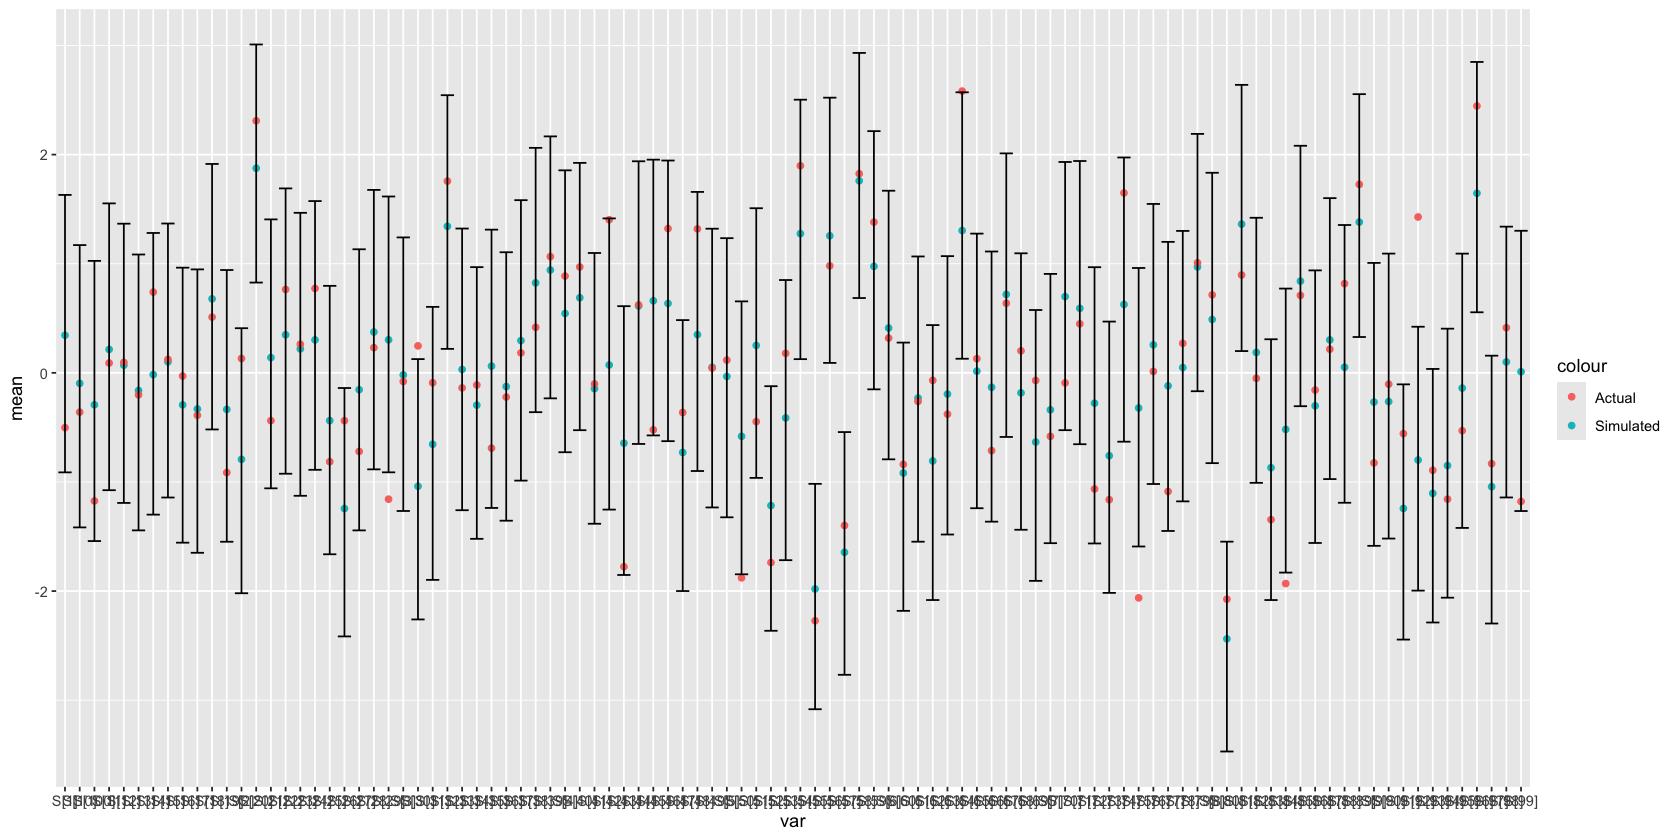

In [74]:
S_draws <- draws_df[, grep("S\\[.+\\]", colnames(draws_df))]

draw_means <- apply(S_draws, 2, mean)
lower <- apply(S_draws, 2, function(x) quantile(x, 0.025))
upper <- apply(S_draws, 2, function(x) quantile(x, 0.975))
vars <- colnames(S_draws)
S_df <- data.frame(actual = S, mean = draw_means, lower = lower, upper = upper, var = vars)
ggplot(S_df, aes(var)) +
    geom_point(aes(y = mean, colour = "Simulated")) +
    geom_point(aes(y = actual, colour = "Actual")) +
    geom_errorbar(aes(ymin = lower, ymax = upper))

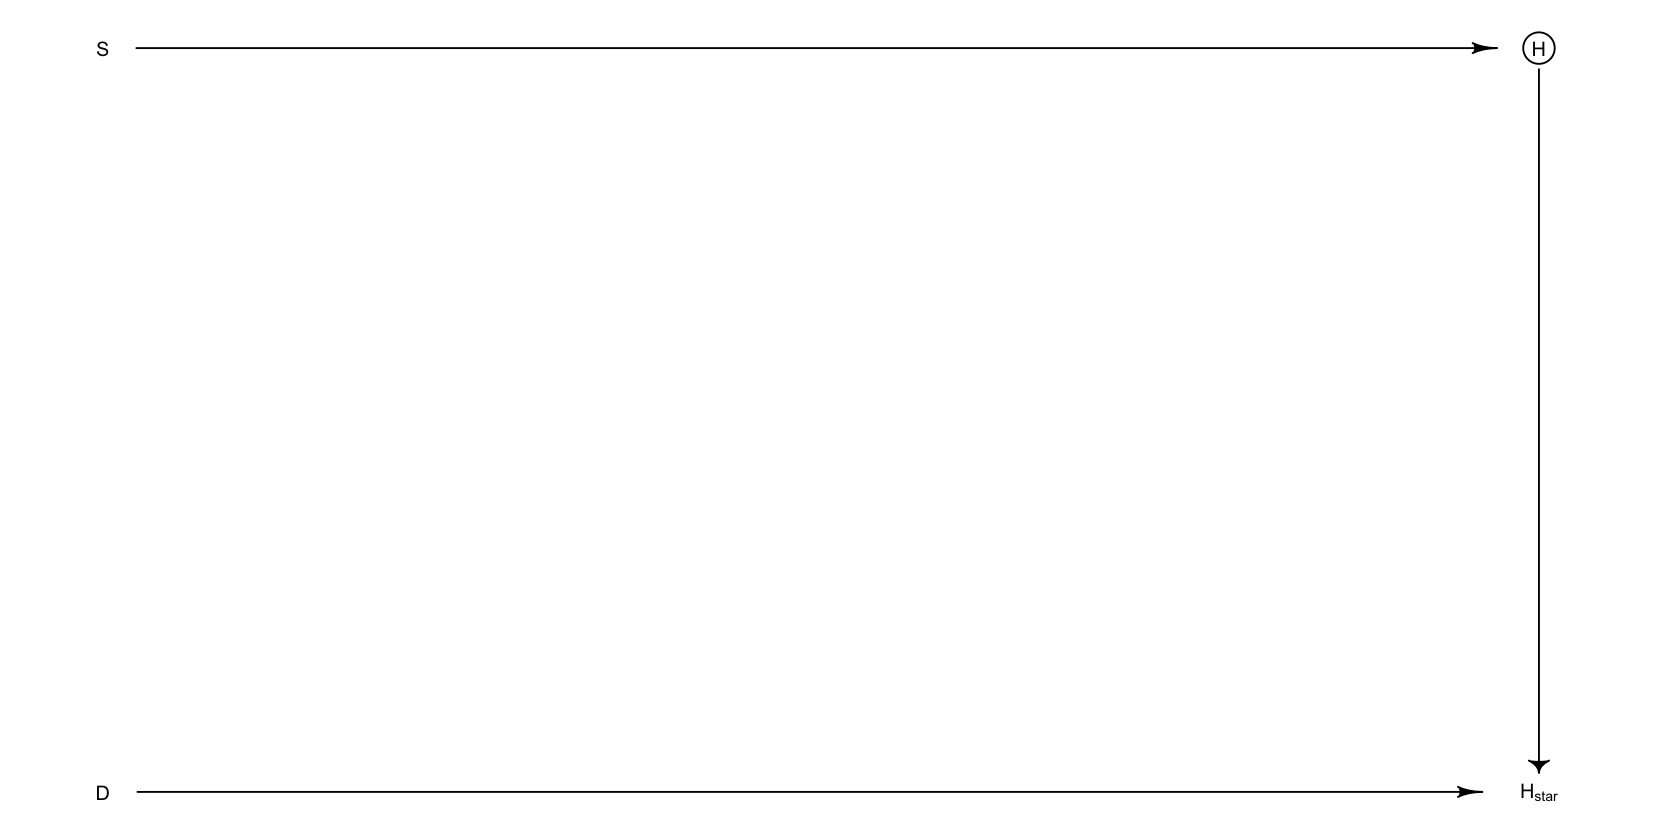

In [75]:
par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
S -> H
H -> H_star
H_star <- D
}' )
drawdag(dag)
# a)

In this case, the dog eats the homework completely at random.

In [76]:
D <- rbern(N)
Hm <- H
Hm[D==1] <- NA

D <- rbern(N) # half the values are missing, totally at random
Hm <- H
Hm[D==1] <- NA

Because the missing data is completely random, we should be able to recover the values just by recreating the model; it's just that we have less data now.

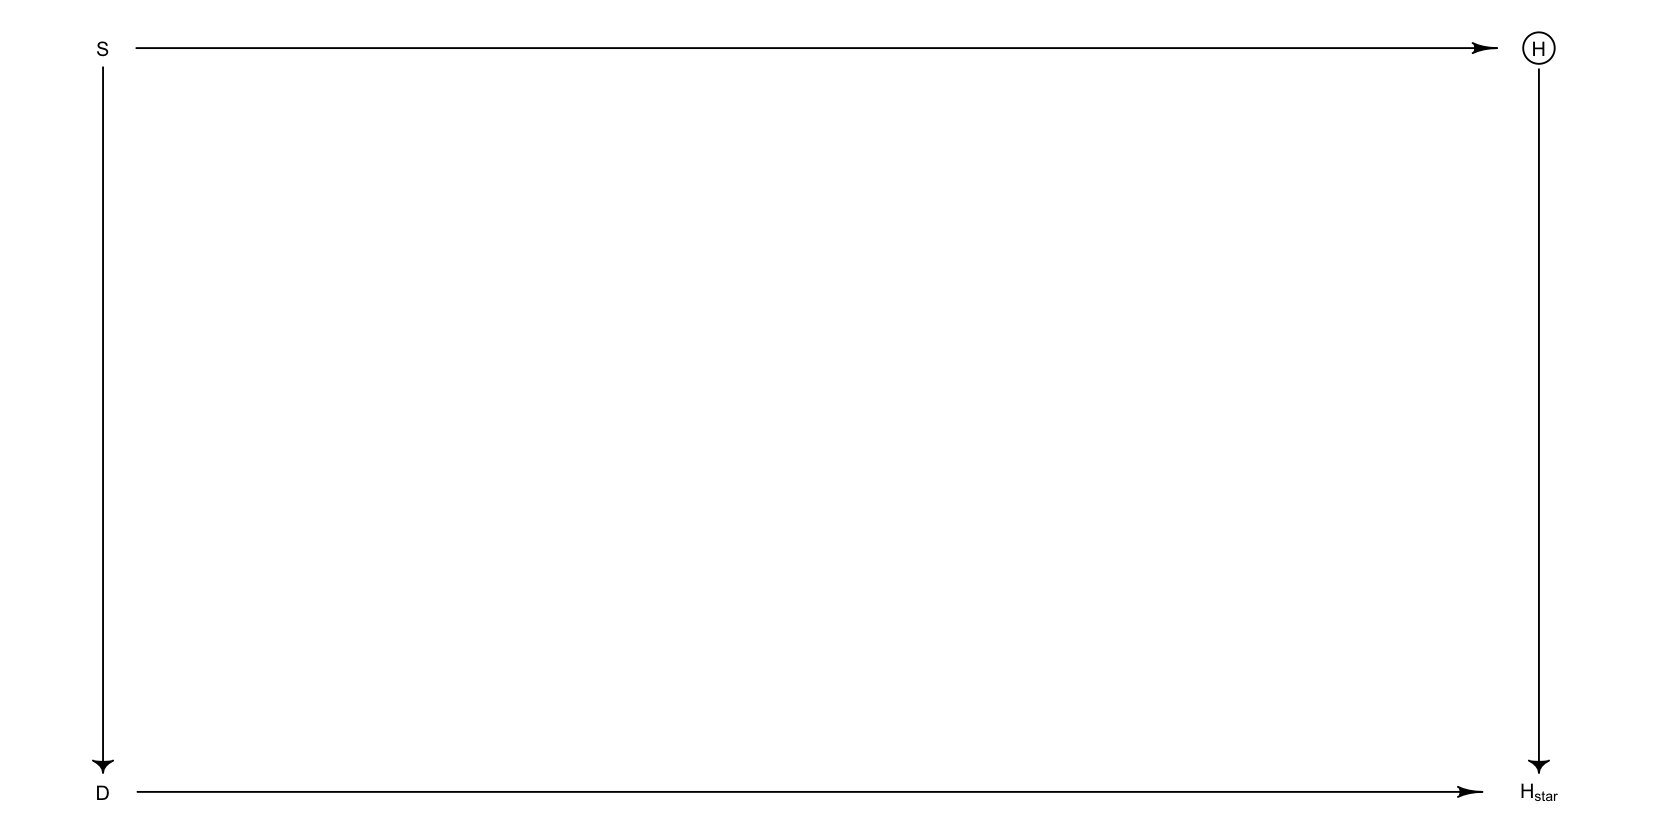

In [77]:

par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
S -> H
H -> H_star
H_star <- D
S -> D
}' )
drawdag(dag)

In this example, the dogs are preferentially eating the homework of students who study too much (they don't have time to take them on walks). Let's see how our model does at recovering these data!

In [79]:
set.seed(100)

N <- 100
S <- rnorm(N)

# parameters for the beta
phi <- inv_logit(S)
lambda <- 6

alpha <- lambda * phi
beta <- lambda * (1 - phi)

H <- 10 * rbeta(N, alpha, beta)

D <- ifelse(S > 0, 1, 0) # everyone above average gets their homework eaten
Hm <- H
Hm[D==1] <- NA

dogs_eat_good_students_homework_data <- list(
    N = N,
    S = S,
    H = Hm,
    N_miss = length(which(is.na(Hm))),
    miss_idx = which(is.na(Hm))
)

m15m6.b.fit <- m15m6.base.stan_model$sample(data = dogs_eat_good_students_homework_data, chains = 4, parallel_chains = 4, adapt_delta = 0.95)
results <- precis(m15m6.b.fit, depth = 2)
print(results)
par(bg = 'white')
plot(results)


draws_df <- as_draws_df(m15m6.b.fit)
head(draws_df)
colnames(draws_df)

ERROR: Error: Variable 'H' has NA values.


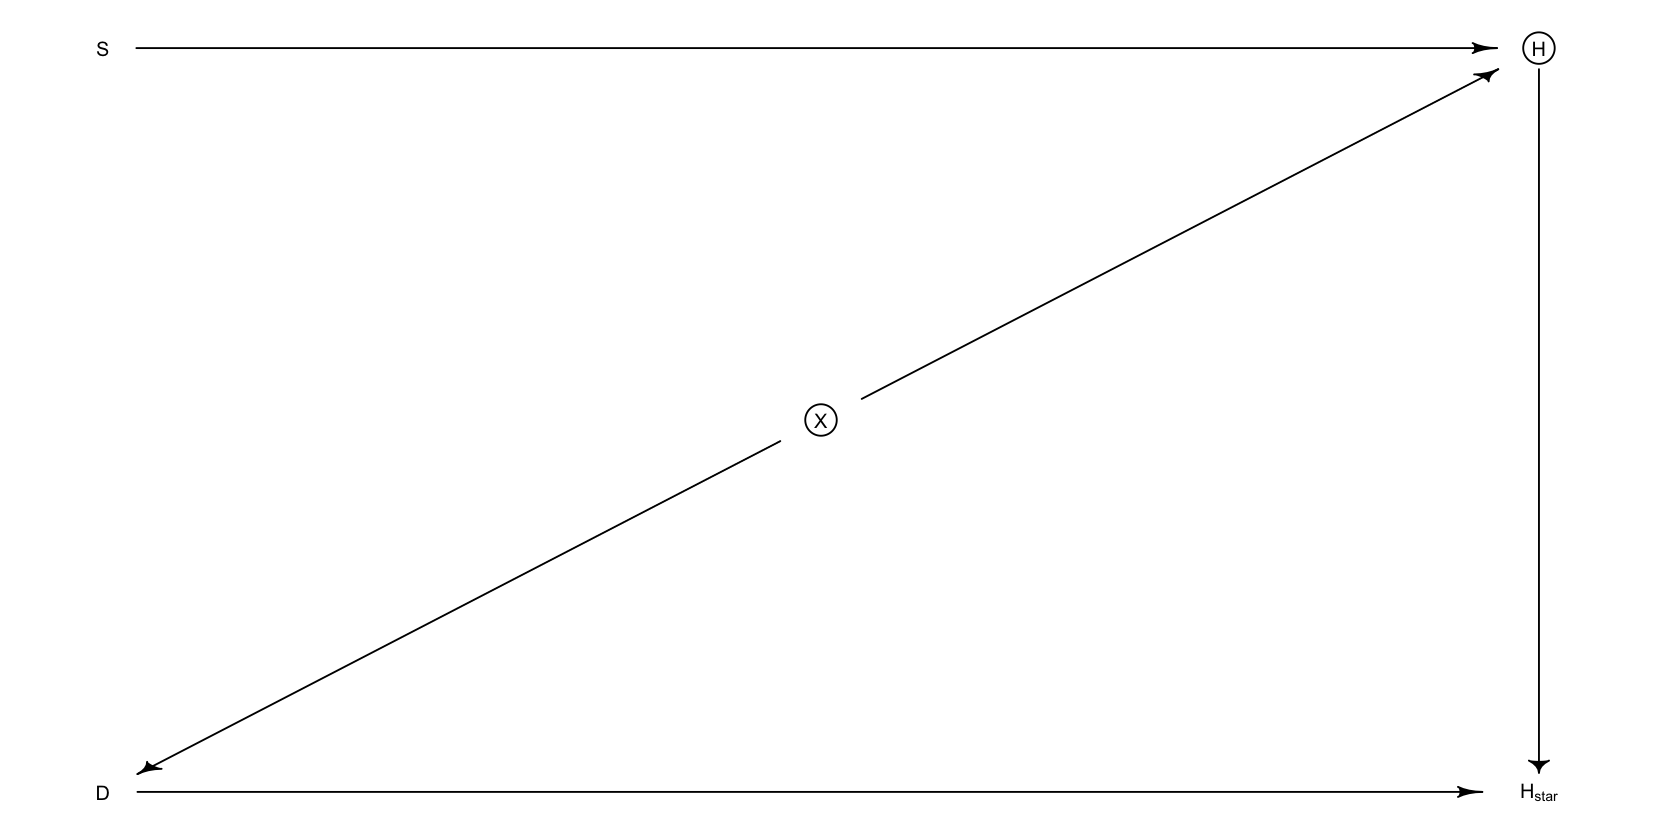

In [80]:
par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
X[latent,pos="0.5,0.5"]
S -> H
H -> H_star
H_star <- D
D <- X -> H
}' )
drawdag(dag)
# c)

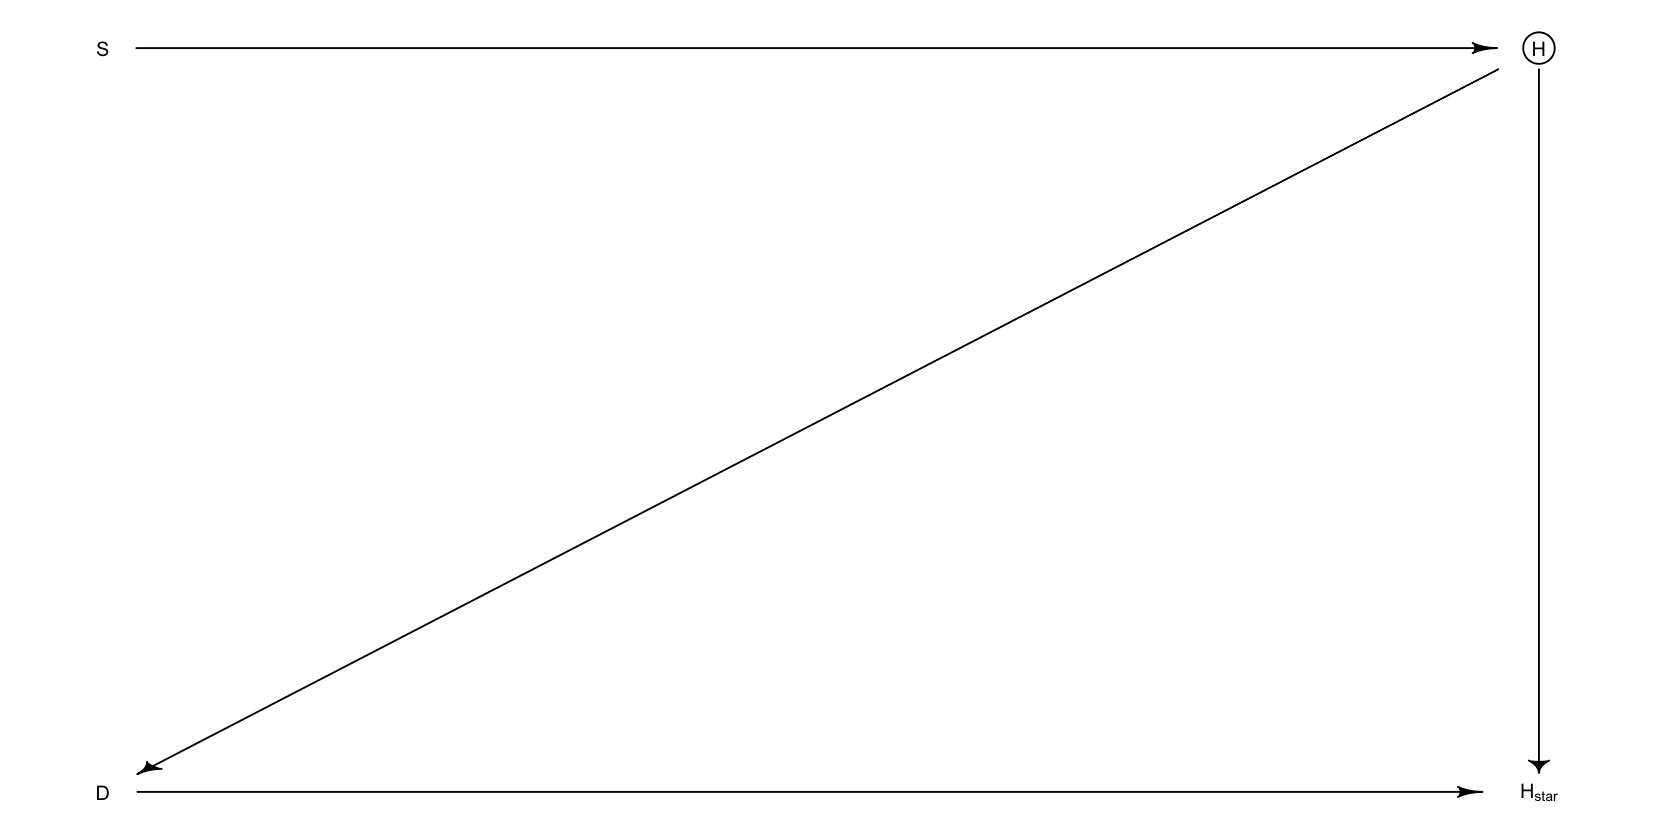

In [81]:
par(bg = 'white')
dag <- dagitty( 'dag {
S[pos="0,0"]
H[latent,pos="1,0"]
H_star[pos="1,1"]
D[pos="0,1"]
S -> H
H -> H_star
H_star <- D
H -> D
}' )
drawdag(dag)
# d)

**15H1** The data in `data(elephants)` are counts of matings observed for bull elephants of differing ages. There is a strong positive relationship between age and matings. owever, age is not always assessesd accurately. First, fit a Poisson model prediting `MATINGS` with `AGE` as a predictor. Second, assume that the observed `AGE` values are uncertain and have a standard error of $\pm 5$ years. Re-estimate the relationship between `MATINGS` and `AGE`, incorporating this measurement error. Compare the inferences of the two models.

In [82]:
data(elephants)
d <- elephants
head(d)

AGE MATINGS
1 27  0      
2 28  1      
3 28  1      
4 28  1      
5 28  3      
6 29  0

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Itera

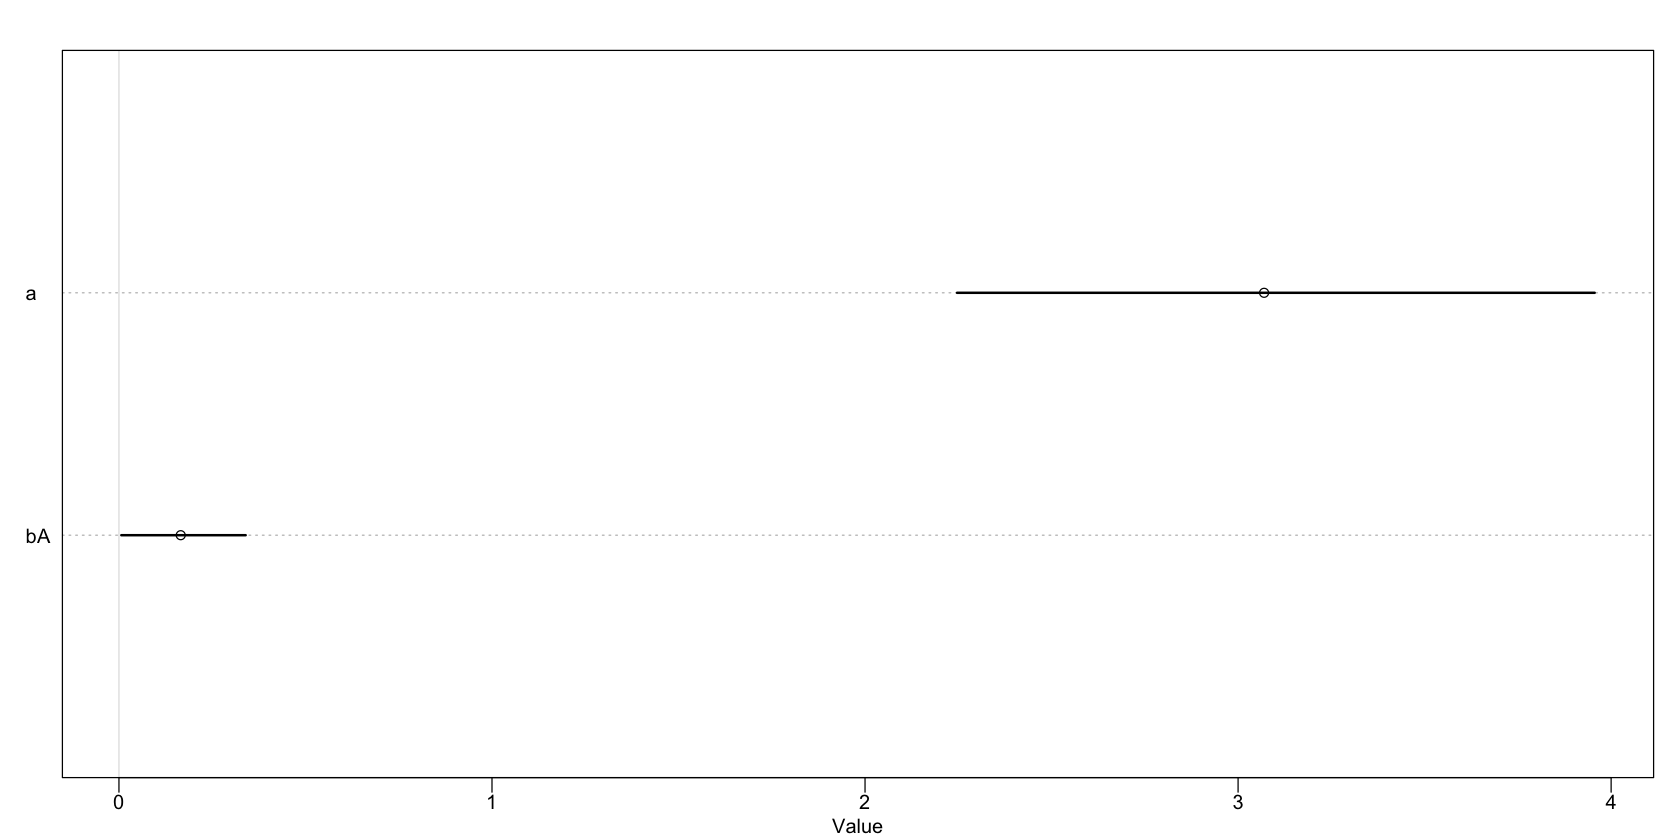

In [83]:
m15h1.data <- list(
    N = nrow(d),
    age = d$AGE - mean(d$AGE),
    matings = d$MATINGS
)
m15h1.model <- "data {
    int N;
    vector[N] age;
    array[N] int<lower=0> matings;
}
parameters {
    real a;
    real bA;
}
model {
    bA ~ normal(1, 1);
    a ~ std_normal();
    vector[N] lambda;
    for (i in 1:N) {
        lambda[i] = inv_logit(a + bA * age[i]);
    }
    matings ~ poisson(lambda);
}
"
m15h1.file <- write_stan_file(m15h1.model)
m15h1.stan_model <- cmdstan_model(m15h1.file)
m15h1.fit <- m15h1.stan_model$sample(data = m15h1.data, chains = 4, parallel_chains = 4, adapt_delta = 0.99)
results <- precis(m15h1.fit)
par(bg = 'white')
plot(results)

In [84]:
print(c(min(m15h1.data$age), max(m15h1.data$age)))
print(mean(m15h1.data$age))
print(sd(m15h1.data$age))

[1] -8.853659 16.146341
[1] 1.213122e-15
[1] 6.578605


Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 3 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 200

41 vector or matrix parameters hidden. Use depth=2 to show them.



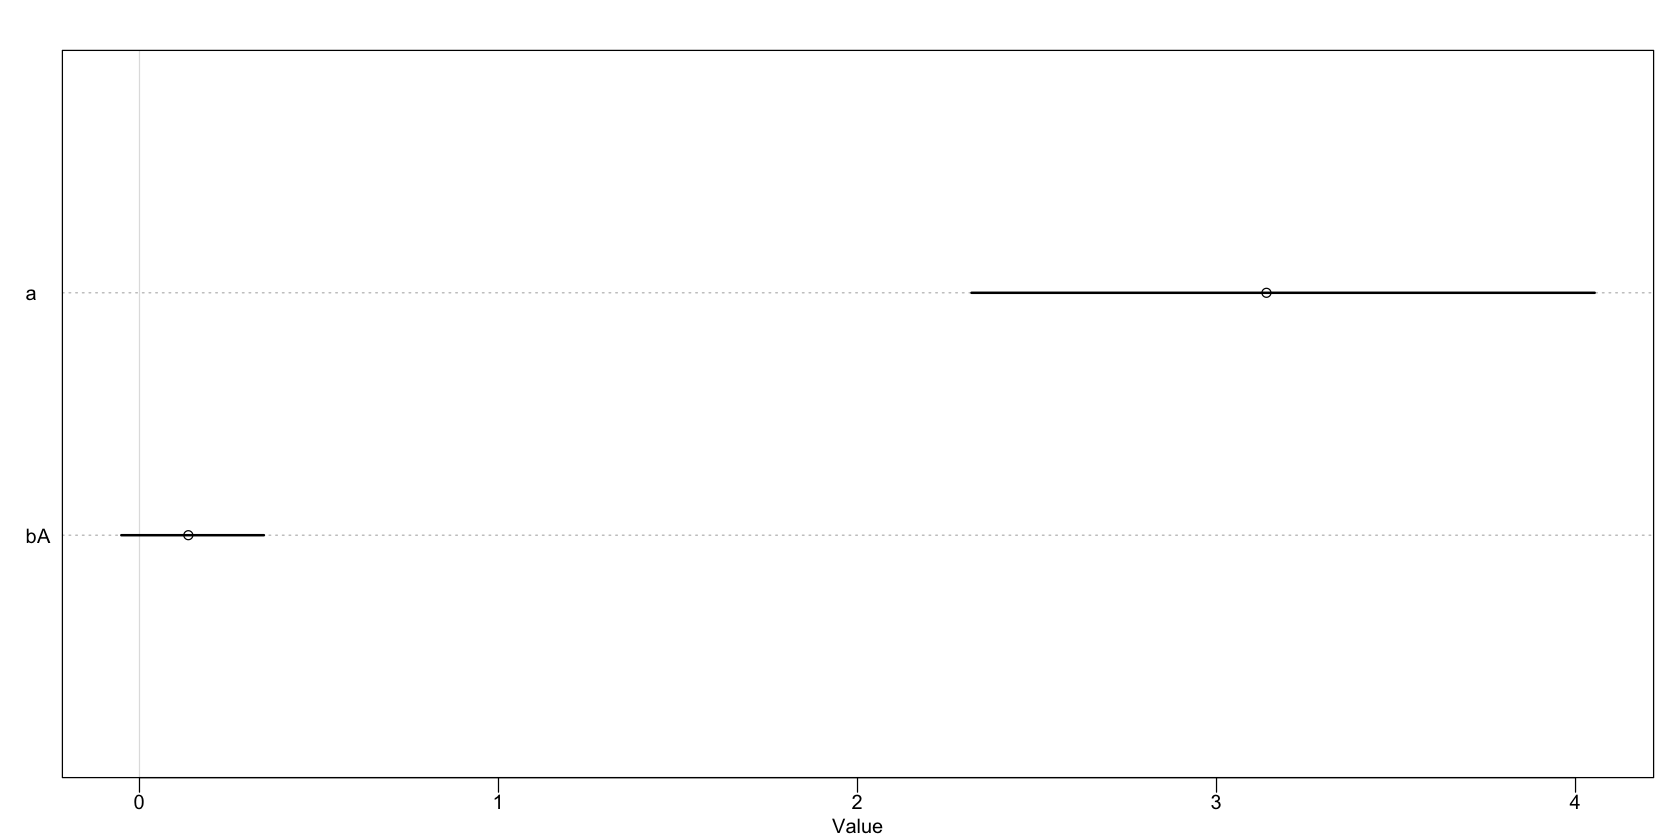

In [85]:
m15h1.error.model <- "data {
    int N;
    vector[N] age;
    array[N] int<lower=0> matings;
}
parameters {
    vector[N] real_age;
    real a;
    real bA;
}
model {
    real_age ~ normal(0, 7); // roughly the distribution of ages in the sample
    age ~ normal(real_age, 5);
    bA ~ std_normal();
    a ~ std_normal();
    vector[N] lambda;
    for (i in 1:N) {
        lambda[i] = inv_logit(a + bA * real_age[i]);
    }
    matings ~ poisson(lambda);
}
"
m15h1.error.file <- write_stan_file(m15h1.error.model)
m15h1.error.stan_model <- cmdstan_model(m15h1.error.file)
m15h1.error.fit <- m15h1.error.stan_model$sample(data = m15h1.data, chains = 4, parallel_chains = 4, adapt_delta = 0.9999)
error_results <- precis(m15h1.error.fit)
par(bg = 'white')
plot(error_results)

In [86]:
m15h1.no_error_params <- as_draws_df(m15h1.fit)
m15h1.error_params <- as_draws_df(m15h1.error.fit)
head(m15h1.no_error_params)

plot_df <- data.frame(
    variable = character(),
    mean = numeric(),
    lower = numeric(),
    upper = numeric(),
    model = character()
)

relevant_params <- c('a', 'bA')

means <- apply(m15h1.no_error_params[, relevant_params], 2, mean)
lower <- apply(m15h1.no_error_params[, relevant_params], 2, function(x) quantile(x, 0.025))
upper <- apply(m15h1.no_error_params[, relevant_params], 2, function(x) quantile(x, 0.975))
plot_df <- rbind(plot_df, data.frame(
    variable = relevant_params,
    mean = means,
    lower = lower,
    upper = upper,
    model = "No Errors"
))
means <- apply(m15h1.error_params[, relevant_params], 2, mean)
lower <- apply(m15h1.error_params[, relevant_params], 2, function(x) quantile(x, 0.025))
upper <- apply(m15h1.error_params[, relevant_params], 2, function(x) quantile(x, 0.975))
plot_df <- rbind(plot_df, data.frame(
    variable = relevant_params,
    mean = means,
    lower = lower,
    upper = upper,
    model = "Errors"
))
plot_df$variable <- as.factor(plot_df$variable)
plot_df$model <- as.factor(plot_df$model)
plot_df

lp__     a       bA        .chain .iteration .draw
1 -48.9480 3.33737 0.0606445 1      1          1    
2 -48.2968 2.79311 0.1460930 1      2          2    
3 -48.7401 3.20543 0.2534170 1      3          3    
4 -49.0830 3.11544 0.0218830 1      4          4    
5 -48.8007 3.35800 0.0991726 1      5          5    
6 -48.3334 2.74284 0.1656780 1      6          6

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


variable mean      lower       upper     model    
a   a        3.0697082  2.08504800 4.1543048 No Errors
bA  bA       0.1655904 -0.01970054 0.3875432 No Errors
a1  a        3.1390456  2.15946050 4.2868730 Errors   
bA1 bA       0.1360421 -0.09001345 0.4087947 Errors

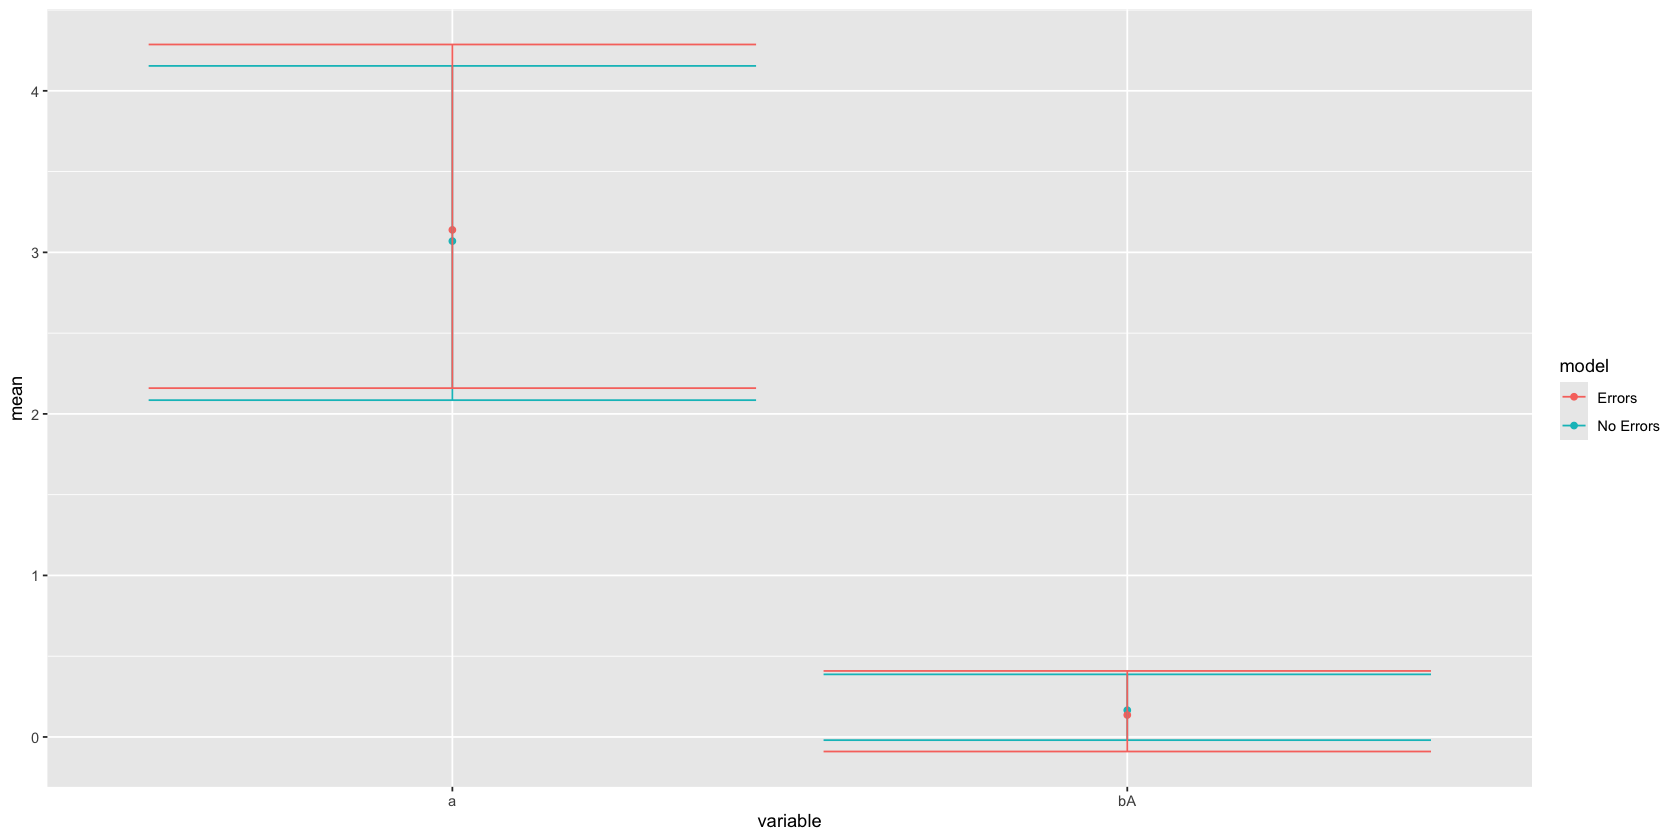

In [87]:
ggplot(plot_df, aes(variable, colour = model)) +
    geom_point(aes(y = mean)) +
    geom_errorbar(aes(ymin = lower, ymax = upper)) +
    scale_x_discrete()

Surprisingly, adding the error in did very little for our estimates. My suspicion is that this has to do with the fact that we're adding symmetric error to each point, so what we should be seeing is less a change in the mean of the estimates for the parameters and more an increase in the spread of those parameters. There is a slight increase in the credible interval for each of them, but it's much less than I would have expected.

**15H2** Repeat the model fitting problem above, now increasing the assumed standard error on `AGE`. How large does the standard error need to be before the posterior mean for the coefficient on `AGE` reaches 0?

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 200

41 vector or matrix parameters hidden. Use depth=2 to show them.



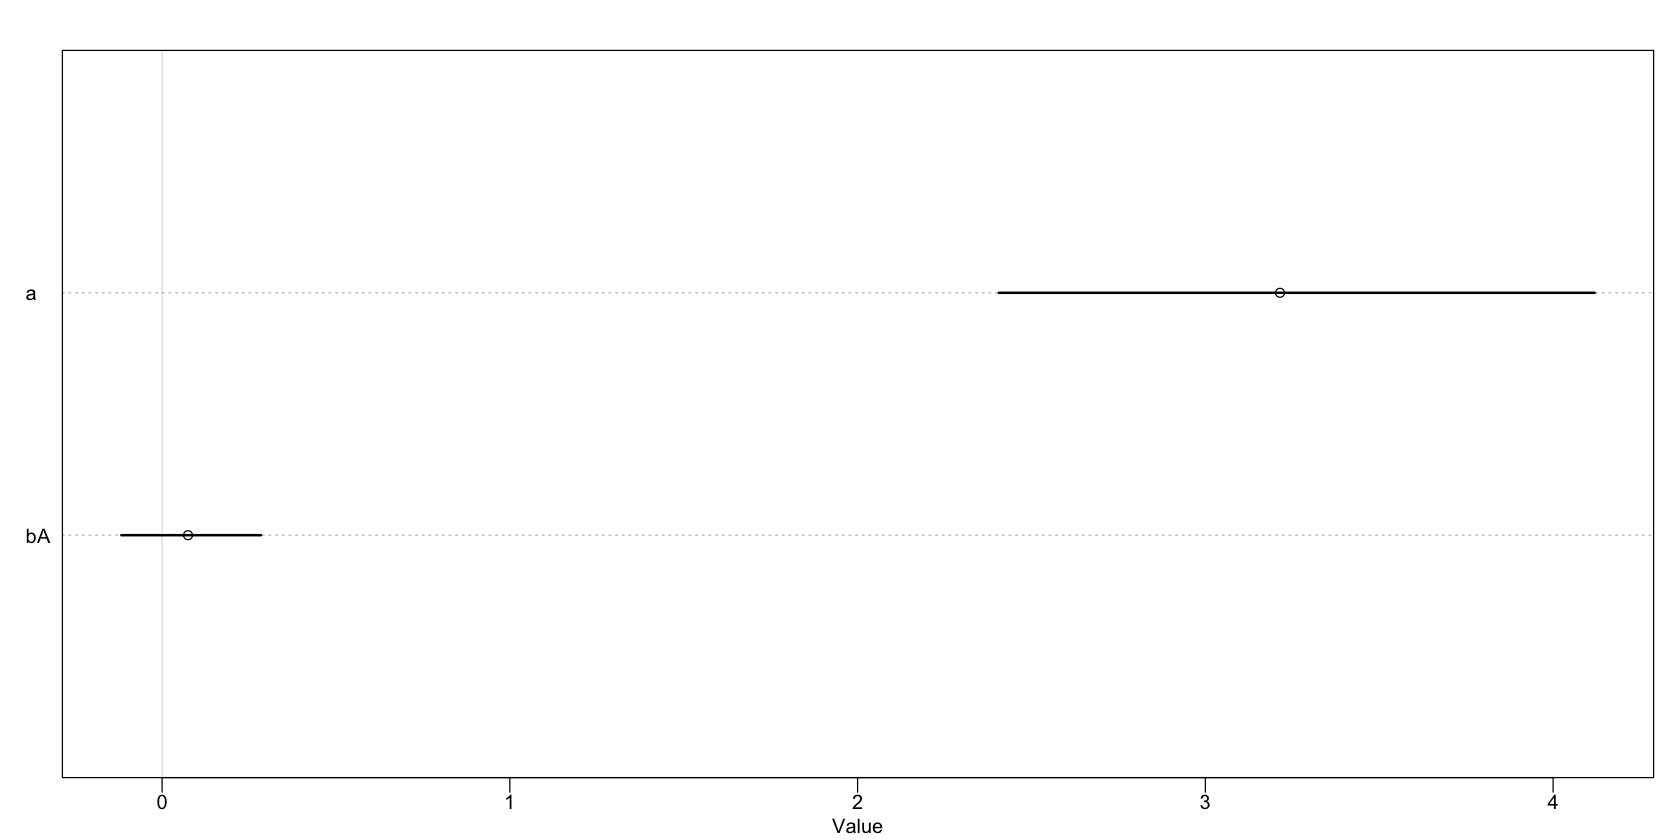

In [88]:
m15h2.model <- "data {
    int N;
    vector[N] age;
    array[N] int<lower=0> matings;
}
parameters {
    vector[N] real_age;
    real a;
    real bA;
}
model {
    real_age ~ normal(0, 7); // roughly the distribution of ages in the sample
    age ~ normal(real_age, 10);
    bA ~ std_normal();
    a ~ std_normal();
    vector[N] lambda;
    for (i in 1:N) {
        lambda[i] = inv_logit(a + bA * real_age[i]);
    }
    matings ~ poisson(lambda);
}
"
m15h2.file <- write_stan_file(m15h2.model)
m15h2.stan_model <- cmdstan_model(m15h2.file)
m15h2.fit <- m15h2.stan_model$sample(data = m15h1.data, chains = 4, parallel_chains = 4, adapt_delta = 0.9999)
error_results <- precis(m15h2.fit)
par(bg = 'white')
plot(error_results)

Increasing the standard error to 10 makes it overlap (although it was pretty close even with the standard error of 5 earlier).

**15H3** The fact that information flows in all directions among parameters sometimes leads to rather unintuitive conclusions. Here's an example from missing data imputation, in which imputation of a single datum reverses the direction of an inferred relationship. use the data

In [89]:
set.seed(100)
x <- c(rnorm(10), NA)
y <- c(rnorm(10, x), 100)
d <- list(x = x, y = y)

The data comprise 11 cases, one of which has a missing predictor value. You can quickly confirm that a regression of `y` on `x` for only the complete cases indicates a strong posibitve relationship between the two variables. But now fit this model, imputing the one missing value for `x`:

$$
\begin{align*}
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta x_i \\
x_i &\sim \text{Normal}(0, 1) \\
\alpha &\sim \text{Normal}(0, 100) \\
\beta &\sim \text{Normal}(0, 100) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

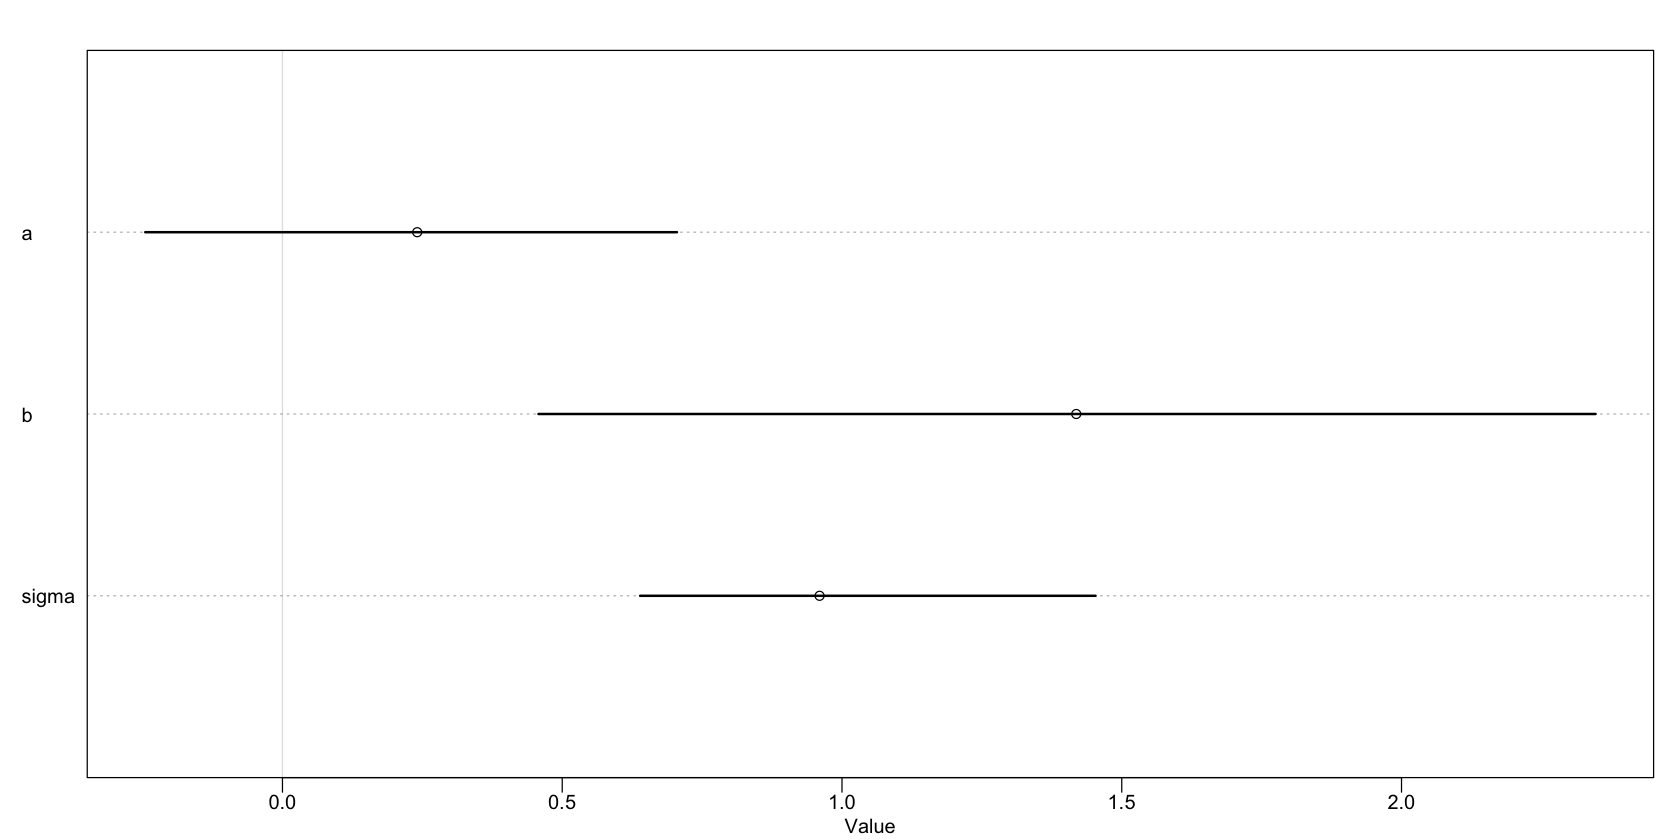

In [90]:
m15h3.full.data <- d
m15h3.complete.data <- list(
    x = d$x[!is.na(d$x)],
    y = d$y[which(!is.na(d$x))]
)

m15h3.model.complete <- ulam(
    alist(
        y ~ normal(mu, sigma),
        mu <- a + b * x,
        a ~ normal(0, 100),
        b ~ normal(0, 100),
        sigma ~ exponential(1)
    ),
    chains = 4,
    data = m15h3.complete.data
)
complete_results <- precis(m15h3.model.complete)
print(complete_results)
par(bg = 'white')
plot(complete_results)

Found 1 NA values in x and attempting imputation.



Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

1 vector or matrix parameters hidden. Use depth=2 to show them.



           mean        sd       5.5%     94.5%     rhat   ess_bulk
a      2.082405  3.058837  -2.557931  6.928459 1.008901 1039.35068
b     10.858983 19.116715 -24.600102 27.090566 1.533046    7.26818
sigma  9.666155  1.951898   6.847452 13.033866 1.037303  140.57686


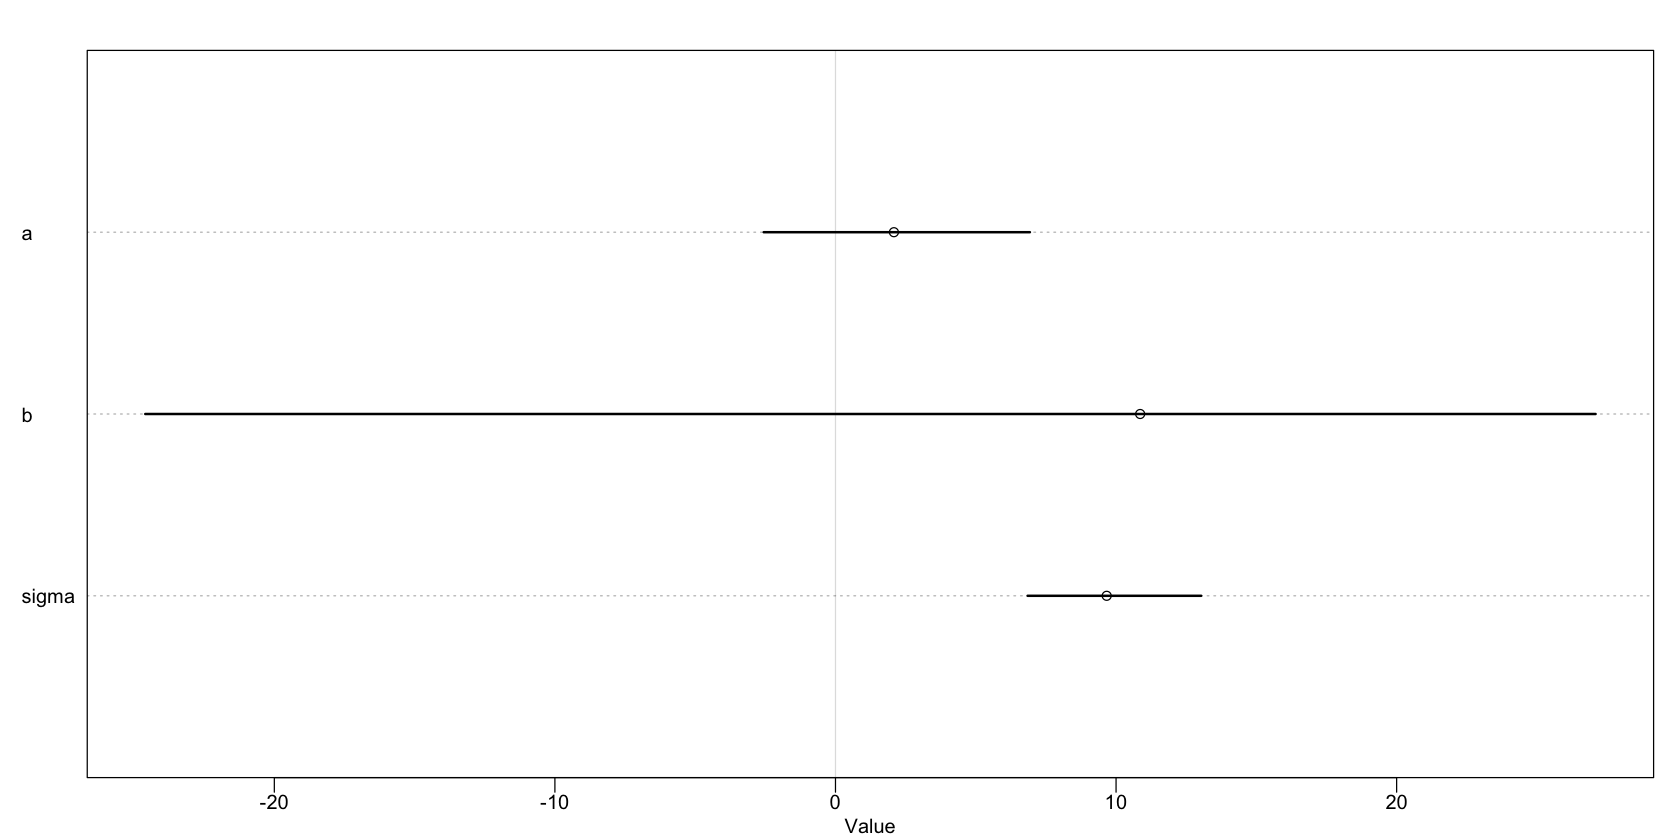

In [91]:
m15h3.model.full <- ulam(
    alist(
        y ~ normal(mu, sigma),
        mu <- a + b * x,
        x ~ normal(0, 1),
        a ~ normal(0, 100),
        b ~ normal(0, 100),
        sigma ~ exponential(1)
    ),
    chains = 4,
    data = m15h3.full.data
)
full_results <- precis(m15h3.model.full)
print(full_results)
par(bg = 'white')
plot(full_results)

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”


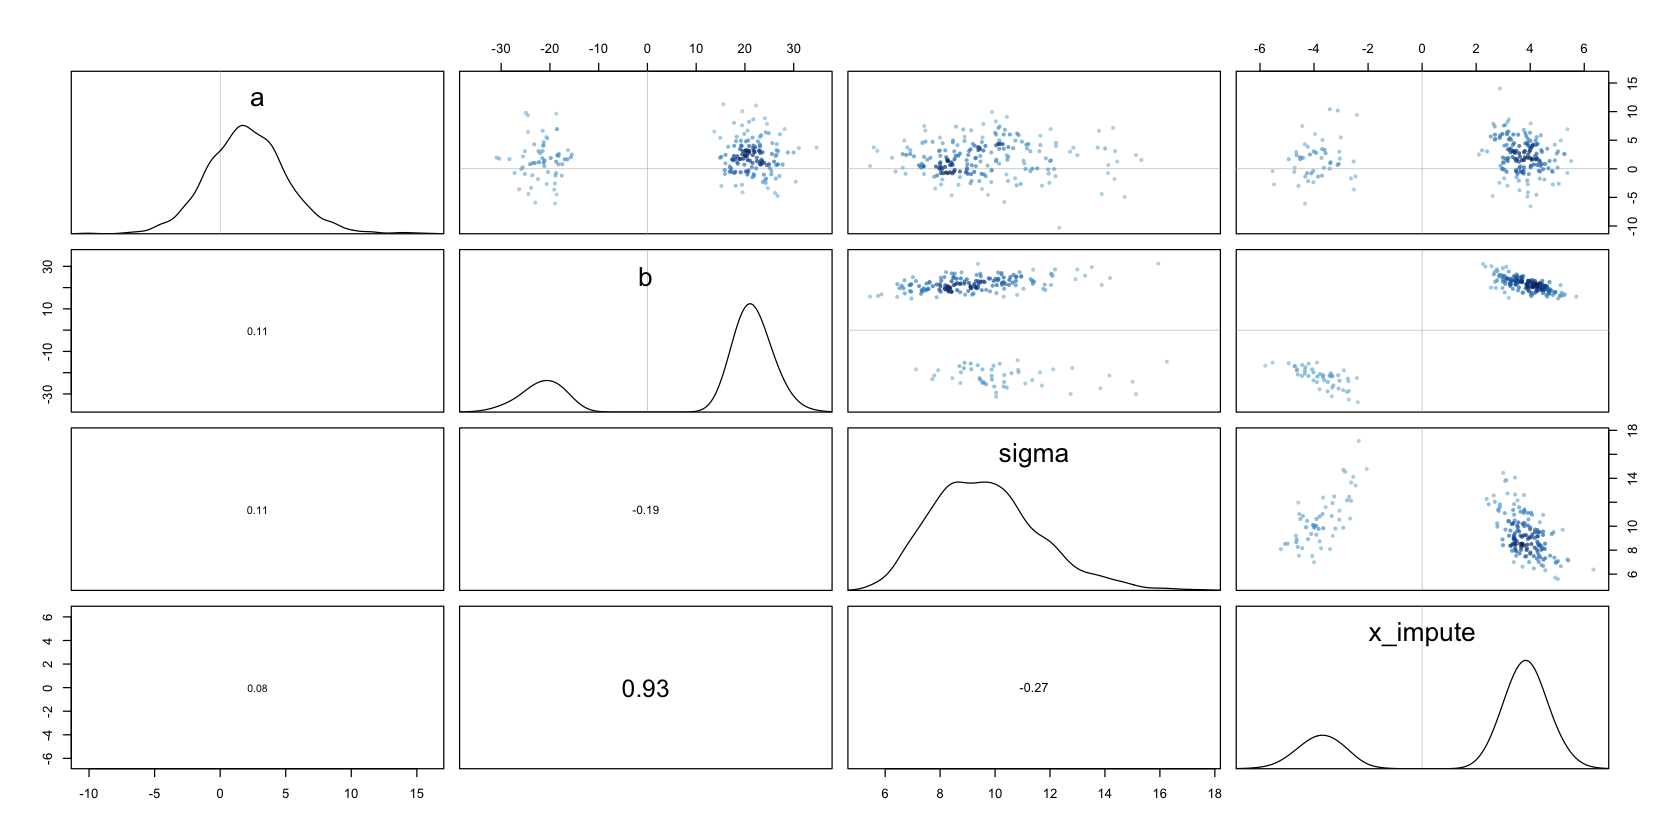

In [92]:
par(bg = 'white')
pairs(m15h3.model.full)

From this, it looks like the distributions that it's producing are heavily bimodal, and from eyeballing the graphs it looks like they roughly fall into a 'positive parameters' and 'negative paramters' camp. Maybe plotting the points will help us see why.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


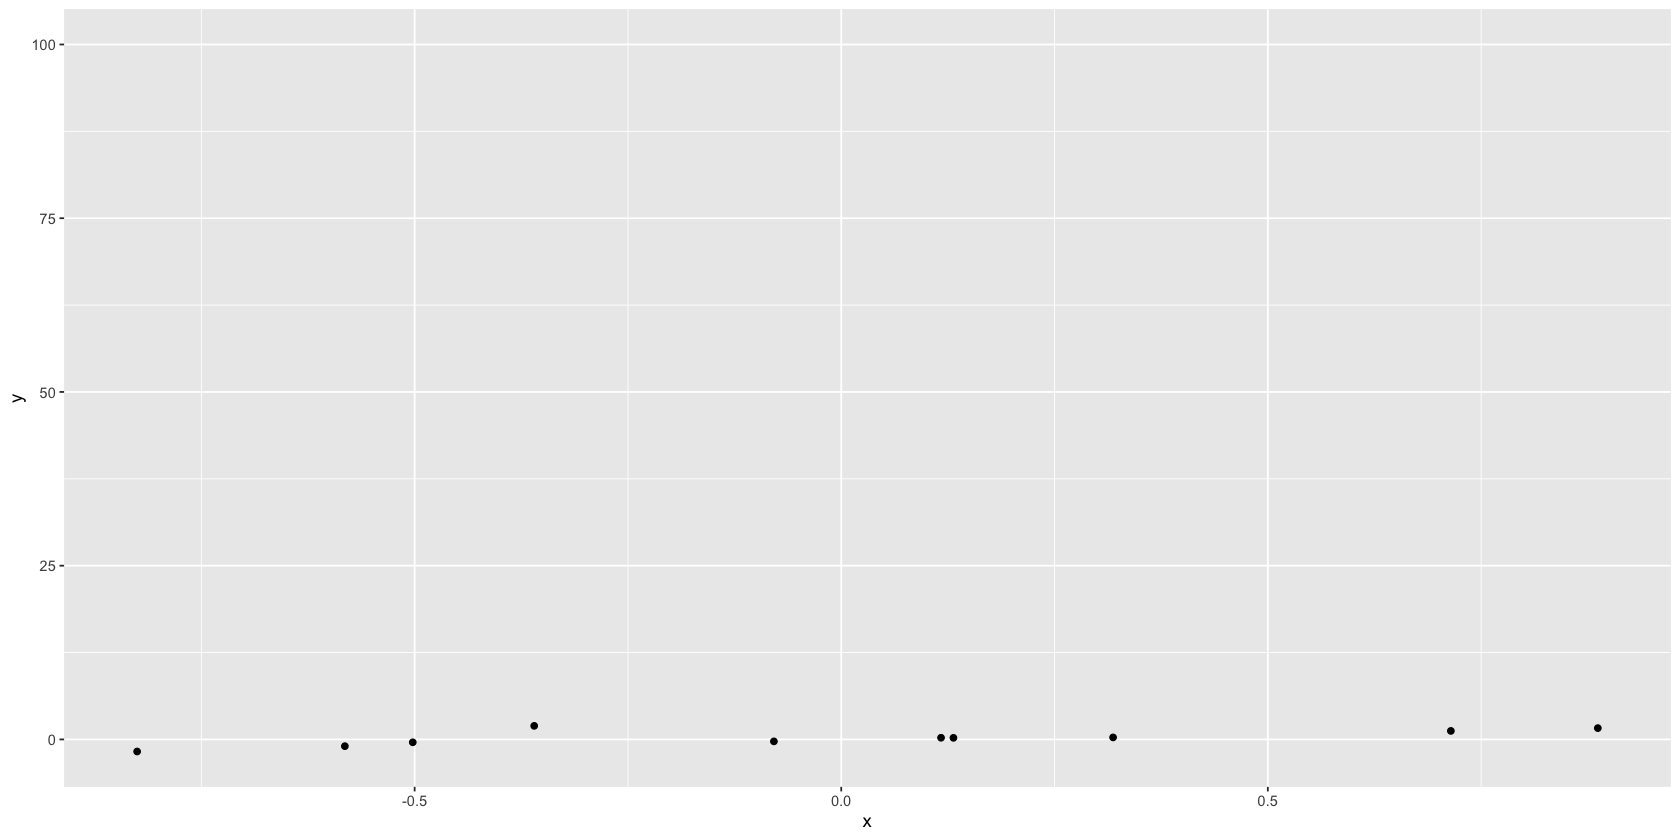

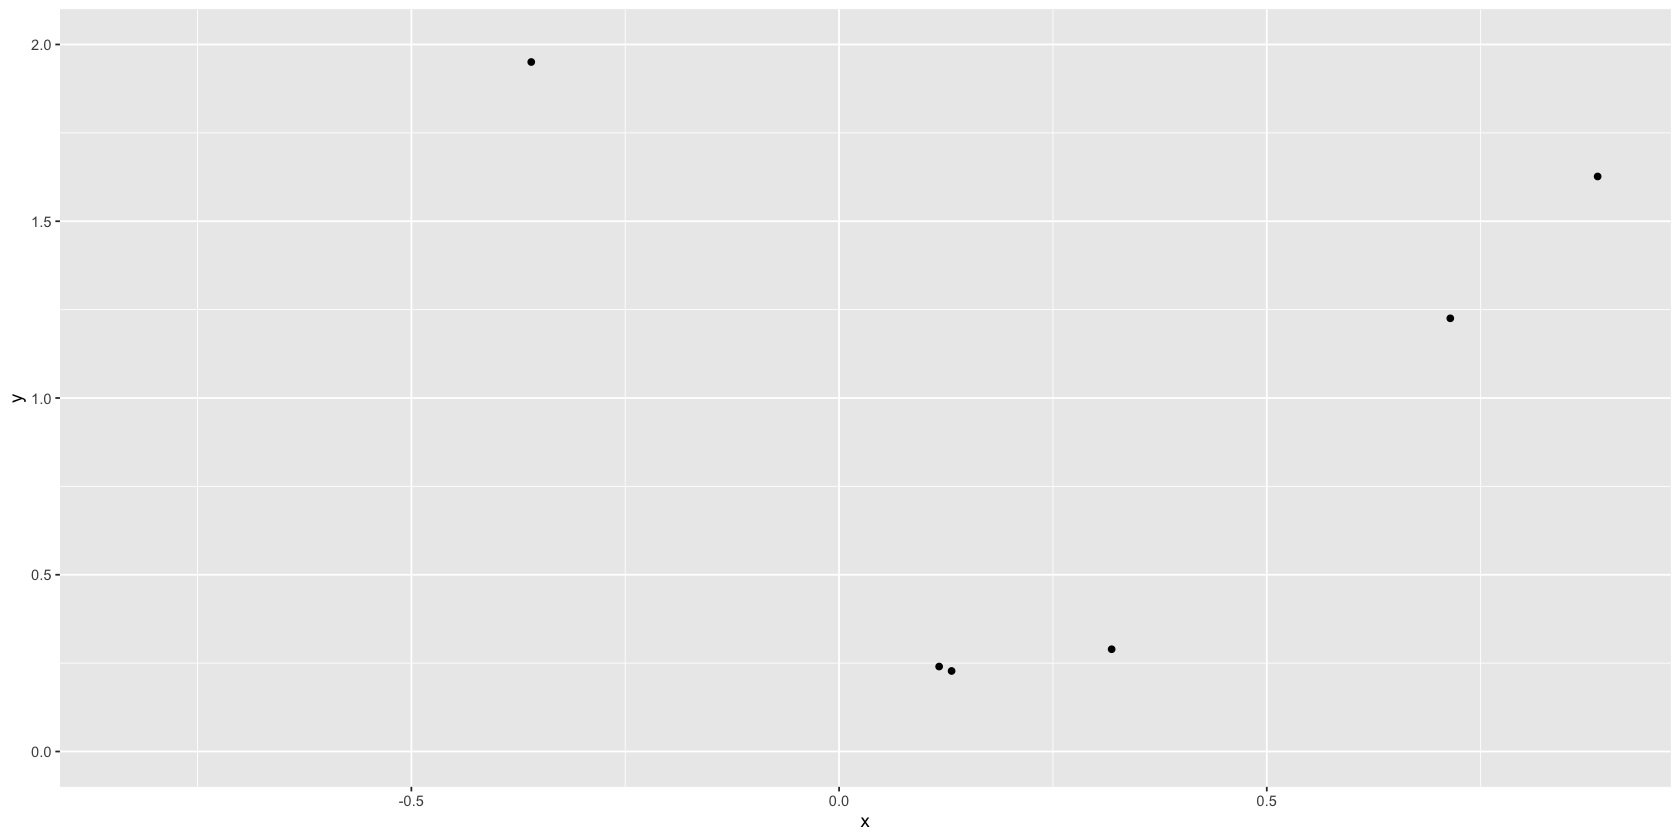

In [93]:
df <- as.data.frame(m15h3.full.data)
print(ggplot(df, aes(x, y)) +
    geom_point())
print(ggplot(df, aes(x, y)) +
    geom_point() +
    coord_cartesian(y = c(0, 2))
    )

This makes this more clear! As we know, the true relationship is positive (excluding the last point). However, that point is such an outlier (at 100) that it is having an enormous effect on the regression. The reason that it's bimodal is because if the imputation puts its $x$ value to the left of the mean, the resulting regression line will be negative, while if the $x$ value is imputed to be on the right of the mean it will be positive.

**15H4** Using `data(Primates301)`, consider the relationship between brain volume (`brain`) and body mass (`body`). These variables are presented as signle values for each species. However, there is always a range of sizes in a species, and some of these measurements are taken from veru small sampes. So these values are measured with some unknown error.

We don't have the raw measurements to work with - that would be best. But we can imagine what might happen if we had them! Suppose error is proportional to the measurement. This makes sense, because larger animals have larger variation. As a consequence, the uncertainty is not uniform across the values, and this ould mean trouble.

Let's make up some standard errors for these measurements, to see what might happen. Load the data and sale the measurements so the maximum is 1 in both cases:

In [3]:
data(Primates301)
d <- Primates301
cc <- complete.cases(d$brain, d$body)
B <- d$brain[cc]
M <- d$body[cc]
B <- B / max(B)
M <- M / max(M)

Making up some standard errors for $B$ and $M$, assuming that error is 10% of the measurement:

In [4]:
Bse <- 0.1 * B
Mse <- 0.1 * M

Let's model these variables using

$$
\begin{align*}
B_i &\sim \text{Log-Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta \log M_i
\end{align*}
$$

This says that the brain volume is a log-normal variable and the mean on the log scale is given by $\mu$. This implies that the expected value of $B$ is

$$
E(B_i | M_i) = e^\alpha \ast M_i^{\beta}
$$

This is a standard allometric scaling relationship - incredibly common in biology.

Ignoring measurement error, the model is

In [5]:
data <- list(B = B, M = M)
m15.1 <- ulam(
    alist(
        B ~ dlnorm(mu, sigma),
        mu <- a + b * log(M),
        a ~ normal(0, 1),
        b ~ normal(0, 1),
        sigma ~ exponential(1)
    ),
    data = data
)
m15.1_results <- precis(m15.1)
print(m15.1_results)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366896dcb9.stan', line 18, column 4 to column 32)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.1 seconds.
           mean         sd      5.5%     94.5%     rhat ess_bulk
a     0.4358840 0.05733761 0.3493070 0.5294393 1.003916 150.2835
b     0.7853774 0.01403768 0.7639739 0.8083444 1.012118 158.7767
sigma 0.2927683 0.01548131 0.2706639 0.3185607 1.001278 199.1171


Your job is to add the measurement errors to this model. Use the divorce / marriage example in the chapter as a guide. It might help to initialize the unobserved true values of $B$ and $M$ using the observed values by adding a list like this to `ulam`:

In [6]:
start <- list(M_true = data$M, B_true = data$B)

Compare the inference of the measurement error model to those of `m1.1` above. Has anything changed? Why or why not?

In [7]:
error_data <- list(
    B_obs = B,
    M_obs = M,
    Bse = Bse,
    Mse = Mse,
    N = length(B)
)
print(error_data)

$B_obs
  [1] 0.118102062 0.107557962 0.107130499 0.105237446 0.101532762 0.104077188
  [7] 0.120259735 0.112402548 0.042074623 0.033179311 0.034298858 0.011968978
 [13] 0.014085941 0.238198954 0.232540151 0.213914955 0.211390885 0.020070430
 [19] 0.016182547 0.225293627 0.154701081 0.139984123 0.023266228 0.016182547
 [25] 0.014737313 0.014900157 0.008488204 0.133226128 0.135628066 0.148451971
 [31] 0.142162151 0.134528874 0.236997985 0.201661001 0.215746942 0.192724978
 [37] 0.142691392 0.121277505 0.116819671 0.113257476 0.132839375 0.127445193
 [43] 0.133124351 0.134142121 0.151037108 0.145195107 0.125877827 0.134284609
 [49] 0.144787998 0.112117573 0.121236794 0.125083966 0.011826491 0.005292405
 [55] 0.098377674 0.132310135 0.127384127 0.132126936 0.158161500 0.151423861
 [61] 0.150283958 0.152461986 0.148736947 0.091293993 0.198933377 0.042033912
 [67] 0.043662345 0.044985446 0.052455880 0.051702730 0.049891099 0.041056853
 [73] 0.053392228 0.011256539 0.011358316 0.009404197 0.0

In [11]:
# TODO now add in the measurement error
# m15h4.1 <- ulam(
#     alist(
#         B_obs ~ normal(B_true, Bse),
#         vector[N]:B_true ~ dlnorm(mu, sigma),
#         mu <- a + b * log(M_true[i]),
#         vector[N]:M_obs ~ normal(M_true, Mse),
#         vector[N]:M_true ~ normal(0.5, 0.1), # prior for the true mass (standardized)
#         a ~ normal(0, 1),
#         b ~ normal(0, 1),
#         sigma ~ exponential(1)
#     ),
#     data = error_data,
#     start = list(
#         M_true = error_data$M_obs, 
#         B_true = error_data$B_obs
#     ),
#     constraints = list(mu = "lower=0")
# )
# precis(m15h4.1)
m15h4.1_specification <- "data {
    int N;
    vector[N] M_obs;
    vector[N] B_obs;
}
parameters {
    real a;
    real b;
    real sigma;
}
model {
    a ~ std_normal();
    b ~ std_normal();
    sigma ~ exponential(1);
    vector[N] mu = a + b * B_obs;
    M_obs ~ normal(mu, sigma);
    
}"

m15h4.1_file <- write_stan_file(m15h4.1_specification)
m15h4.1_model <- cmdstan_model(m15h4.1_file)
m15h4.1_fit <- m15h4.1_model$sample(
    data = error_data,
    chains = 4
)

Running MCMC with 4 sequential chains...



Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: exponential_lpdf: Random variable is -0.0119484, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 1 Exception: exponential_lpdf: Random variable is -0.0119484, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: exponential_lpdf: Random variable is -0.0767342, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 1 Exception: exponential_lpdf: Random variable is -0.0767342, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc000

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Ch

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -48.7378, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -47.7047, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highl

Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 2 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 2 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 2 Iteration: 1

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: exponential_lpdf: Random variable is -6060.81, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: exponential_lpdf: Random variable is -169.17, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly

Chain 2 finished in 0.1 seconds.


Chain 3 Rejecting initial value:

Chain 3   Error evaluating the log probability at the initial value.

Chain 3 Exception: exponential_lpdf: Random variable is -0.610501, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 3 Exception: exponential_lpdf: Random variable is -0.610501, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 3 Rejecting initial value:

Chain 3   Error evaluating the log probability at the initial value.

Chain 3 Exception: exponential_lpdf: Random variable is -1.26449, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 3 Exception: exponential_lpdf: Random variable is -1.26449, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/

Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 3 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 3 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 3 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 3 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 3 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 3 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 3 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 3 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Ch

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -36.1614, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -35.6854, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highl

Chain 3 finished in 0.1 seconds.
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 4 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 4 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 4 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 4 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 4 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 4 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 4 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 4 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 4 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 4 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 4 Iteration: 1

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.0487959, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.136773, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366d4ab4dc.stan', line 14, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for hi

Chain 4 finished in 0.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.9 seconds.



mean        sd          5.5%        94.5%       rhat     ess_bulk
a     -0.03251801 0.004720247 -0.04004234 -0.02494799 1.003554 2046.729
b      0.64340295 0.021883373  0.60711783  0.67839353 1.003182 1705.076
sigma  0.05000410 0.002552618  0.04611666  0.05425737 1.000406 3427.637

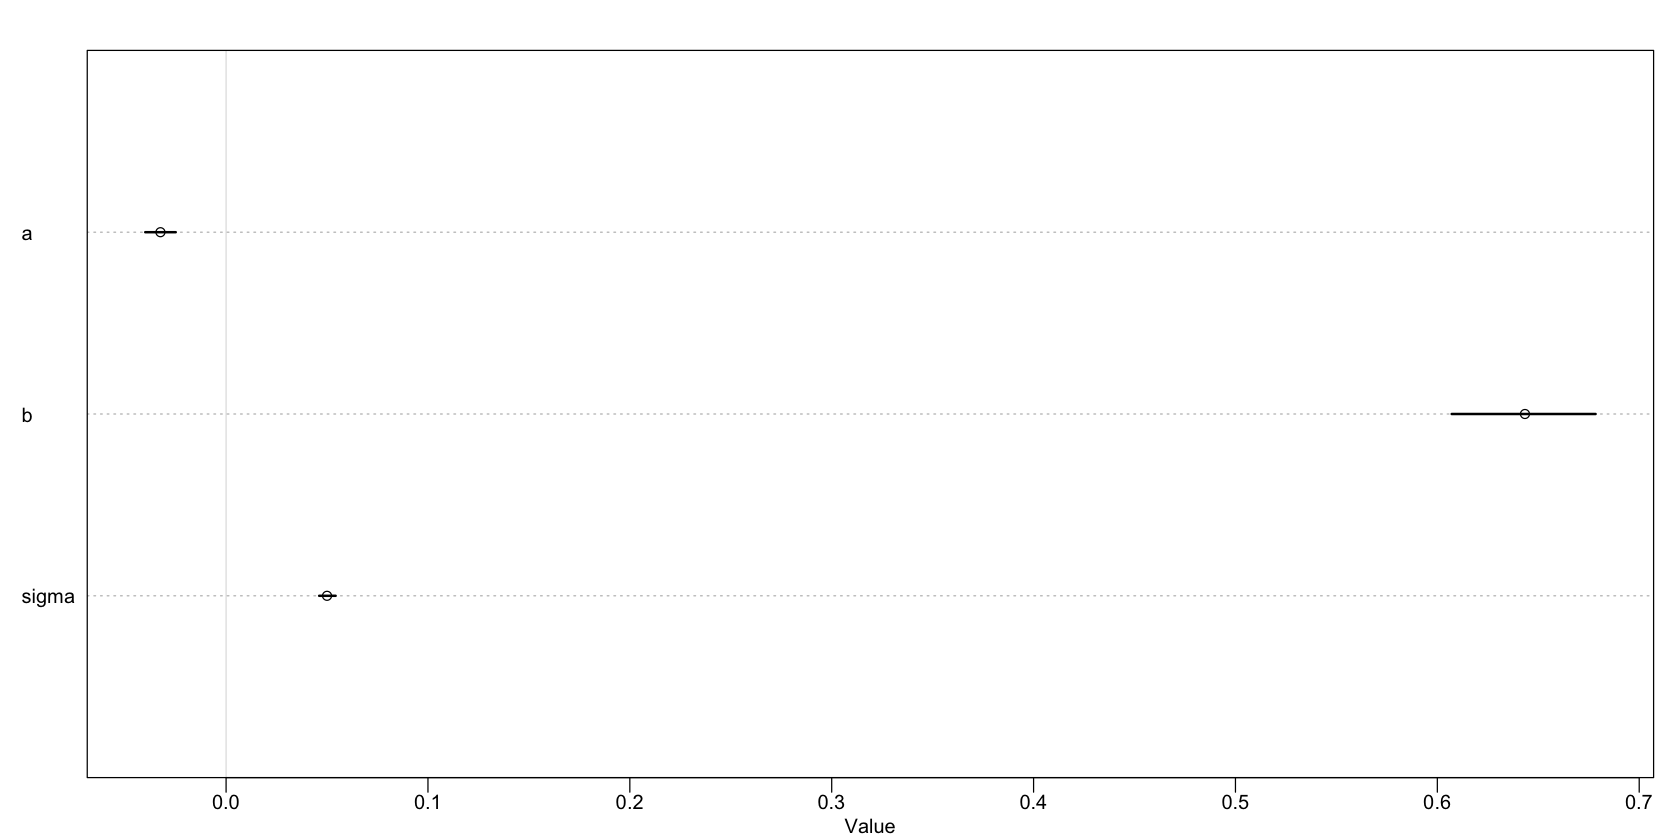

In [13]:
precis(m15h4.1_fit)
par(bg = 'white')
plot(precis(m15h4.1_fit))

Running MCMC with 4 sequential chains...



Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: exponential_lpdf: Random variable is -0.0204848, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 Exception: exponential_lpdf: Random variable is -0.0204848, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)



Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.0434902, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.00525655, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.000567842, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as fo

Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.00479162, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.000132459, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.001072, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.00136106, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for h

Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: exponential_lpdf: Random variable is -0.00355808, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 1 finished in 9.2 seconds.


Chain 2 Rejecting initial value:

Chain 2   Error evaluating the log probability at the initial value.

Chain 2 Exception: exponential_lpdf: Random variable is -1.07967, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 Exception: exponential_lpdf: Random variable is -1.07967, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 Rejecting initial value:

Chain 2   Error evaluating the log probability at the initial value.

Chain 2 Exception: exponential_lpdf: Random variable is -1.50233, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 Exception: exponential_lpdf: Random variable is -1.50233, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rt

Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: exponential_lpdf: Random variable is -0.00937415, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: exponential_lpdf: Random variable is -0.00126505, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for

Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: exponential_lpdf: Random variable is -0.00217085, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: exponential_lpdf: Random variable is -0.0165031, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: exponential_lpdf: Random variable is -0.000967232, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 2 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 2 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 2 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 finished in 9.7 seconds.
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.0376569, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.00111164, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for 

Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.0017248, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.00879044, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for 

Chain 3 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.00144219, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.00166665, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for

Chain 3 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 3 Iteration:  800 / 2000 [ 40%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.000120959, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.000268704, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as f

Chain 3 Iteration:  900 / 2000 [ 45%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.00167747, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: exponential_lpdf: Random variable is -0.000145372, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 3 If this warning occurs sporadically, such as fo

Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 3 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 3 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 3 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 3 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 3 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 finished in 10.7 seconds.
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -7.89801, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -8.81204, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highl

Chain 4 Iteration:  400 / 2000 [ 20%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.0282987, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.0173613, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for h

Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.0013425, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00261444, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for 

Chain 4 Iteration:  600 / 2000 [ 30%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00132538, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00527215, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for

Chain 4 Iteration:  700 / 2000 [ 35%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00210836, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00523896, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for

Chain 4 Iteration:  800 / 2000 [ 40%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00520937, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00752066, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for

Chain 4 Iteration:  900 / 2000 [ 45%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.00135472, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: exponential_lpdf: Random variable is -0.0045775, but must be nonnegative! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpU6bPPG/model-59366e64a14b.stan', line 18, column 4 to column 27)

Chain 4 If this warning occurs sporadically, such as for 

Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 4 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 4 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 4 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 4 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 4 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 4 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 4 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1900 / 2000 [ 95%]  (Sampling) 
Chain 4 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 finished in 9.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 9.8 seconds.
Total execution time: 39.6 seconds.



364 vector or matrix parameters hidden. Use depth=2 to show them.



              mean           sd         5.5%        94.5%     rhat ess_bulk
a     -0.005543841 0.0012970805 -0.007678677 -0.003527537 1.000901 3019.578
b      0.377760175 0.0116827326  0.359639450  0.396675640 1.002791 1959.295
sigma  0.009596452 0.0009469321  0.008152249  0.011165986 1.002617 1853.287


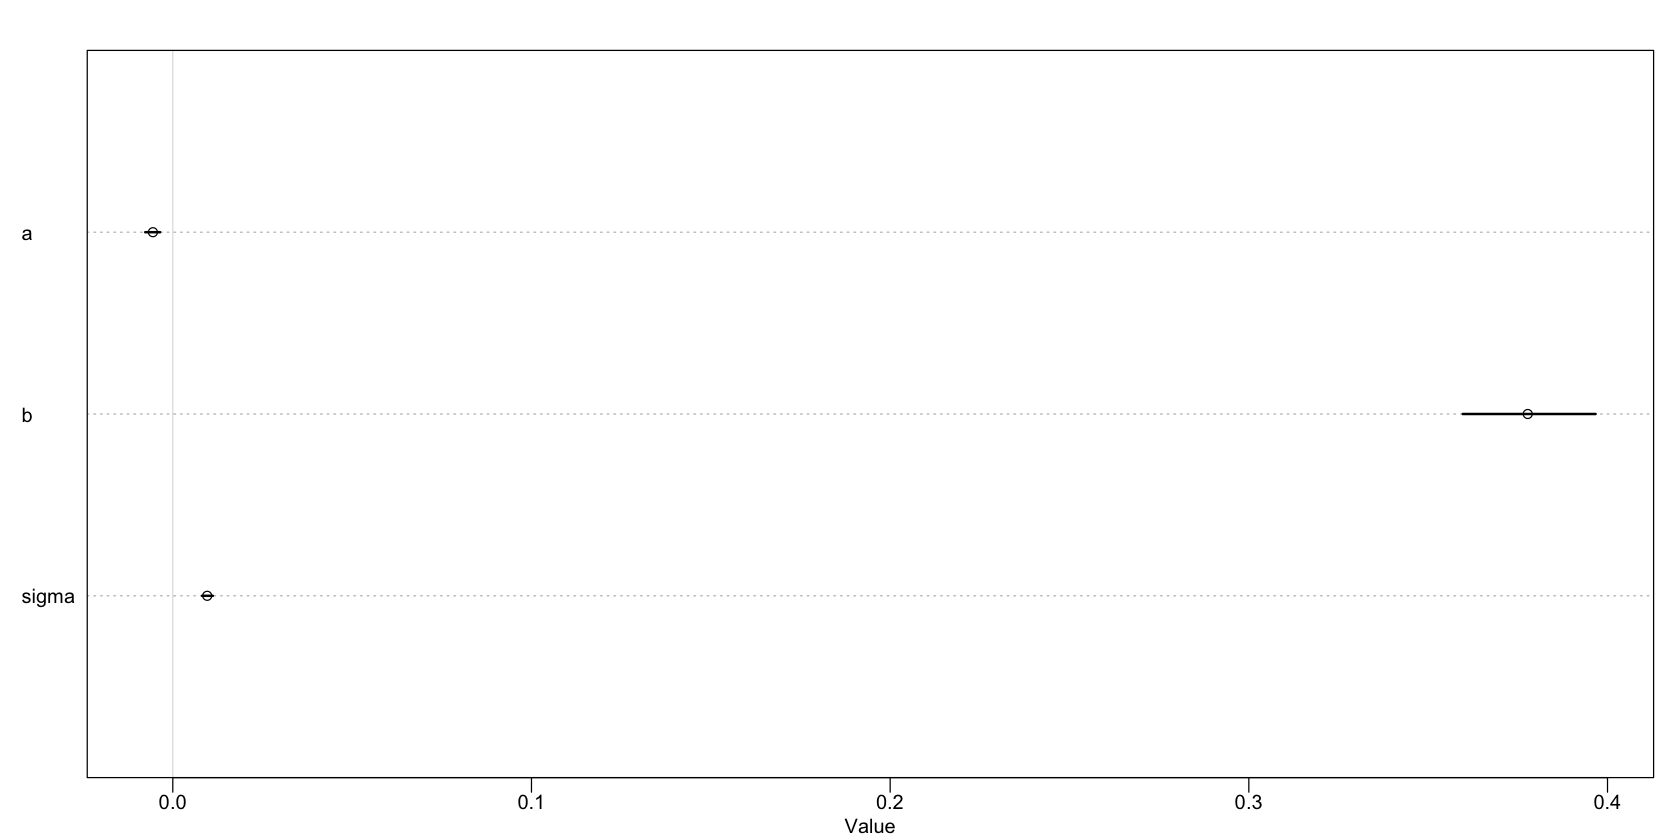

In [14]:
m15h4.2_specification <- "data {
    int N;
    vector[N] M_obs;
    vector[N] Mse;
    vector[N] B_obs;
    vector[N] Bse;
}
parameters {
    real a;
    real b;
    real sigma;
    vector[N] M_true;
    vector[N] B_true;
}
model {
    a ~ std_normal();
    b ~ std_normal();
    sigma ~ exponential(1);
    B_true ~ normal(0.5, 0.2);
    B_obs ~ normal(B_true, Bse);
    vector[N] mu = a + b * B_true;
    M_true ~ normal(mu, sigma);
    M_obs ~ normal(M_true, Mse);
}"

m15h4.2_file <- write_stan_file(m15h4.2_specification)
m15h4.2_model <- cmdstan_model(m15h4.2_file)
m15h4.2_fit <- m15h4.2_model$sample(
    data = error_data,
    chains = 4
)

m15h4.2_results <- precis(m15h4.2_fit)
print(m15h4.2_results)
par(bg = 'white')
plot(m15h4.2_results)

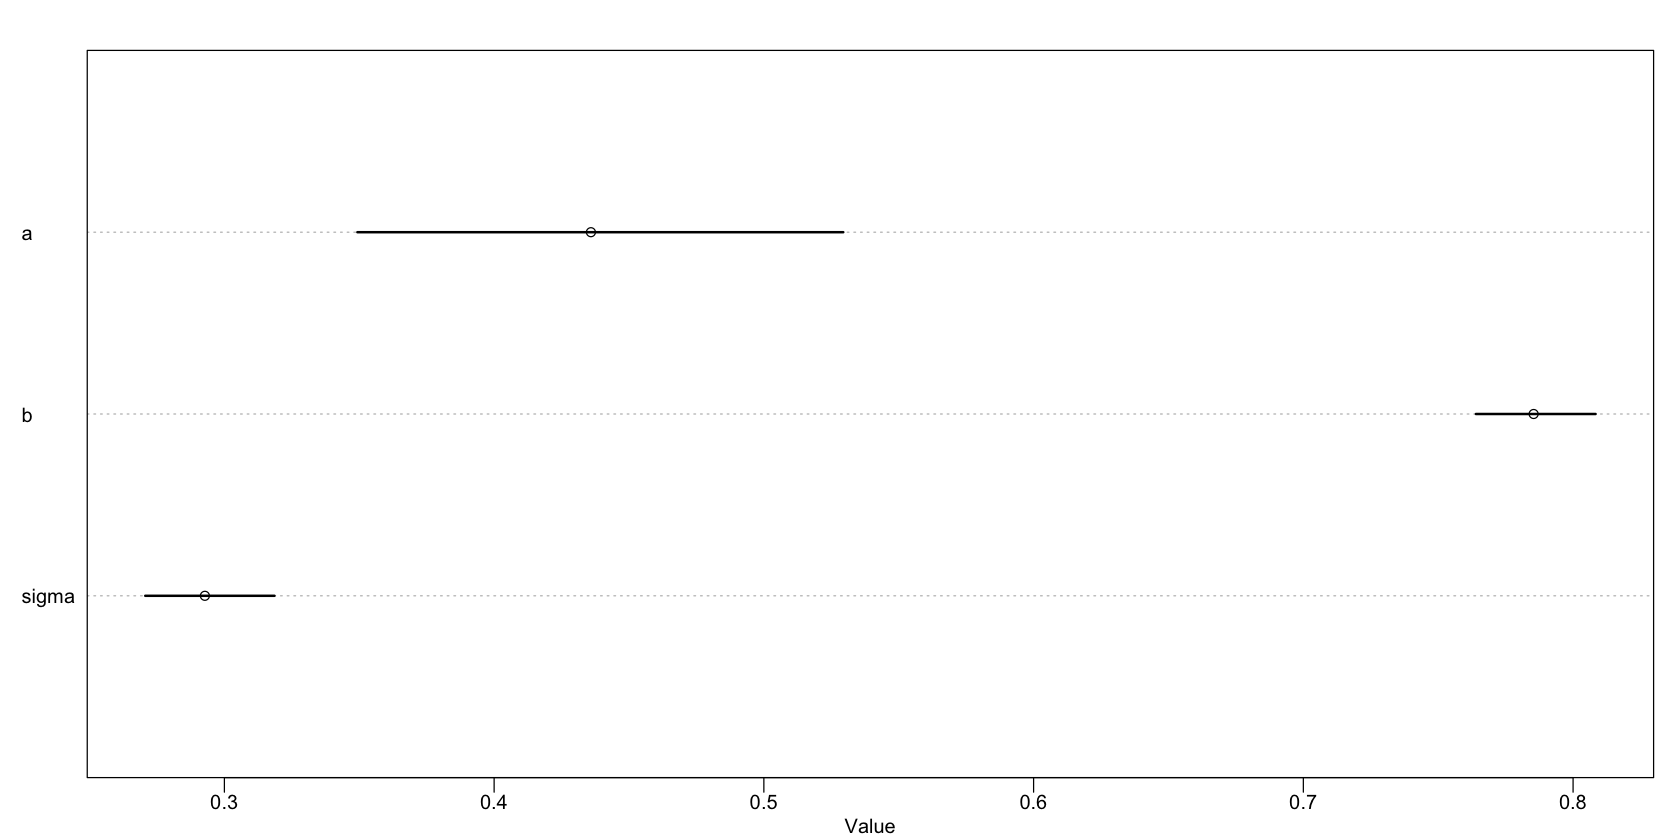

In [15]:
par(bg = 'white')
plot(m15.1_results)

According to this, we are seeing changes in each of the parameters:
- `sigma` went from very close to zero and little uncertainty to about 0.3 with a fair degree of uncertainty. This is unsurprising, given that we've added a bunch of uncertainty into the model.
- The intercept `a` went from being very slightly negative to comparatively large (0.45) and quite uncertain. 
- The slope `b` more than doubled, going from about 0.35 to about 0.8.

By adding the uncertainty into the measured and observed variables, in general it made things less certain, bumping up the range of the credible intervals for each of the parameters. For the parameters involved with the linear model (`a` and `b`), it looks like the model increased both of them.

**15H5** Now consider missing values - this dataset is lousy with them. You can ignore measurement error in this problem. Let's get a quick idea of the missing values by counting them in each variable:

In [3]:
data(Primates301)
d <- Primates301
colSums(is.na(d))

name               genus             species          subspecies 
                  0                   0                   0                 267 
             spp_id            genus_id     social_learning     research_effort 
                  0                   0                  98                 115 
              brain                body          group_size           gestation 
                117                  63                 114                 161 
            weaning           longevity        sex_maturity maternal_investment 
                185                 181                 194                 197

We'll continue to focus on just brain and body, to stave off insanity. Consider only those species with measured body masses:

In [4]:
cc <- complete.cases(d$body)
M <- d$body[cc]
M <- M / max(M)
B <- d$brain[cc]
B <- B / max(B, na.rm = TRUE)
print(length(B))
print(sum(is.na(B)))

[1] 238
[1] 56


You should end up with 238 species and 56 missing brain values among them.

First, consier whether there is a pattern to the missing values. Does it look like missing values are associated with particular values of body mass? Draw a [[DAG]] that represents how missingness works in this case. Which type (MCAR, MAR, MNAR) is this?

Second, impute missing values for brain size. It might help to initialize the imputed values to a valid value:

In [5]:
start <- list(B_impute = rep(0.5, 56))

This just helps the chain get started.

Compare the inferences to an analysis that drops all of the missing values. Has anything changed? Why or why not? Hint: consider the density of the data in the rangers where there are missing values. You might want to plot the imputed brain sizes together with the observed values.

**Answer**

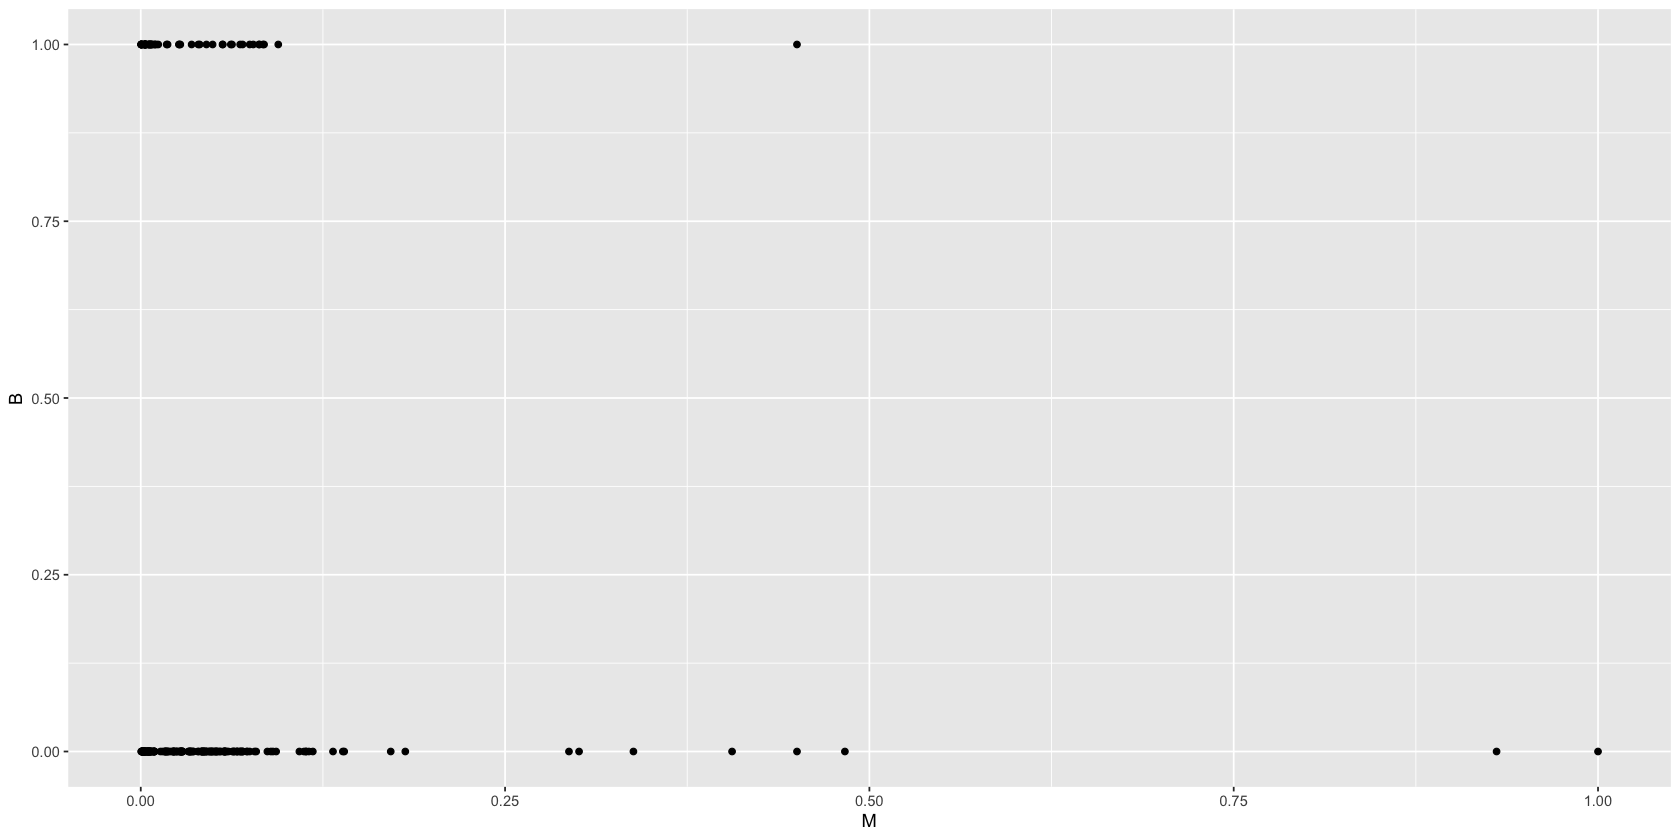

In [6]:
missingness_plot_df <- data.frame(
    M = M,
    B = as.integer(is.na(B))
)

ggplot(missingness_plot_df, aes(M, B)) +
    geom_point()

At first glance it looks like there is more missing data at the lower ends of the mass scale. However, there are also more data there, so it could just be a case of everything being proportional. To test that, let's look at the density of the mass data against the missing brain data.

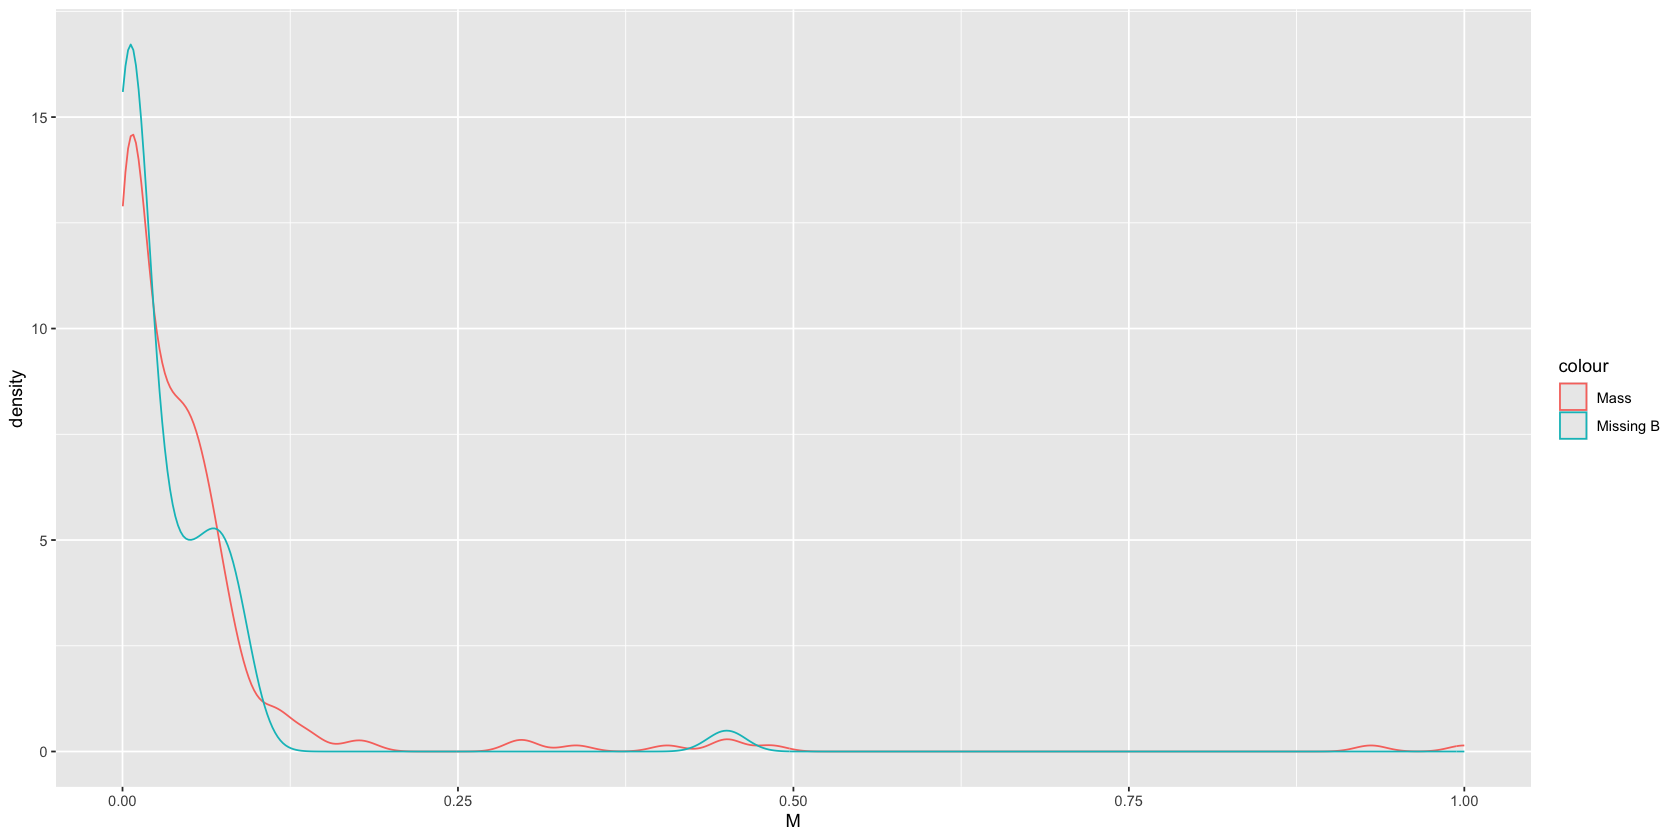

In [7]:
missing_B_M <- M[which(is.na(B))]

ggplot() +
    geom_density(data = data.frame(M = M), mapping = aes(M, colour = "Mass")) +
    geom_density(data = data.frame(missing = missing_B_M), mapping = aes(missing, colour = "Missing B"))

From this it looks like the density of the mass data that we have is basically the same as for the missing brain data, supporting the idea that we are missing brain data roughly in proportion to how many data points we have in total. While there's a slight increase in density of missing data at the lower end of the scale, it doesn't seem to be large enough to denote a real trend.

Since there's no effect of the body mass on the probability of missing data, this is [[Missing Completely at Random]] (MCAR).

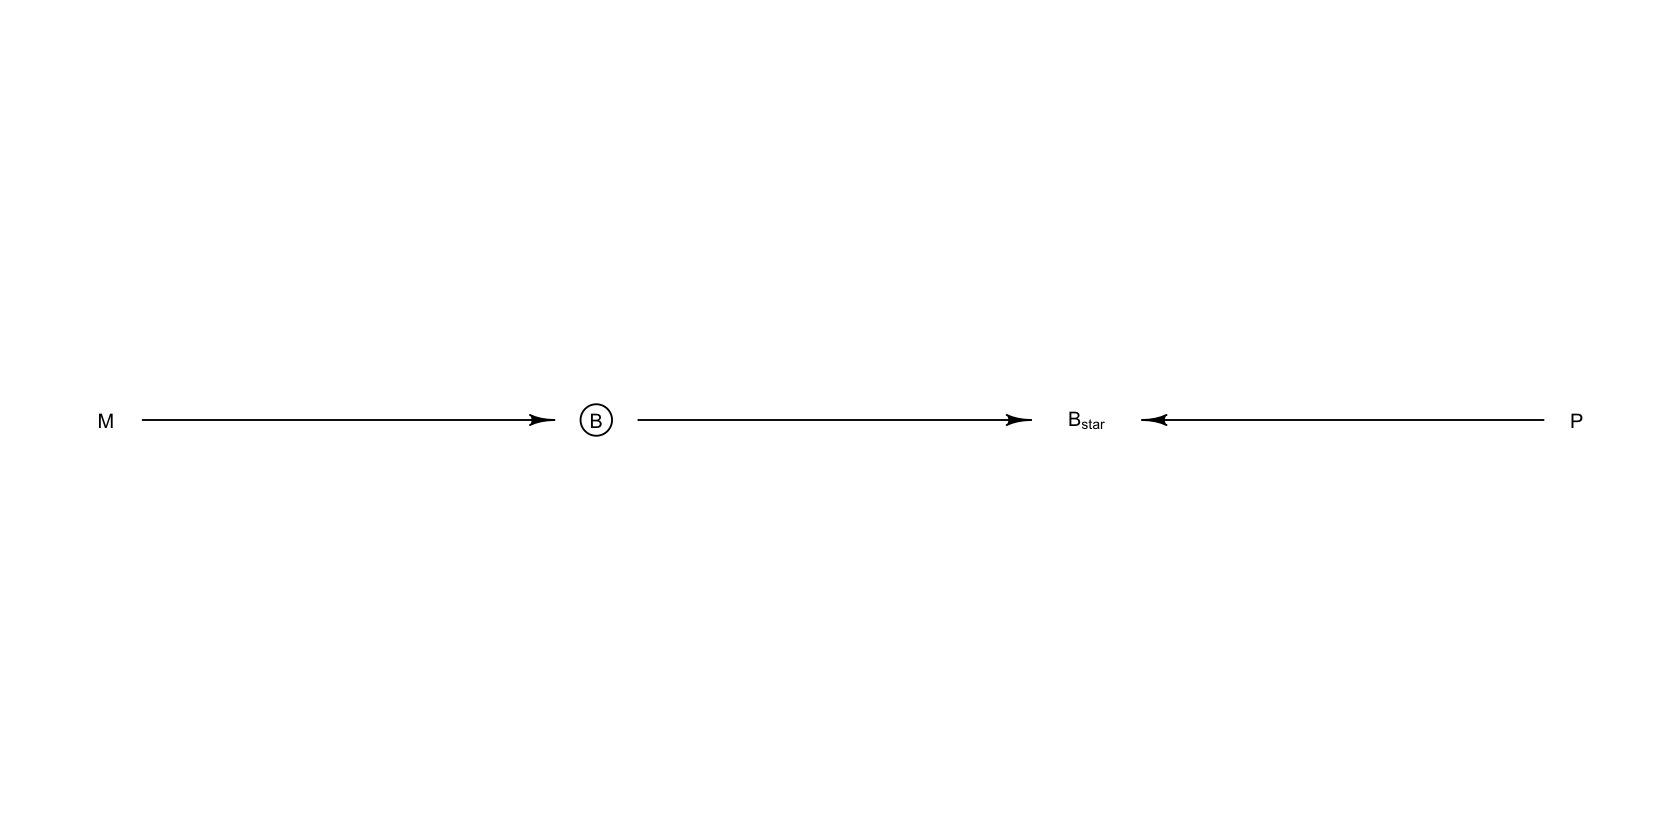

In [8]:
par(bg = 'white')
dag <- dagitty( 'dag {
M[pos="0,0"]
B[latent,pos="1,0"]
B_star[pos="2,0"]
P[pos="3,0"]
M -> B
B -> B_star
B_star <- P
}' )
drawdag(dag)
# a)

Where here 
- `M` is the mass
- `B` is the brain volume
- $B_{\text{star}}$ is the observed brain volumne
- `P` is whatever random process is cauing us to not measure the brain volumes


Warning message:
“Removed 56 rows containing missing values or values outside the scale range
(`geom_point()`).”


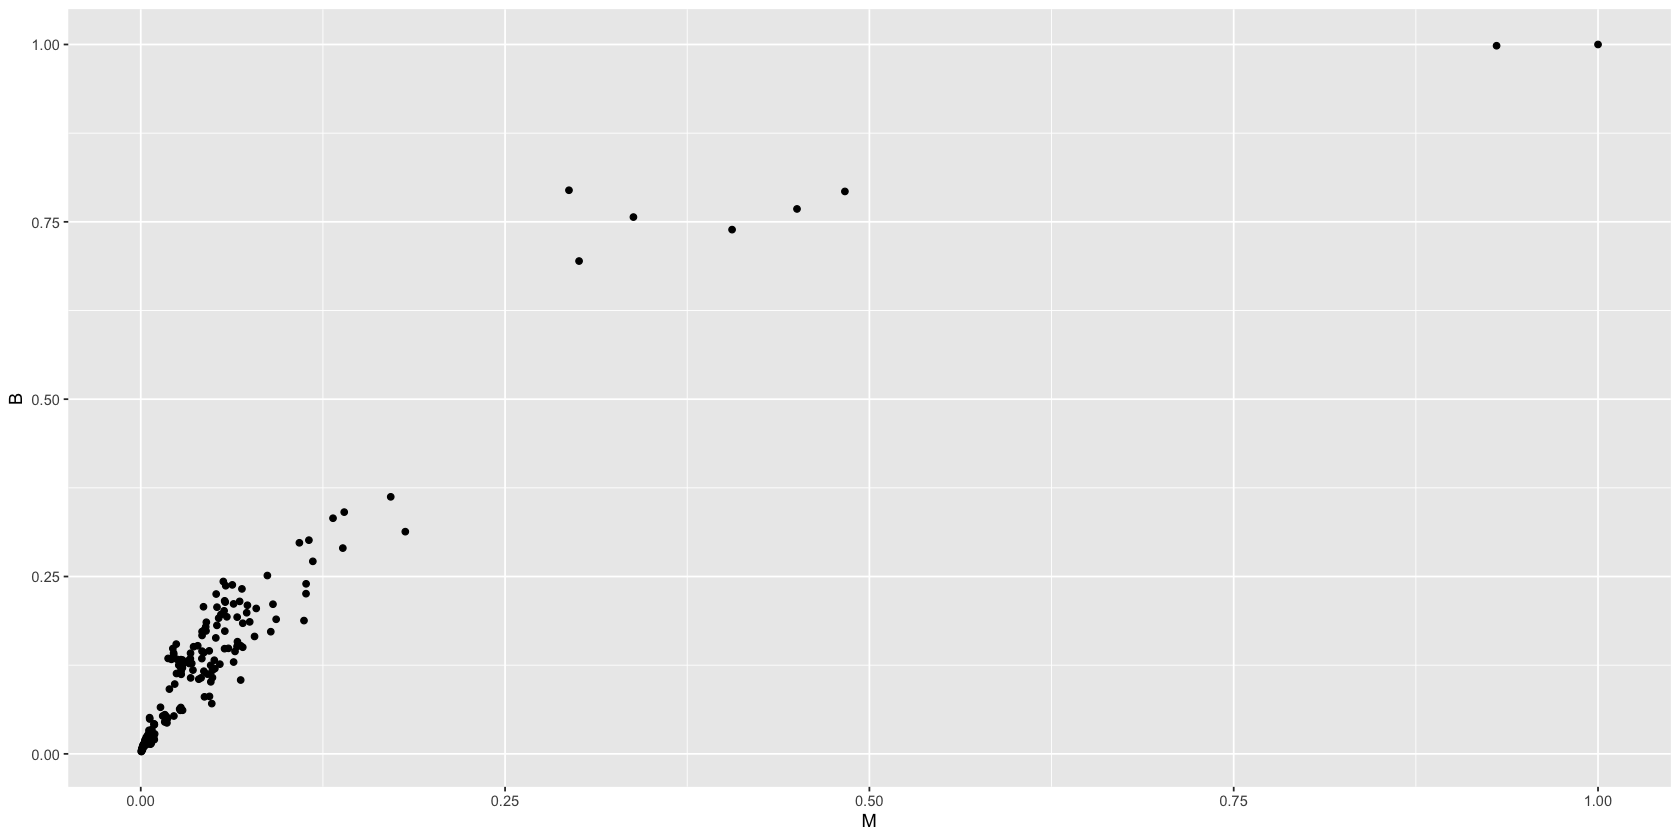

In [9]:
ggplot(data.frame(M = M, B = B), aes(M, B)) +
    geom_point()

In [10]:
B_missidx <- which(is.na(B))
modified_B <- B
modified_B[B_missidx] <- -1 # to avoid issues with NA values in STAN
m15h5.data <- list(B = modified_B, M = M, N = length(B), B_missidx = B_missidx, N_miss = length(B_missidx))
# print(m15h5.data)
m15h5.model_specification <- "
functions {
    vector merge_missing(array[] int miss_indexes, vector x_obs, vector x_miss) {
        int N = dims(x_obs)[1];
        int N_miss = dims(x_miss)[1];
        vector[N] merged;
        merged = x_obs;
        for (i in 1:N_miss) {
            merged[miss_indexes[i]] = x_miss[i];
        }
        return merged;
    }
}
data {
    int N;
    int N_miss;
    vector<lower=0>[N] M;
    vector[N] B;
    array[N_miss] int B_missidx;
}
parameters {
    real a;
    real b;
    real <lower=1e-3> sigma;
    vector[N_miss] B_impute;
}
model {
    a ~ std_normal();
    b ~ std_normal();
    sigma ~ exponential(1);
    vector[N] mu = a + b * log(M);
    B_impute ~ normal(0.5, 0.2);
    vector[N] B_merge = merge_missing(B_missidx, to_vector(B), B_impute);
    B_merge ~ normal(mu, sigma);
}
"
m15h5.file <- write_stan_file(m15h5.model_specification)
m15h5.model <- cmdstan_model(m15h5.file)
m15h5.fit <- m15h5.model$sample(data = m15h5.data, chains = 4)

Running MCMC with 4 sequential chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Ite

56 vector or matrix parameters hidden. Use depth=2 to show them.



            mean          sd       5.5%      94.5%     rhat ess_bulk
a     0.42424038 0.024938564 0.38528782 0.46385724 1.000968 2275.852
b     0.06479787 0.006068590 0.05499751 0.07454884 1.001689 1782.496
sigma 0.13042731 0.008359368 0.11787807 0.14431105 1.001163 2099.770


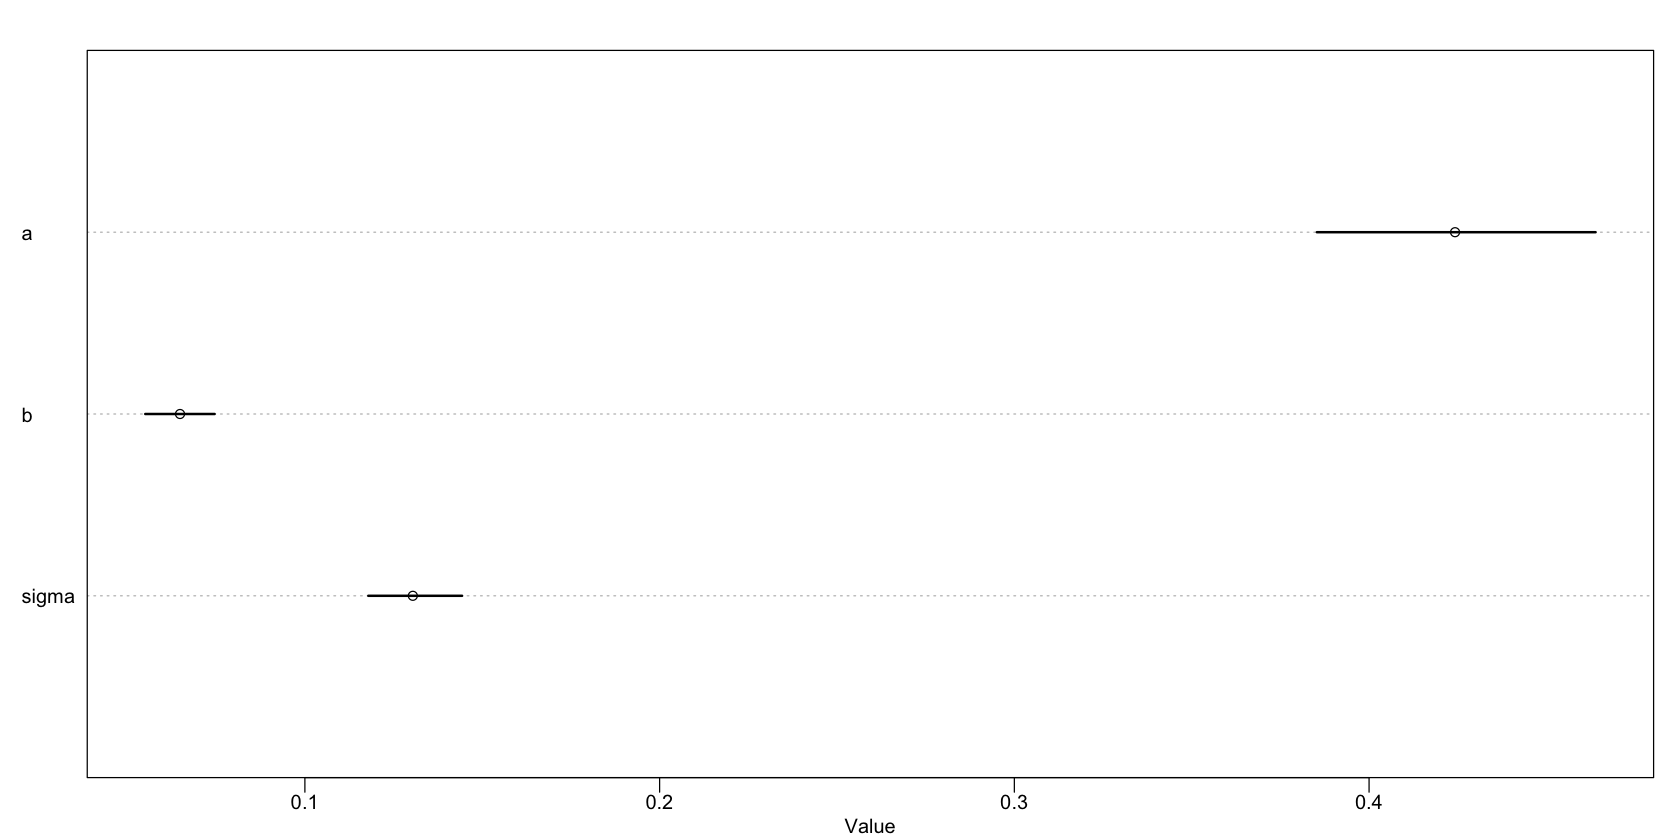

In [11]:
m15h5.result <- precis(m15h5.fit)
print(m15h5.result)
par(bg = 'white')
plot(m15h5.result)

In [12]:
# Complete Cases
B_missidx <- which(is.na(B))
modified_B <- B
modified_B <- modified_B[-B_missidx]
modified_M <- M[-B_missidx]
m15h5.complete_data <- list(B = modified_B, M = modified_M, N = length(modified_B), B_missidx = c(), N_miss = 0)
# print(m15h5.complete_data)
m15h5.complete_fit <- m15h5.model$sample(data = m15h5.complete_data, chains = 4)

Running MCMC with 4 sequential chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Ite

            mean          sd       5.5%      94.5%     rhat ess_bulk
a     0.46093734 0.022107692 0.42538199 0.49574482 1.003111 1564.888
b     0.08325155 0.005335234 0.07460111 0.09159707 1.002127 1533.860
sigma 0.11055590 0.006109892 0.10148989 0.12036550 1.004509 1999.346


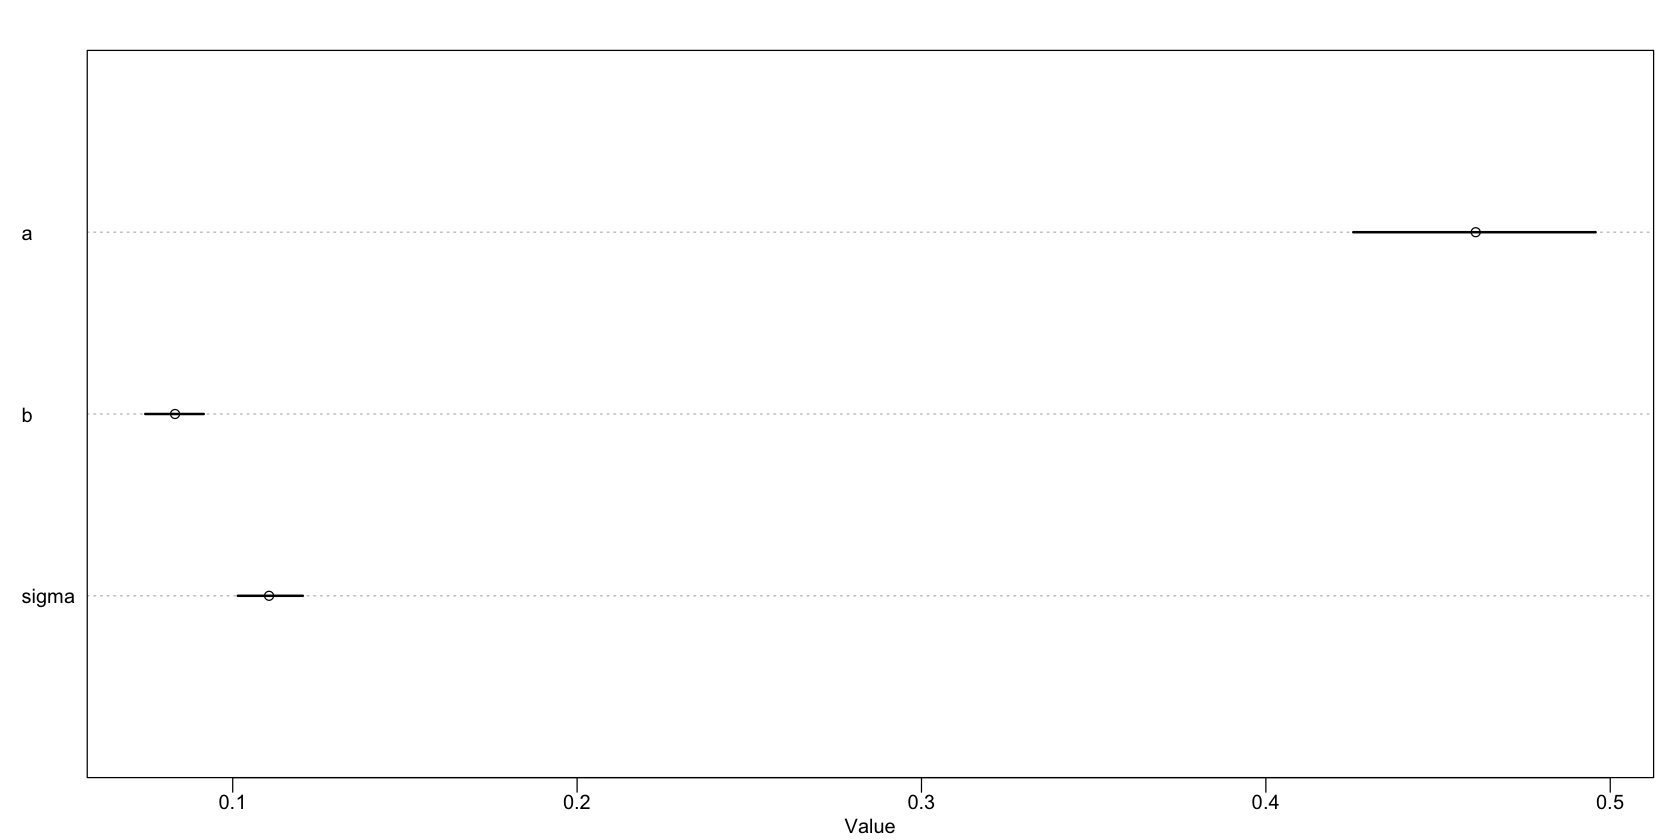

In [13]:
m15h5.complete_results <- precis(m15h5.complete_fit)
print(m15h5.complete_results)
par(bg = 'white')
plot(m15h5.complete_results)

Going from the complete cases to the imputed ones,
- The intercept `a` decreased (0.46 -> 0.42)
- The coefficient `b` decreased (0.8 -> 0.6)
- `sigma` increased from 0.11 -> 0.13

So overall we are getting a flatter curve and more uncertainty in the imputed curve.

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Removed 56 rows containing missing values or values outside the scale range
(`geom_point()`).”


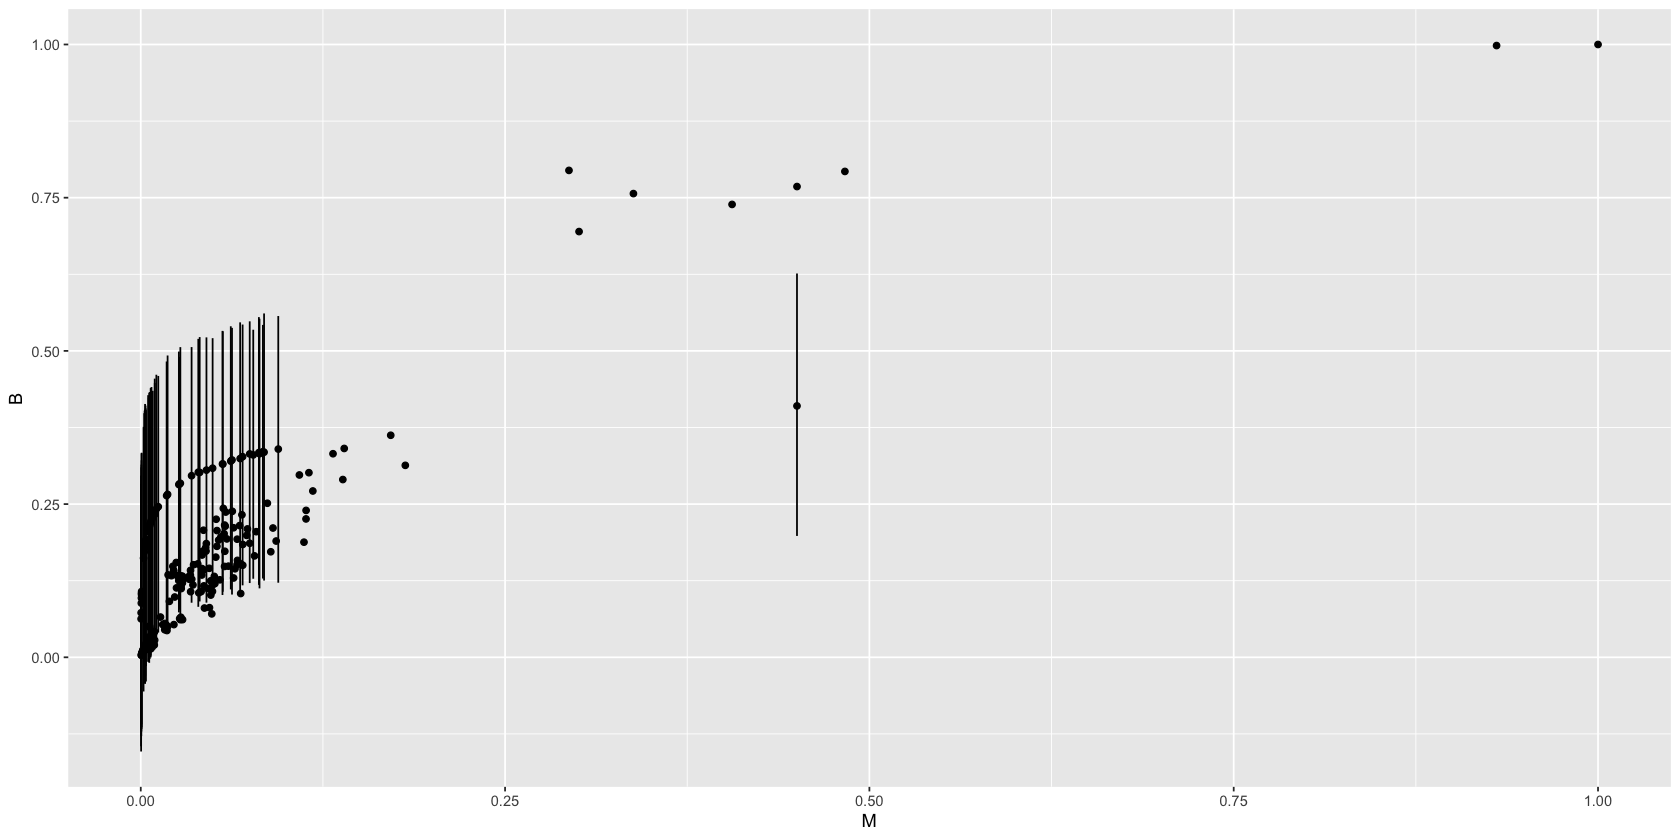

In [19]:
# get the draws for the imputed values and arrange them in a dataframe
draws <- as_draws_df(m15h5.fit)
imputed_draws <- draws[, grep('B_impute', colnames(draws))]
means <- apply(imputed_draws, 2, mean)
lower <- apply(imputed_draws, 2, function(x) quantile(x, 0.025))
upper <- apply(imputed_draws, 2, function(x) quantile(x, 0.975))
imputed_Ms <- M[B_missidx]
imputed_M_df <- data.frame(
    M = imputed_Ms,
    mean = means,
    lower = lower,
    upper = upper
)
ggplot() +
    geom_point(data = data.frame(M = M, B = B), mapping = aes(M, B)) +
    geom_point(data = imputed_M_df, mapping = aes(M, mean)) +
    geom_errorbar(data = imputed_M_df, mapping = aes(M, ymin = lower, ymax = upper))


As expected, the imputed values tend to move towards the mean of the data, which resulted in the trend observed when using imputed values being a 'flatter' or more average trend.

**15H7** Some lad named Andrew made an eight-sided spinner. He wanted to know if it is fair. So he spun it a bunch of times, recording the counts of each vlues. Then he accidentally spilled coffee over the 4s and 5s. The surviving data are summarized below.

| Value | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
| ---   |---|---|---|---|---|---|---|---|
| Frequency | 18 | 19 | 22 | NA | NA | 19 | 20 | 22 |

Your job is to impute the two missing values in the table above. Andrew doesn't remember how many times he spun the spinner. So you will have to assign a prior distribution for the total number of spins and then marginalize over the unknown total. Andrew is not sure the spinner is fair (every value is equally likely), but he's confident that none of the values is twice as likely as any other. Use a Dirichlet distribution to capture this prior belief. Plot the joint posterior distribution of the 4s and 5s.

**Answer**

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


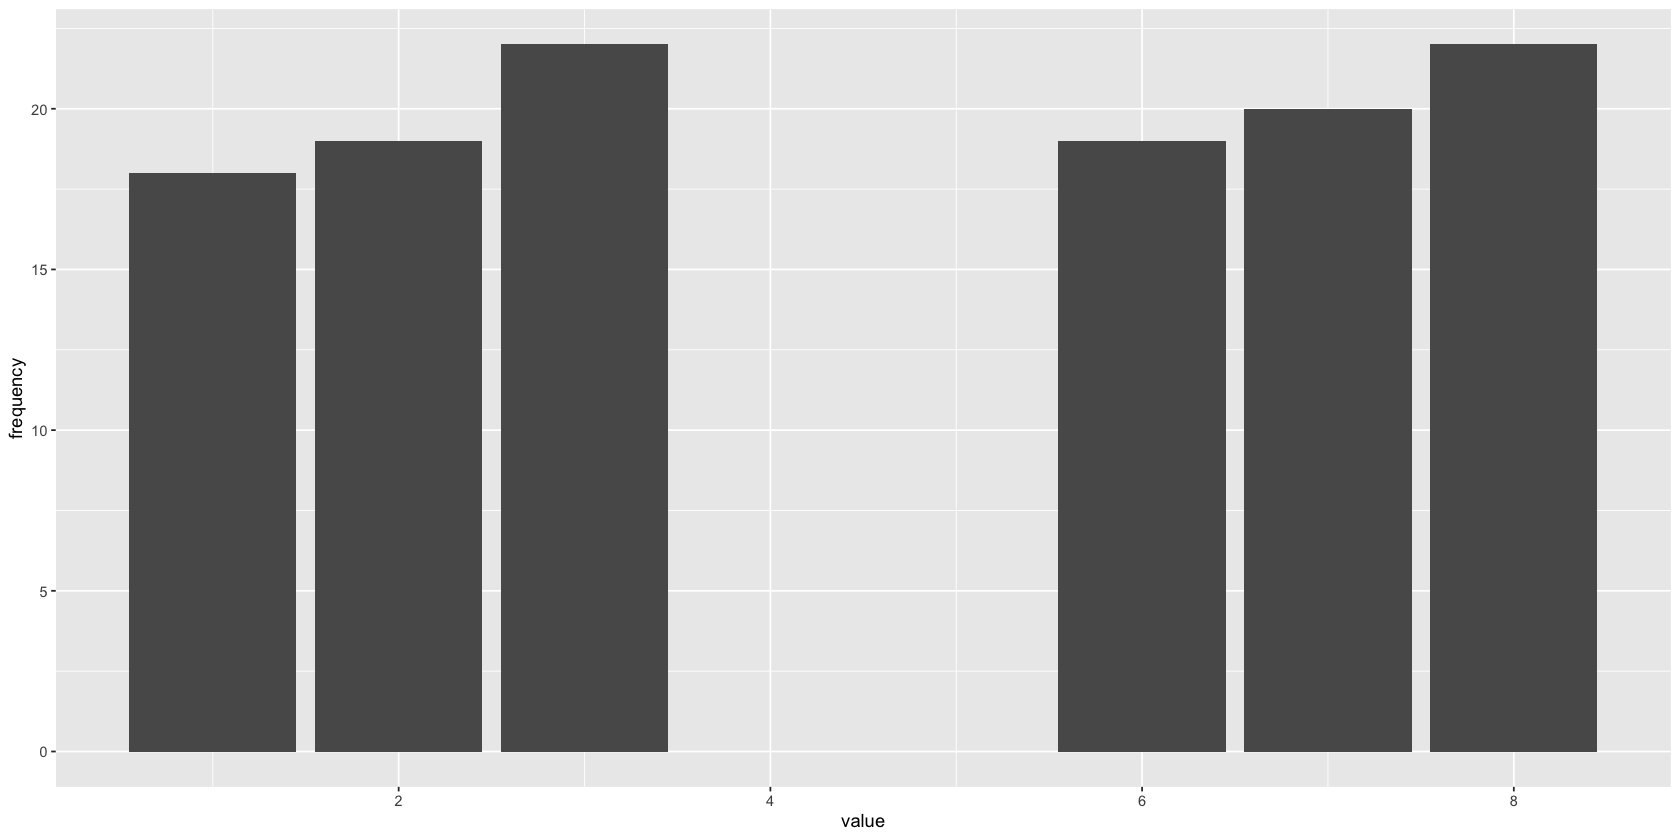

In [24]:
spinner_data <- data.frame(
    value = 1:8,
    frequency = c(18, 19, 22, NA, NA, 19, 20, 22)
)

ggplot(spinner_data, aes(value, frequency)) +
    geom_bar(stat = 'identity')

So we need to do a few things:
- Have some sort of model for the total number of spins
- Model the probability of rolling 4 and 5 (impute these)
- See if there is overlap

First let's see if we can do it while ignoring the missing data.

In [48]:
no_missing_spinner_data <- spinner_data[-which(is.na(spinner_data$frequency)), ]
m15h7.no_missing_data <- list(
    N = nrow(no_missing_spinner_data),
    counts = no_missing_spinner_data$frequency
)
print(m15h7.no_missing_data)
m15h7.no_missing_model_specification <- "
data {
    int N;
    array[N] int counts;
}
parameters {
    simplex[N] theta;
}
model {
    theta ~ dirichlet(rep_vector(1, N));
    counts ~ multinomial(theta);
}
"

m15h7.no_missing_file <- write_stan_file(m15h7.no_missing_model_specification)
m15h7.no_missing_model <- cmdstan_model(m15h7.no_missing_file)
m15h7.no_missing_fit <- m15h7.no_missing_model$sample(data = m15h7.no_missing_data)

$N
[1] 6

$counts
[1] 18 19 22 19 20 22



Running MCMC with 4 sequential chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Ite

              mean         sd      5.5%     94.5%      rhat ess_bulk
theta[1] 0.1506788 0.03167243 0.1022628 0.2041883 0.9995674 5017.588
theta[2] 0.1588854 0.03242333 0.1103533 0.2137232 1.0000383 4733.335
theta[3] 0.1826095 0.03493559 0.1284867 0.2409178 1.0003708 4497.799
theta[4] 0.1588891 0.03276924 0.1105851 0.2136197 1.0005386 5065.257
theta[5] 0.1662597 0.03290103 0.1168996 0.2218911 1.0011131 5027.028
theta[6] 0.1826775 0.03444353 0.1300950 0.2398141 1.0001666 4650.260


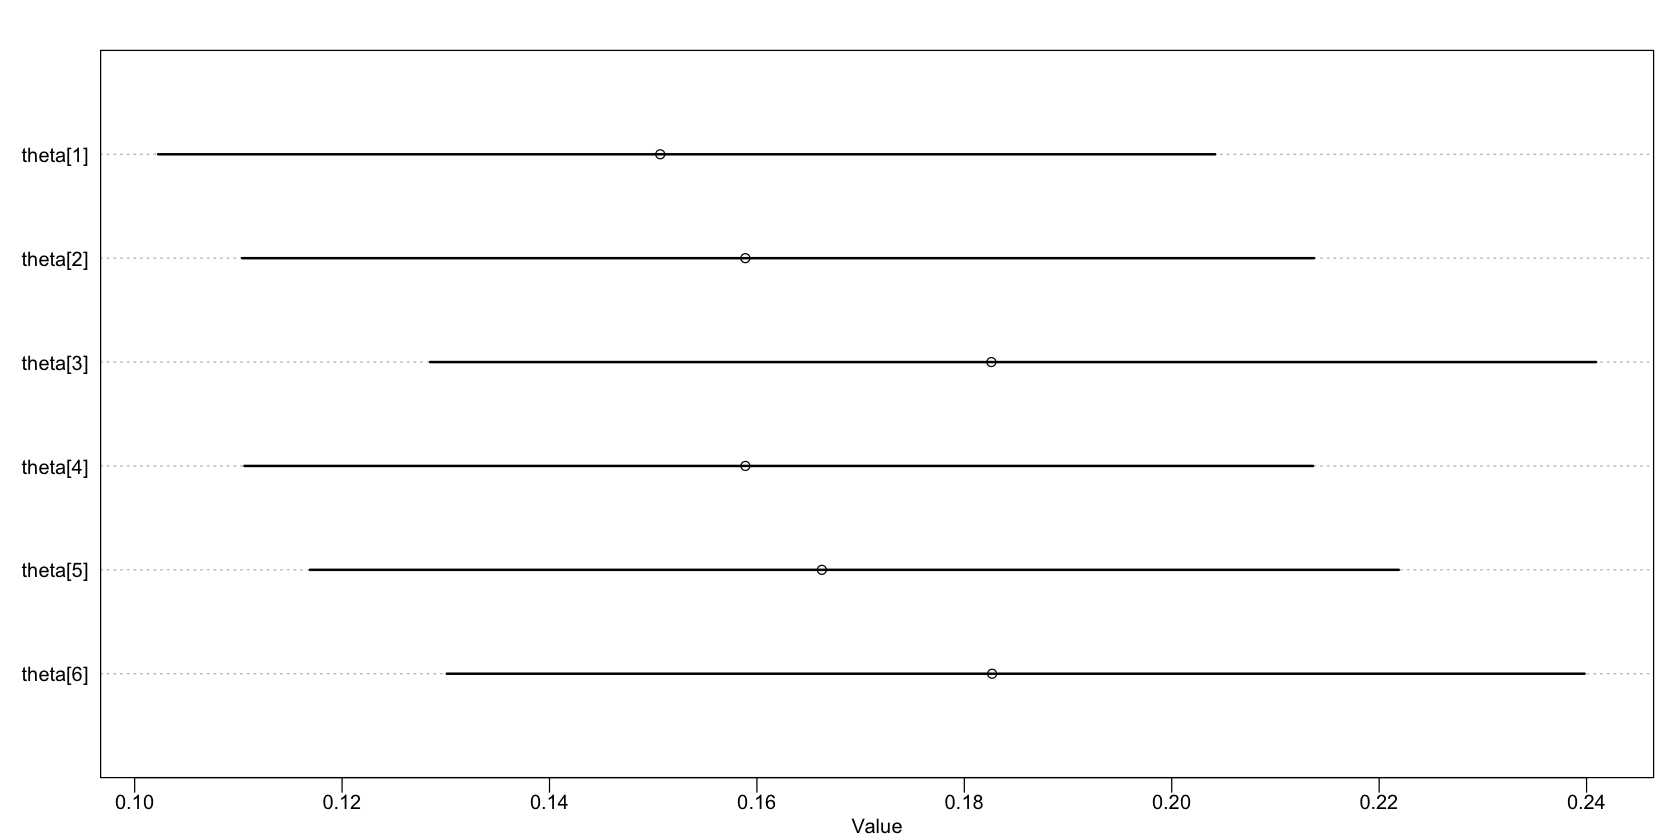

In [47]:
no_missing_results <- precis(m15h7.no_missing_fit, depth = 2)
print(no_missing_results)
par(bg = 'white')
plot(no_missing_results)

Now to incorporate the missing data.

First, we need to figure out some sort of model for $S$, the total number of spins. For that, we know that N must be at least our existing number spins.

In [50]:
sum(spinner_data$frequency, na.rm = TRUE)

[1] 120

So we have 120 spins for our 6 known values on the spinner $\to$ we expect that 4 and 5 have about 20 each. Since $S$ is a count variable, we can use a Poisson distribution. Thus,

$$
S \sim \text{Poisson}(40) + 120
$$

(40 because 20 each for 4 and 5)

Now we need to model the prior for $\theta$. We know that no spinner value is more than twice as likely as any other, which I don't think is a property that we can natively grab for the Dirichlet. Instead, we'll have to guess, check, and improve!

In [54]:
library(LaplacesDemon)
theta_sim <- rep(1, 8)
values <- rdirichlet(5, alpha = theta_sim)
print(max(values) / min(values))

[1] 225.5633


OK, that's clearly bigger than 2! We're just going to play around with the prior until we get that number down to 2 or so.

In [63]:
theta_sim <- rep(100, 8)
values <- rdirichlet(1000, alpha = theta_sim)
print(max(values) / min(values))

[1] 1.938154


OK, so it looks like a prior of 100 will do the trick.

In [68]:
m15h7.data <- list(
    N = nrow(no_missing_spinner_data),
    counts = no_missing_spinner_data$frequency
)
print(m15h7.data)
m15h7.model_specification <- "
data {
    int N; // existing
    array[N] int counts; // observed counts
}
parameters {
    simplex[N] theta;
    int N4;
    int N5;
}
transformed parameters {
    int N_total = N + 2;
}
model {
    N4 ~ poisson(20);
    N5 ~ poisson(20);

    // merge the observed counts and the imputed ones
    array[N] int merged_counts;
    for (i in 1:N) {
        merged_counts[i] = counts[i];
    }
    merged_counts[N + 1] = N4;
    merged_counts[N + 2] = N5;
    theta ~ dirichlet(rep_vector(100, N_total));
    total_counts ~ multinomial(theta);
}
"

m15h7.file <- write_stan_file(m15h7.model_specification)
m15h7.model <- cmdstan_model(m15h7.file)
m15h7.fit <- m15h7._model$sample(data = m15h7.data)

$N
[1] 6

$counts
[1] 18 19 22 19 20 22



Semantic error in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpSxi0RD/model-119cb49bcb3c0.stan', line 8, column 4 to column 11:
   -------------------------------------------------
     6:  parameters {
     7:      simplex[N] theta;
     8:      int N4;
             ^
     9:      int N5;
    10:  }
   -------------------------------------------------

(Transformed) Parameters cannot be integers.


make: *** [/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpSxi0RD/model-119cb49bcb3c0.hpp] Error 1




ERROR: Error: An error occured during compilation! See the message above for more information.


Honestly, at this point I'm not sure what to do with this. Looking online, it looks like missing integer parameters are really hard to deal with.